In [167]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import StackingClassifier

%matplotlib inline
RSEED = 42



In [168]:
df_raw = pd.read_csv('data/data/Kickstarter000.csv')
for i in range(1, 56, 1):
    filename = 'data/data/Kickstarter0' + str(i).zfill(2) + '.csv'
    tt = pd.read_csv(filename)
    df_raw = pd.concat([df_raw, tt], axis=0)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 964
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obje

In [169]:
#df_raw.columns

In [170]:
#df_raw

In [171]:
df = df_raw[['blurb', 'category','country', 'created_at', 
       'currency','deadline', 'goal', 'id',
       'launched_at', 'location','name', 'slug',
       'source_url', 'state', 
       'urls', 'usd_pledged']] # , 'usd_type'

In [172]:
df.dropna(axis=0, inplace=True)

/Users/clemensbretscher/neuefische/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [173]:
# Month of project deadline
df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month
#df

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/3943520250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month


In [174]:
# Duration the the project was online
df.eval('duration = (deadline - launched_at)/3600/24', inplace=True)
# Time between project creation and launchin
df.eval('duration_start_launch = (launched_at - created_at)/3600/24', inplace=True)
df.drop(['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
#df.head()

/Users/clemensbretscher/neuefische/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [175]:
df.eval('goal_per_duration = goal / duration', inplace=True)

In [176]:
# Extract category nae
import json
df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
df.drop('category', axis=1, inplace=True)
#df.head()

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/4201644507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
/Users/clemensbretscher/neuefische/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [177]:
# Get name length
df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))
df['name_upper_case'] = df['name'].apply(lambda x : sum(1 for c in x if c.isupper())/len(x))
df.drop('name', axis=1, inplace=True)

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/3788529939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))
/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/3788529939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_upper_case'] = df['name'].apply(lambda x : sum(1 for c in x if c.isupper())/len(x))


In [178]:
df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))
df.drop('blurb', axis=1, inplace=True)

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/3027176886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))


In [179]:
# Extract city name
df['city'] = df['location'].map(lambda x : (x.split('"'))[5])
df.drop('location', axis=1, inplace=True)

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/1543756393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = df['location'].map(lambda x : (x.split('"'))[5])


In [180]:
df['successful'] = (df['state'] == 'successful').astype(int)
df = df[~df['state'].isin(['canceled', 'live', 'suspended'])]
df.drop('state', axis=1, inplace=True)

/var/folders/6c/7n7j756n25n7b2f_mzn58nww0000gn/T/ipykernel_96116/1761087603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['successful'] = (df['state'] == 'successful').astype(int)


## Data cleaning
Removing duplicate rows, removing outliers, ...

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192447 entries, 0 to 964
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                192447 non-null  object 
 1   currency               192447 non-null  object 
 2   goal                   192447 non-null  float64
 3   id                     192447 non-null  int64  
 4   slug                   192447 non-null  object 
 5   source_url             192447 non-null  object 
 6   urls                   192447 non-null  object 
 7   usd_pledged            192447 non-null  float64
 8   month                  192447 non-null  int64  
 9   duration               192447 non-null  float64
 10  duration_start_launch  192447 non-null  float64
 11  goal_per_duration      192447 non-null  float64
 12  category_name          192447 non-null  object 
 13  name_length            192447 non-null  int64  
 14  name_upper_case        192447 non-null 

In [182]:
df_drop_dup = df.drop_duplicates(subset='id', keep='last')
#df_drop_dup.info()

In [183]:
df_drop_dup = df_drop_dup[df_drop_dup['name_length'] <= 20]

In [184]:
#df_drop_dup['blurb_length'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['blurb_length'] <= 40]

In [185]:
#df_drop_dup['goal'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['goal'] <= 10000000]

In [186]:
df_drop_dup = df_drop_dup[df_drop_dup['duration_start_launch'] <= 1000]

In [187]:
df_dummies = pd.get_dummies(df_drop_dup, columns=['country', 'currency', 'category_name', 'month'], drop_first=True)

In [188]:
features_dummies = list(df_dummies.columns)
features = list(df.columns)
for i in ['id', 'slug', 'source_url', 'urls',
        'usd_pledged', 'city']:
    features_dummies.remove(i)
    features.remove(i)

## Profile report

In [189]:
#from pandas_profiling import ProfileReport
##profile = ProfileReport(df[features], title="Pandas Profiling Report", explorative=True)
#profile

## Baseline model

## Simple Decision Tree Model

In [190]:
%run Helper_methods.ipynb    

<Figure size 576x576 with 0 Axes>

In [191]:
X = df[['name_length']]
y = np.array(df['successful'])
train, test, train_label, test_label = train_test_split(X, y, stratify=y, 
                    random_state=RSEED, test_size=0.3)

In [192]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(train, train_label)
y_pred = clf.predict(test)

accuracy_score 0.6168182211829912
f1-score 0.7424113640333002
[[ 3731 18814]
 [ 3309 31881]]
Confusion matrix, without normalization
[[ 3731 18814]
 [ 3309 31881]]


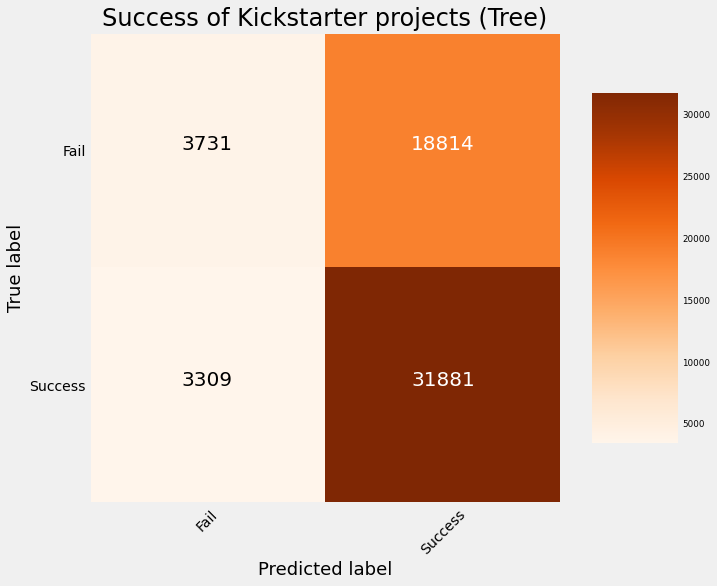

In [193]:
print('accuracy_score', accuracy_score(test_label, y_pred))
print('f1-score', f1_score(test_label, y_pred))
cm = confusion_matrix(test_label, y_pred)
print(cm)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

## Plot success rate per category

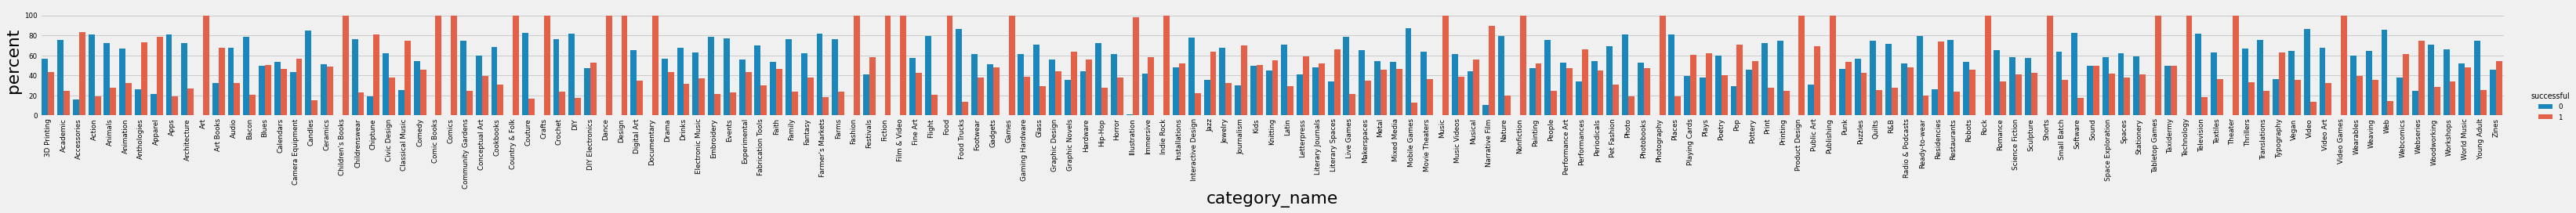

In [194]:
x,y = 'category_name', 'successful'

df1 = df_drop_dup.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=3, aspect=15)
g.ax.set_ylim(0,110)


plt.xticks(rotation=90)
plt.rcParams['figure.dpi'] = 600

## Correct imbalance

In [195]:
X = df_dummies[features_dummies].drop('successful',axis=1)
y = np.array(df_dummies['successful'])

In [196]:
oversample = RandomOverSampler(sampling_strategy='minority', 
                random_state=RSEED)
X_over, y_over = oversample.fit_resample(X, y)
train, test, train_label, test_label = train_test_split(
                    X_over, y_over, stratify=y_over, 
                    random_state=RSEED, test_size=0.3)

In [197]:
yy = pd.Series(y_over)
df_bal = pd.concat([X_over, yy],axis=1)
df_bal.head()

goal   duration  duration_start_launch  goal_per_duration  name_length  \
0    200.0  45.000000               4.066620           4.444444            4   
1   1000.0  30.000000               2.459491          33.333333            4   
2  20000.0  10.958785             211.789410        1825.019882            7   
3  14500.0  30.000000              45.005729         483.333333            5   
4  10000.0  31.000000              22.271551         322.580645            1   

   name_upper_case  blurb_length  country_AU  country_BE  country_CA  ...  \
0         0.190476            26           0           0           0  ...   
1         0.133333            22           0           0           0  ...   
2         0.111111            22           0           0           0  ...   
3         0.125000            17           0           0           0  ...   
4         1.000000             9           0           0           0  ...   

   month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
0        0        0        0        0        0        0         0         0   
1        0        0        0        0        0        0         0         0   
2        0        0        0        0        0        0         0         1   
3        0        0        0        0        0        1         0         0   
4        0        0        1        0        0        0         0         0   

   month_12  0  
0         1  1  
1         0  0  
2         0  0  
3         0  0  
4         0  0  

[5 rows x 211 columns]

<AxesSubplot:>

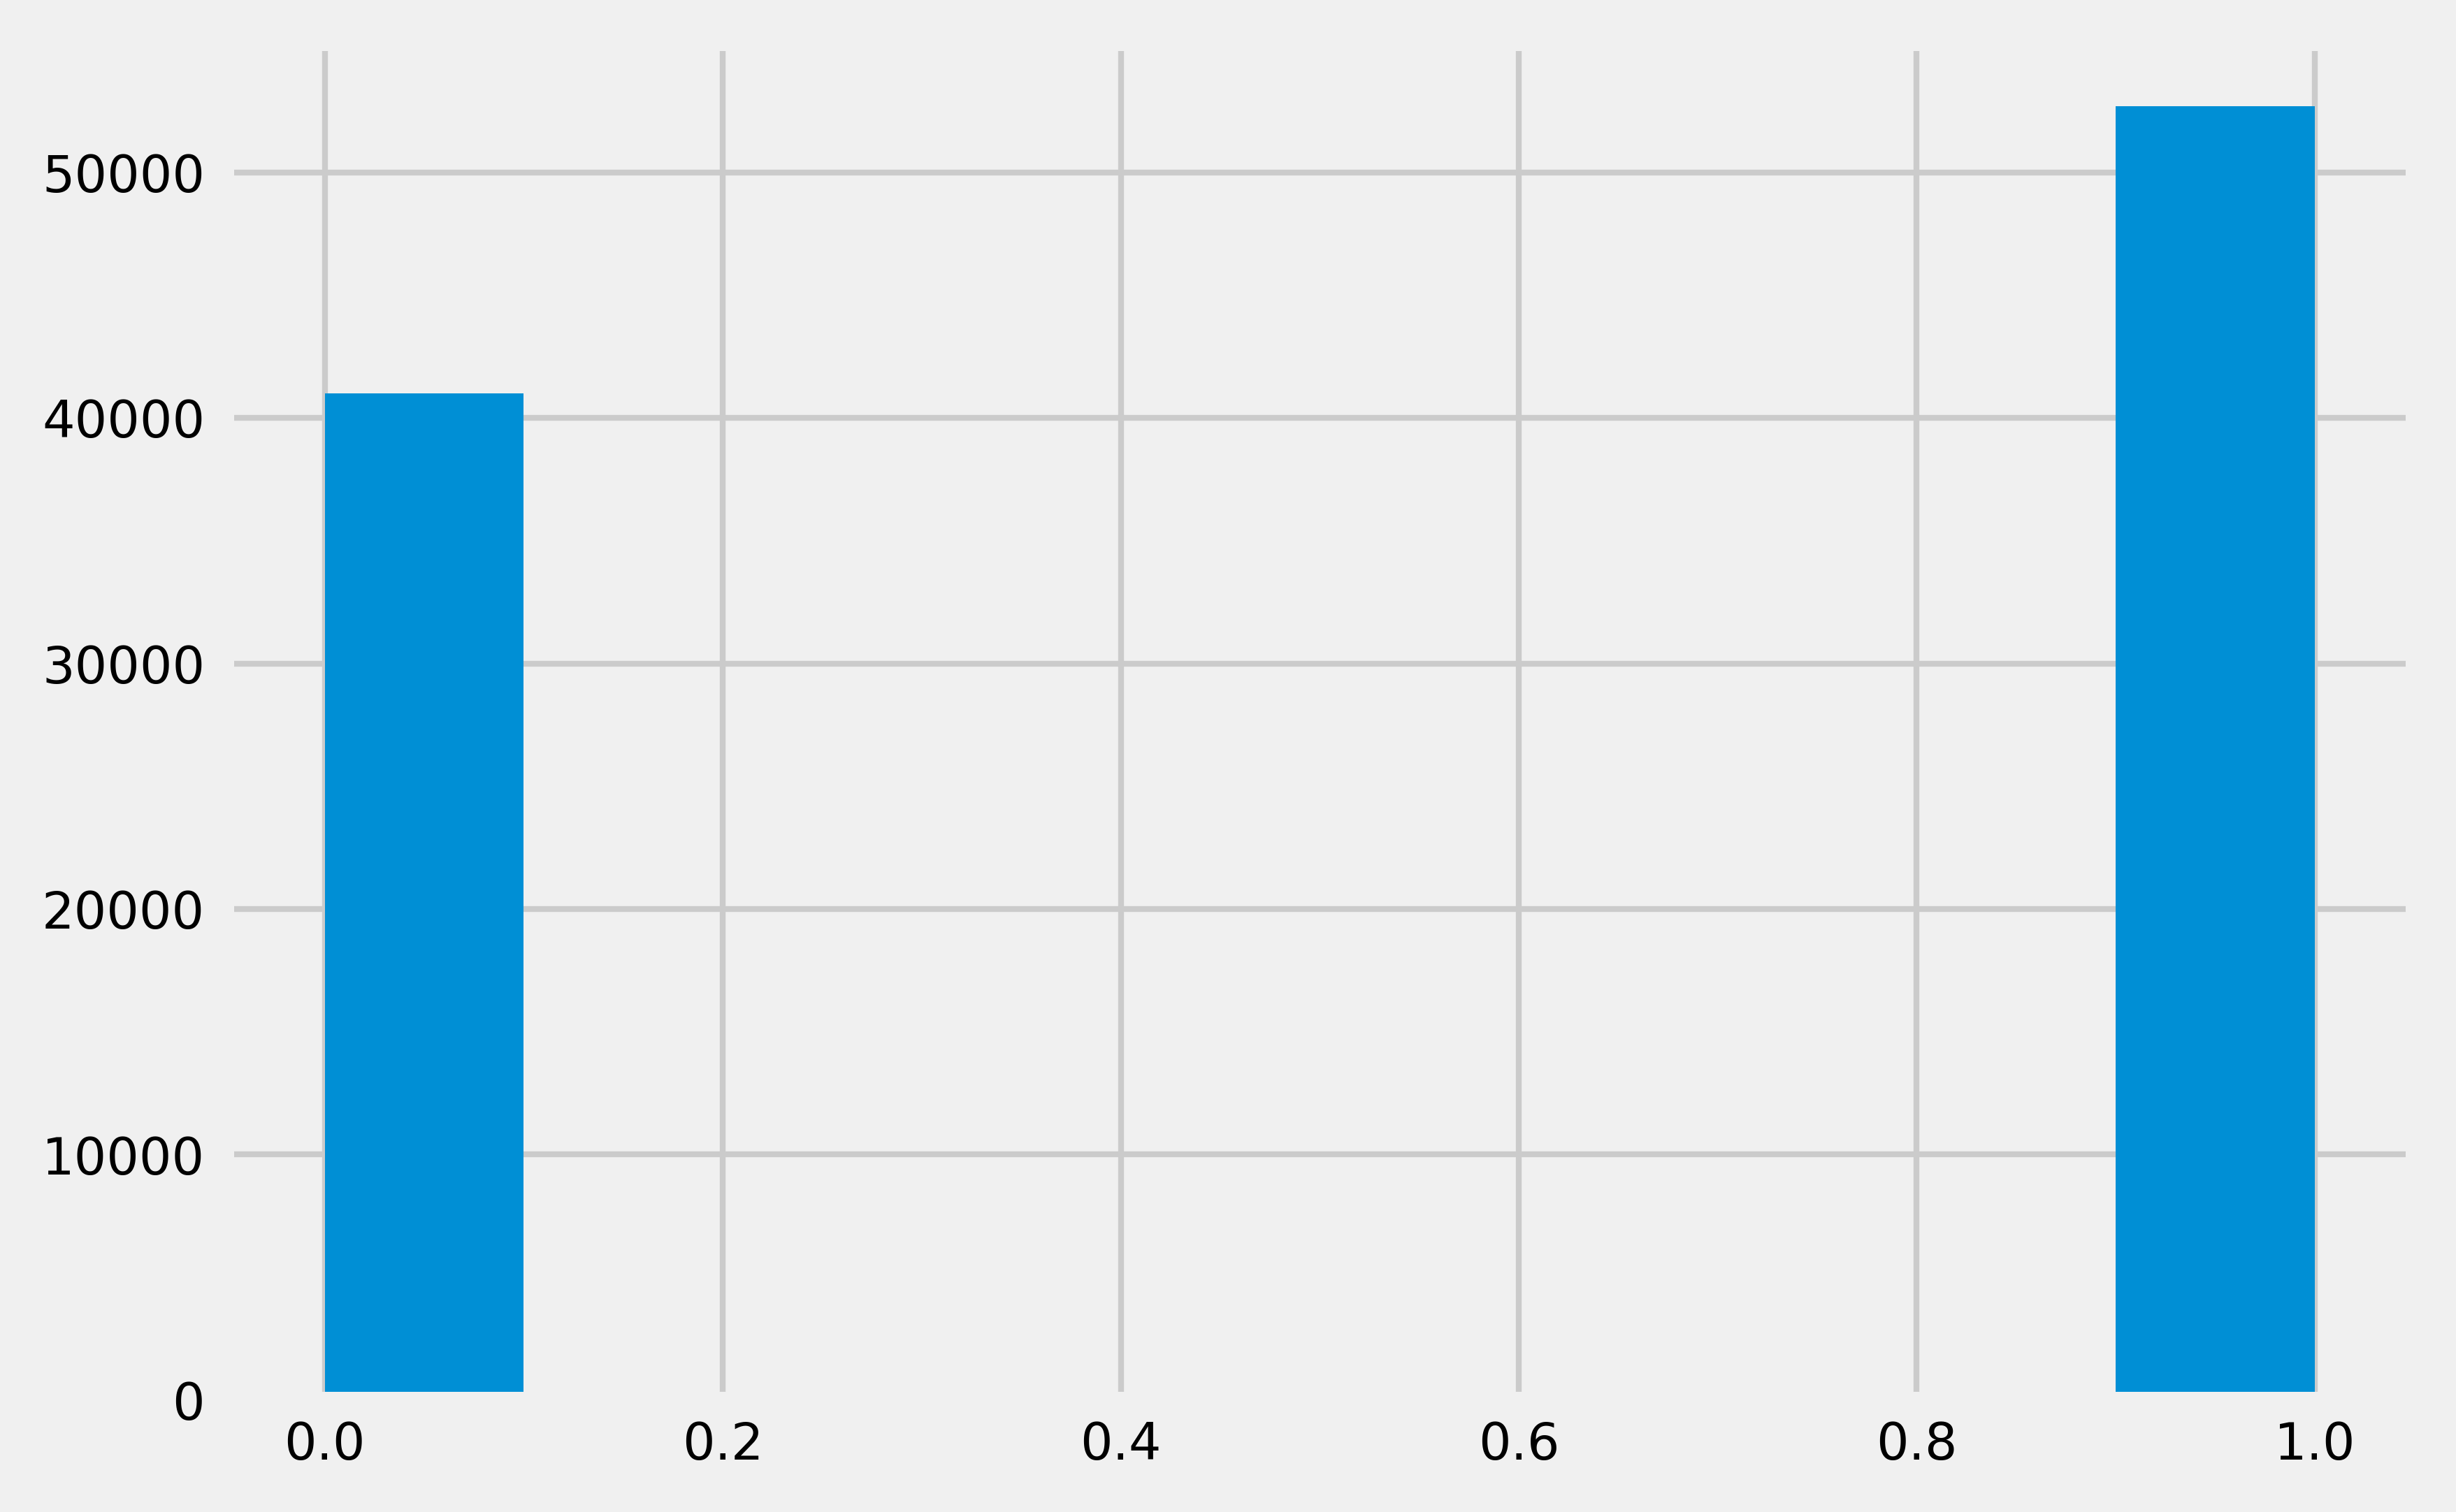

In [198]:
df_bal[df_bal['name_length'] > 5][0].hist()

<function matplotlib.pyplot.show(close=None, block=None)>

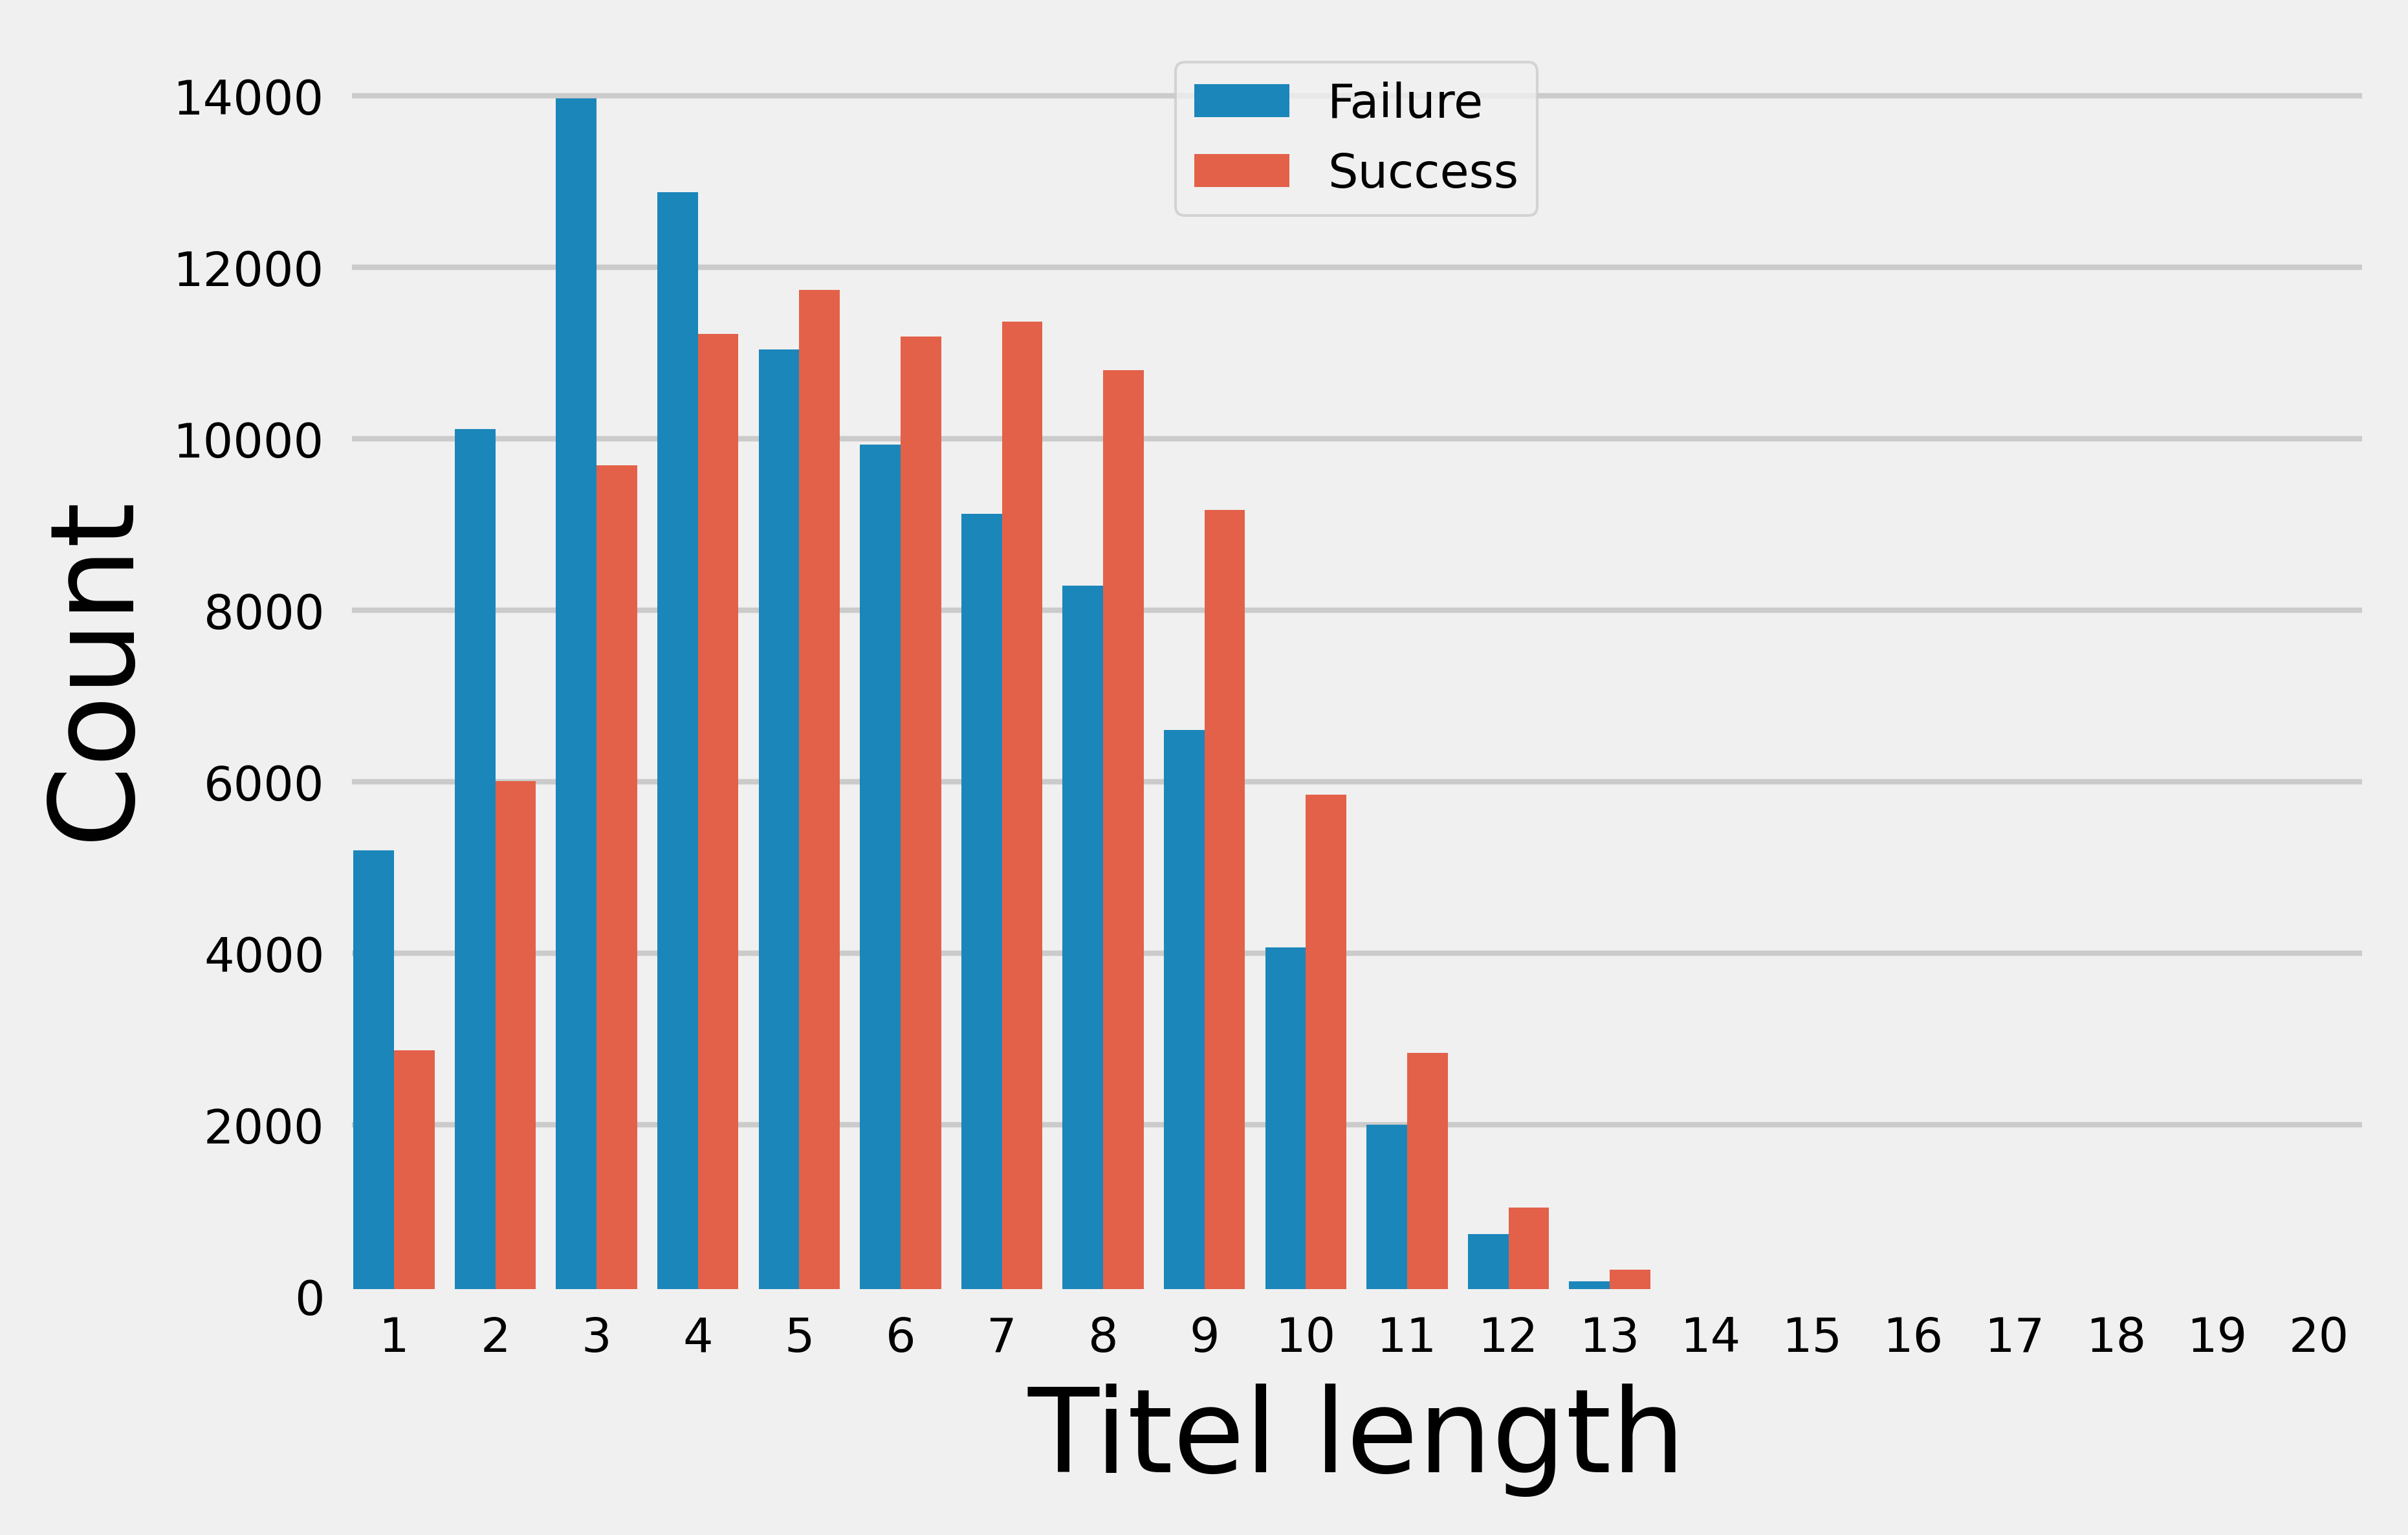

In [199]:
ax = sns.countplot(data=df_bal, x="name_length", hue=0)
ax.set(xlabel= 'Titel length', ylabel='Count')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Failure','Success'])#, bbox_to_anchor=(1,1))
plt.show

In [200]:
df_bal

goal   duration  duration_start_launch  goal_per_duration  \
0           200.0  45.000000               4.066620           4.444444   
1          1000.0  30.000000               2.459491          33.333333   
2         20000.0  10.958785             211.789410        1825.019882   
3         14500.0  30.000000              45.005729         483.333333   
4         10000.0  31.000000              22.271551         322.580645   
...           ...        ...                    ...                ...   
188433  1000000.0  60.000000              23.142604       16666.666667   
188434      450.0  30.000000              49.095787          15.000000   
188435     8000.0  30.000000              18.203657         266.666667   
188436      500.0  30.000000               1.675914          16.666667   
188437      600.0  10.524086             402.145972          57.012079   

        name_length  name_upper_case  blurb_length  country_AU  country_BE  \
0                 4         0.190476            26           0           0   
1                 4         0.133333            22           0           0   
2                 7         0.111111            22           0           0   
3                 5         0.125000            17           0           0   
4                 1         1.000000             9           0           0   
...             ...              ...           ...         ...         ...   
188433            2         0.111111            18           0           0   
188434            4         0.342857            21           0           0   
188435           10         0.400000            21           0           0   
188436            5         0.333333            21           0           0   
188437            5         0.138889            24           0           0   

        country_CA  ...  month_4  month_5  month_6  month_7  month_8  month_9  \
0                0  ...        0        0        0        0        0        0   
1                0  ...        0        0        0        0        0        0   
2                0  ...        0        0        0        0        0        0   
3                0  ...        0        0        0        0        0        1   
4                0  ...        0        0        1        0        0        0   
...            ...  ...      ...      ...      ...      ...      ...      ...   
188433           0  ...        0        1        0        0        0        0   
188434           0  ...        0        0        0        0        1        0   
188435           0  ...        0        0        0        0        0        1   
188436           1  ...        0        0        0        1        0        0   
188437           0  ...        0        0        0        0        1        0   

        month_10  month_11  month_12  0  
0              0         0         1  1  
1              0         0         0  0  
2              0         1         0  0  
3              0         0         0  0  
4              0         0         0  0  
...          ...       ...       ... ..  
188433         0         0         0  0  
188434         0         0         0  0  
188435         0         0         0  0  
188436         0         0         0  0  
188437         0         0         0  0  

[188438 rows x 211 columns]

In [201]:
# Chance of success per duration between start and launch
# df_dummies['duration_start_launch_rounded'] = \
#             df_dummies['duration_start_launch'].apply(
#             lambda x : int(round(x,0)))
# bins = np.arange(0,400, 14)
# days = df_dummies['duration_start_launch_rounded']
# weeks = pd.cut(days, bins=bins, labels=range(1,len(bins)), right=False)
# weeks.name = 'weeks'
# df_dummies_weeks = df_dummies.join(weeks, lsuffix='_l', rsuffix='_r')

# dur_grouped = df_dummies_weeks[['weeks', 'successful']].groupby(
#             ['weeks']).count()
# dur_grouped.reset_index(inplace=True)
# dur_grouped.columns = ['weeks', 'num_of_projects']


# dur_grouped['successrate'] = dur_grouped['weeks'].apply(
#     lambda x : df_dummies_weeks[df_dummies_weeks['weeks']==x]['successful'].sum())
# dur_grouped.eval('successrate = successrate / num_of_projects', inplace=True)
# dur_grouped


# plt.plot(data=dur_grouped, x='duration_start_launch_rounded', y='successrate')
# # plt.imshow(cm, interpolation='nearest', cmap=cmap)
# plt.title(title, size = 24)
# plt.colorbar(aspect=4)
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45, size = 14)
# plt.yticks(tick_marks, classes, size = 14)# 
# plt.figure(figsize = (3, 4))
# plt.ylim(0, 1)
# plt.xlim(0, 300)
sns.lineplot(data=dur_grouped, x='weeks', y='successrate')
# plt.style.use('fivethirtyeight')
# plt.rcParams['font.size'] = 4
# plt.figure(figsize = (1, 1))

NameError: name 'dur_grouped' is not defined

## Simple Tree model

accuracy_score 0.7735795655557914
f1-score 0.7547704804965898
Confusion matrix, without normalization
[[24034  4232]
 [ 8568 19698]]


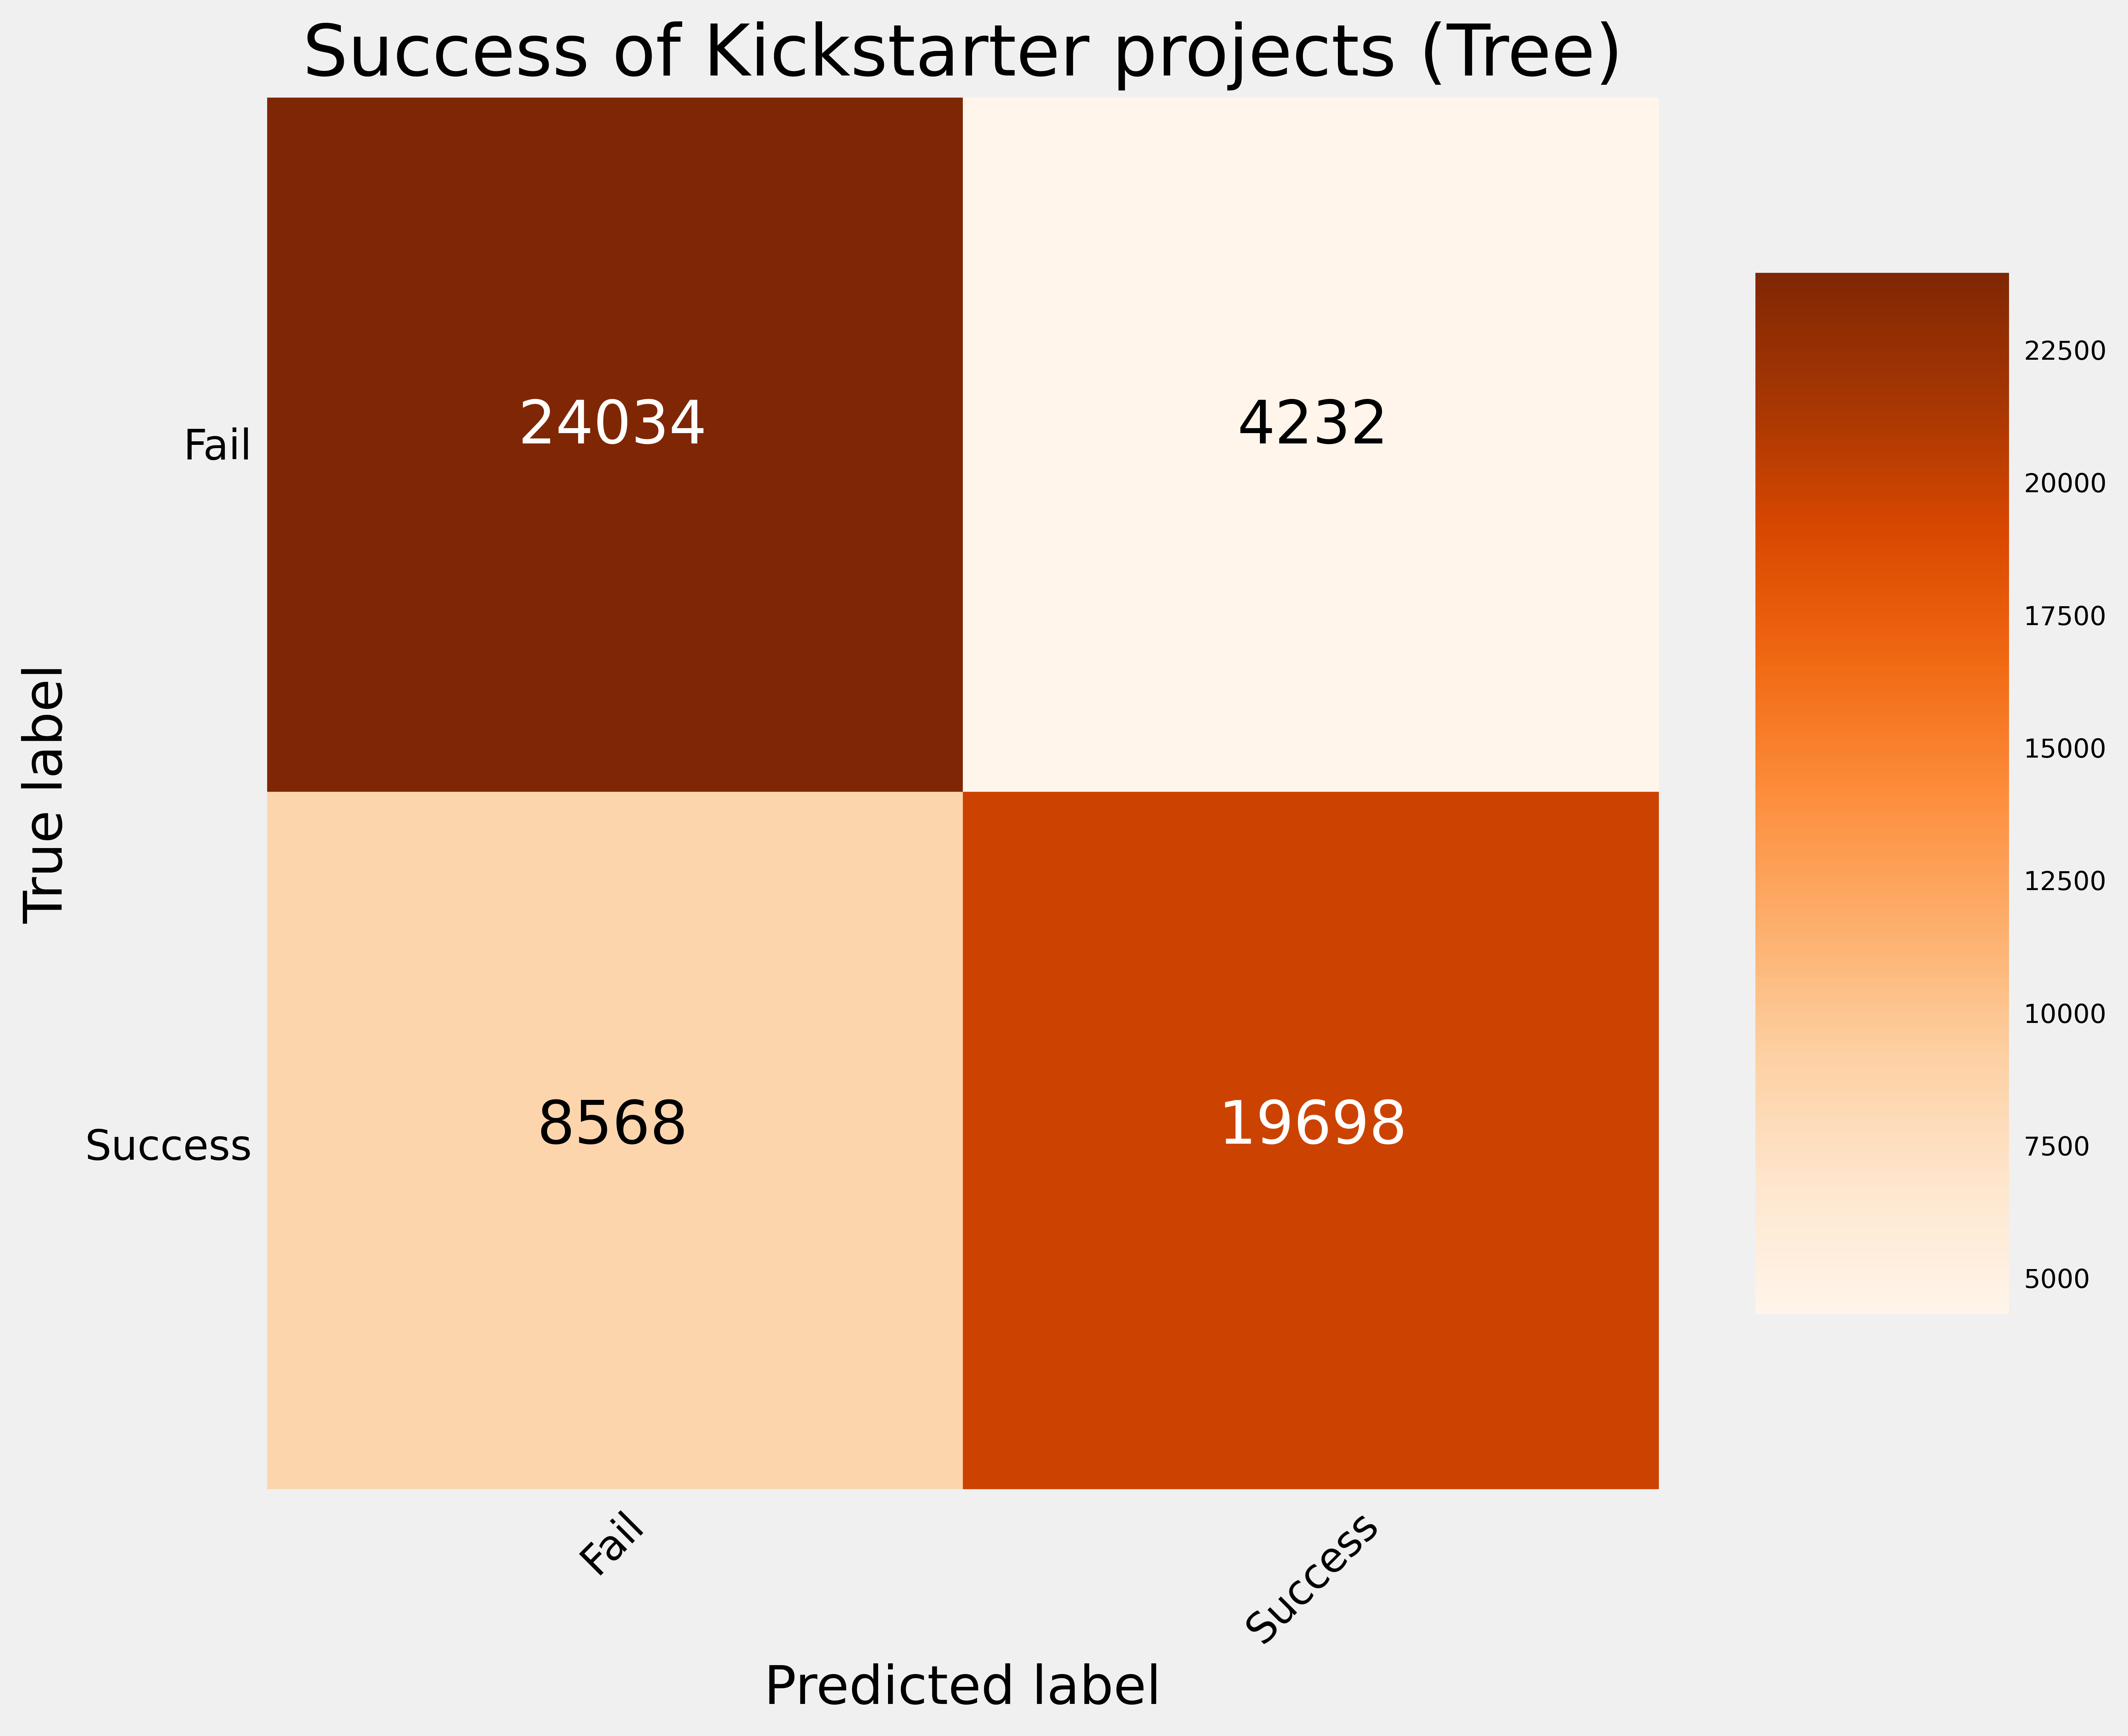

In [202]:
clf_tree = DecisionTreeClassifier()
y_pred_tree = clf_train_predict(clf_tree, train, train_label, test)
cm = simple_metrics(test_label, y_pred_tree)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

Sclaing of Features

In [203]:
list(train.columns)

['goal',
 'duration',
 'duration_start_launch',
 'goal_per_duration',
 'name_length',
 'name_upper_case',
 'blurb_length',
 'country_AU',
 'country_BE',
 'country_CA',
 'country_CH',
 'country_DE',
 'country_DK',
 'country_ES',
 'country_FR',
 'country_GB',
 'country_HK',
 'country_IE',
 'country_IT',
 'country_JP',
 'country_LU',
 'country_MX',
 'country_NL',
 'country_NO',
 'country_NZ',
 'country_SE',
 'country_SG',
 'country_US',
 'currency_CAD',
 'currency_CHF',
 'currency_DKK',
 'currency_EUR',
 'currency_GBP',
 'currency_HKD',
 'currency_JPY',
 'currency_MXN',
 'currency_NOK',
 'currency_NZD',
 'currency_SEK',
 'currency_SGD',
 'currency_USD',
 'category_name_Academic',
 'category_name_Accessories',
 'category_name_Action',
 'category_name_Animals',
 'category_name_Animation',
 'category_name_Anthologies',
 'category_name_Apparel',
 'category_name_Apps',
 'category_name_Architecture',
 'category_name_Art',
 'category_name_Art Books',
 'category_name_Audio',
 'category_name_Bacon

In [204]:
scaler = StandardScaler()
#scaler = MinMaxScaler
col_scale = ['goal', 'duration', 'duration_start_launch',
            'goal_per_duration', 'name_length',
            'name_upper_case', 'blurb_length']
train_scaled = scaler.fit_transform(train[col_scale])
test_scaled = scaler.transform(test[col_scale])
# train = train.drop(col_scale, axis=1)
# test = test.drop(col_scale, axis=1)

train = np.concatenate([train_scaled, train.drop(col_scale, axis=1)], axis=1)
test = np.concatenate([test_scaled, test.drop(col_scale, axis=1)], axis=1)


## Trying different models

1. Random Forest 

accuracy_score 0.8161572206891672
f1-score 0.8053417242606432
Confusion matrix, without normalization
[[24640  3626]
 [ 6767 21499]]


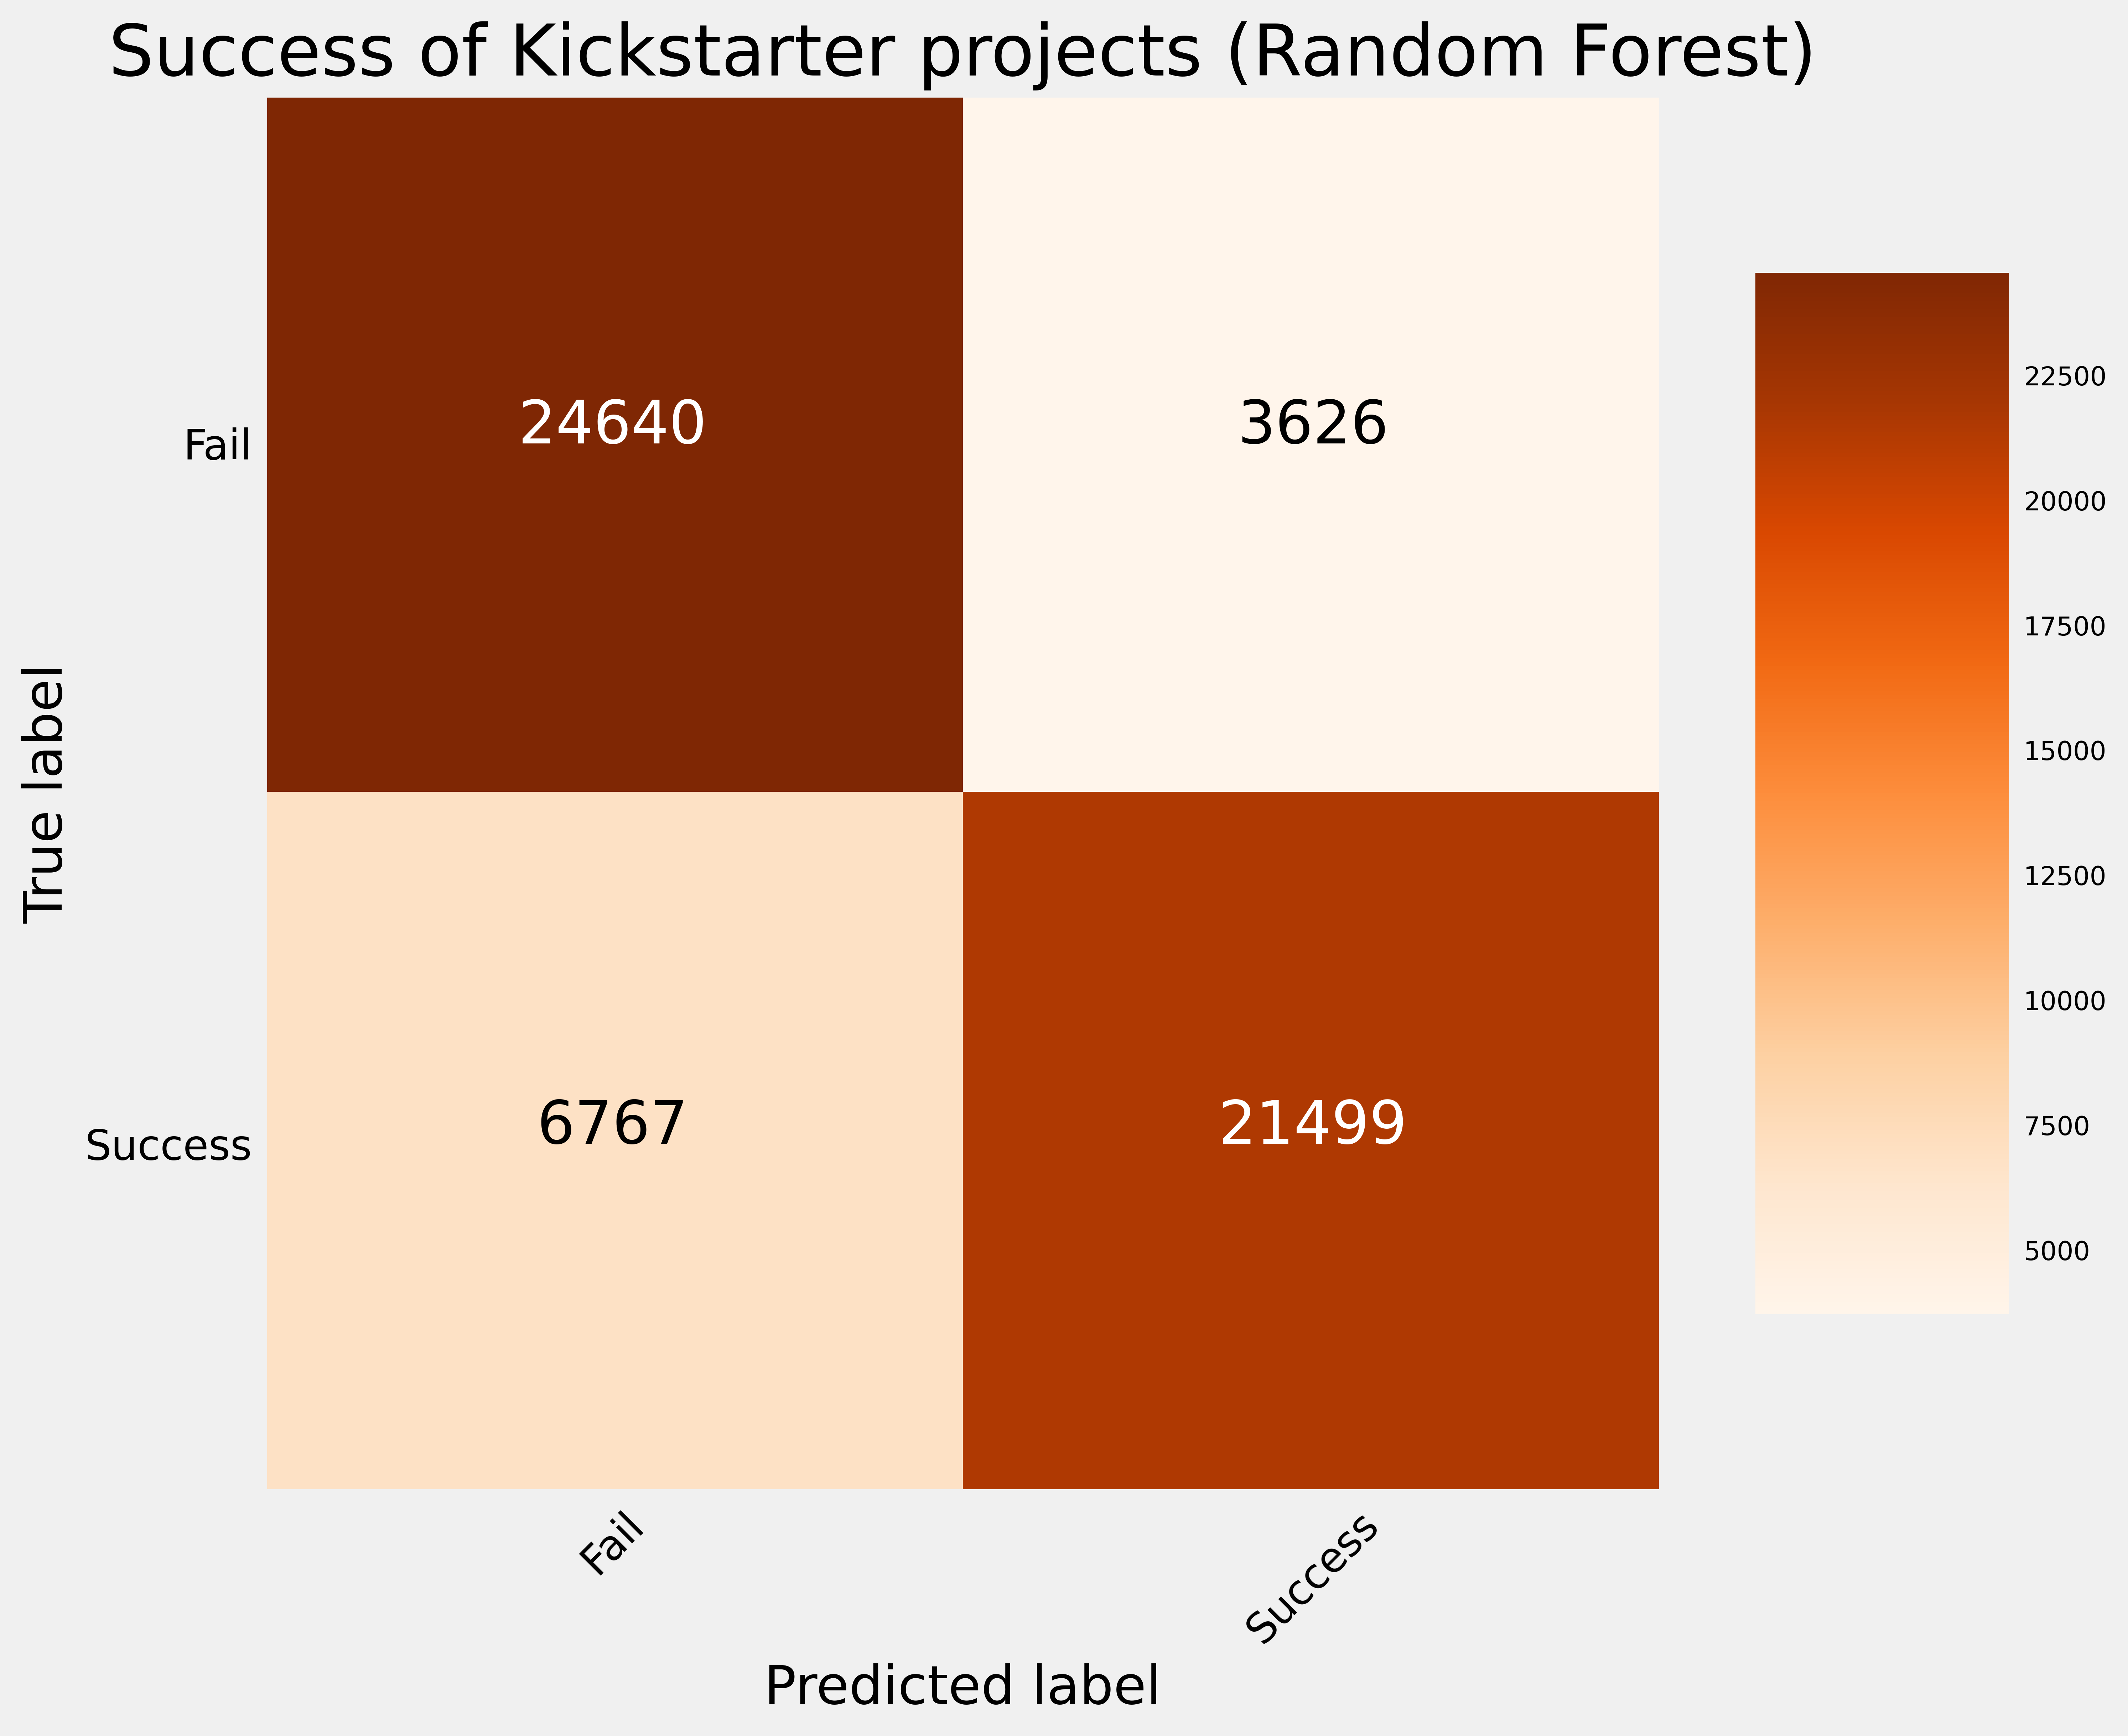

In [205]:
from sklearn.ensemble import RandomForestClassifier
{'n_estimators': 60, 'min_samples_split': 2, 'min_impurity_decrease': 0.0,
'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
clf_rf = RandomForestClassifier(
    n_estimators=60, #100,
    max_depth=50, #None, 
    min_samples_split=2, 
    max_features='sqrt', 
    min_impurity_decrease=0.0,
    bootstrap=False, #True, 
    oob_score=False, 
    n_jobs=-1,
    random_state=RSEED
)
y_pred_rf = clf_train_predict(clf_rf, train, train_label, test)
cm = simple_metrics(test_label, y_pred_rf)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest)'
)

------

In [206]:
#take the test data and convert it to a dataframe. then add the column names
#create the column names: 
column_names = list(df_bal.columns)
#remove the success column
column_names.pop()


#create a dataframe from the test data:
test_data_frame = pd.DataFrame(test)
#replace the column names with the column names of the original dataset
test_data_frame.columns = column_names

#add the predicted and actual values and rename them accordingly
test_data_frame = pd.concat((test_data_frame, pd.Series(y_pred_rf)), axis =1)
test_data_frame.rename(columns={0: 'predicted_success'}, inplace=True)
test_data_frame = pd.concat((test_data_frame, pd.Series(test_label)), axis =1)
test_data_frame.rename(columns={0: 'actual_success'}, inplace=True)

#create a column cm (confusion matrix)
test_data_frame['cm'] = test_data_frame.apply(lambda x: 'true_positive' if (x['actual_success'] == 1 and x['predicted_success'] == 1) else '', axis=1)
test_data_frame['cm'] = test_data_frame.apply(lambda x: 'true_negative' if (x['actual_success'] == 0 and x['predicted_success'] == 0 and x['cm'] == '') else x['cm'], axis=1)
test_data_frame['cm'] = test_data_frame.apply(lambda x: 'false_positive' if (x['actual_success'] == 0 and x['predicted_success'] == 1 and x['cm'] == '') else x['cm'], axis=1)
test_data_frame['cm'] = test_data_frame.apply(lambda x: 'false_negative' if (x['actual_success'] == 1 and x['predicted_success'] == 0 and x['cm'] == '') else x['cm'], axis=1)


In [207]:
#the values need to be reverse scaled
reverse_scaled = scaler.inverse_transform(test_data_frame[col_scale])
reversed_scale_data = pd.DataFrame(reverse_scaled)

reversed_scale_data.columns=['goal',
 'duration',
 'duration_start_launch',
 'goal_per_duration',
 'name_length',
 'name_upper_case',
 'blurb_length',]


In [208]:
#entferne die skalierten Werte aus dem test_data_frame
test_data_frame.drop(['goal',
 'duration',
 'duration_start_launch',
 'goal_per_duration',
 'name_length',
 'name_upper_case',
 'blurb_length',], axis=1, inplace=True)

In [209]:
#combine the dataframes
test_data_frame = pd.concat((test_data_frame, reversed_scale_data), axis=1)

In [ ]:
sns.pairplot(data=test_data_frame[[
 'goal',
 'duration',
 'duration_start_launch',
 'cm']], hue='cm', plot_kws={"s": 3})

sns.set_context("paper", rc={"axes.labelsize":8})

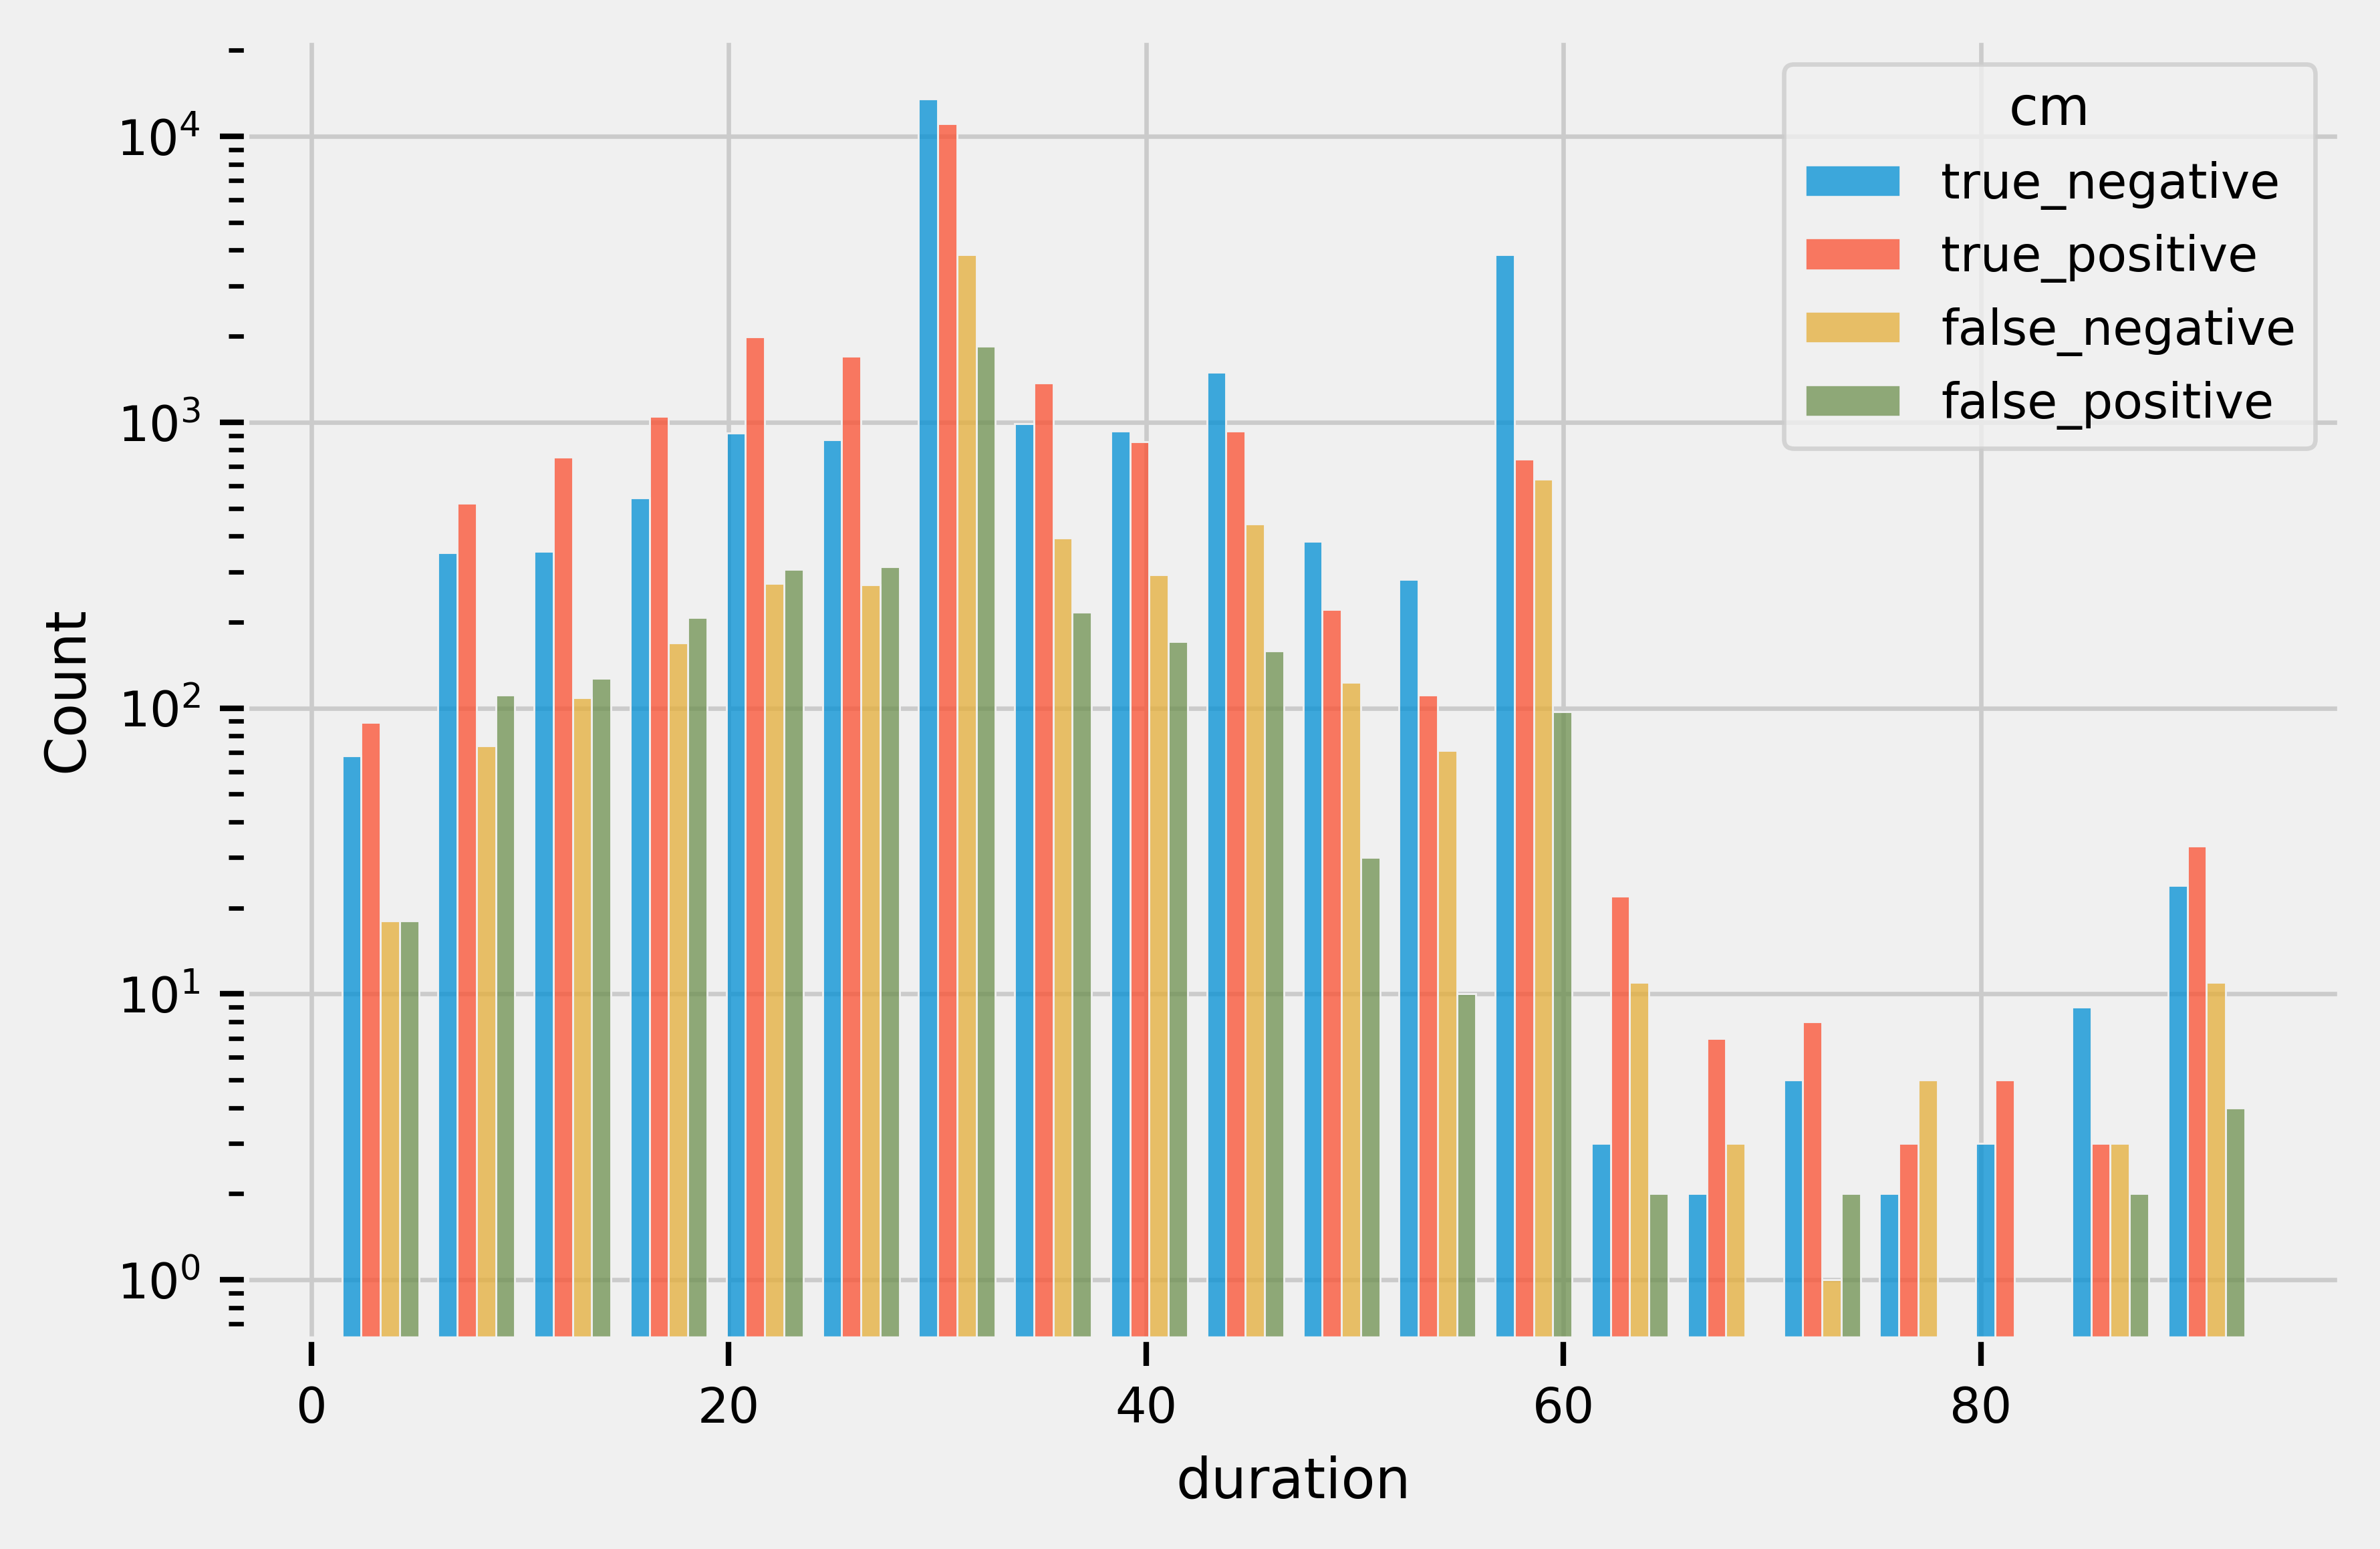

In [219]:
#error plot for the duration

g = sns.histplot(data=test_data_frame, x='duration', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})

(0.0, 2000000.0)

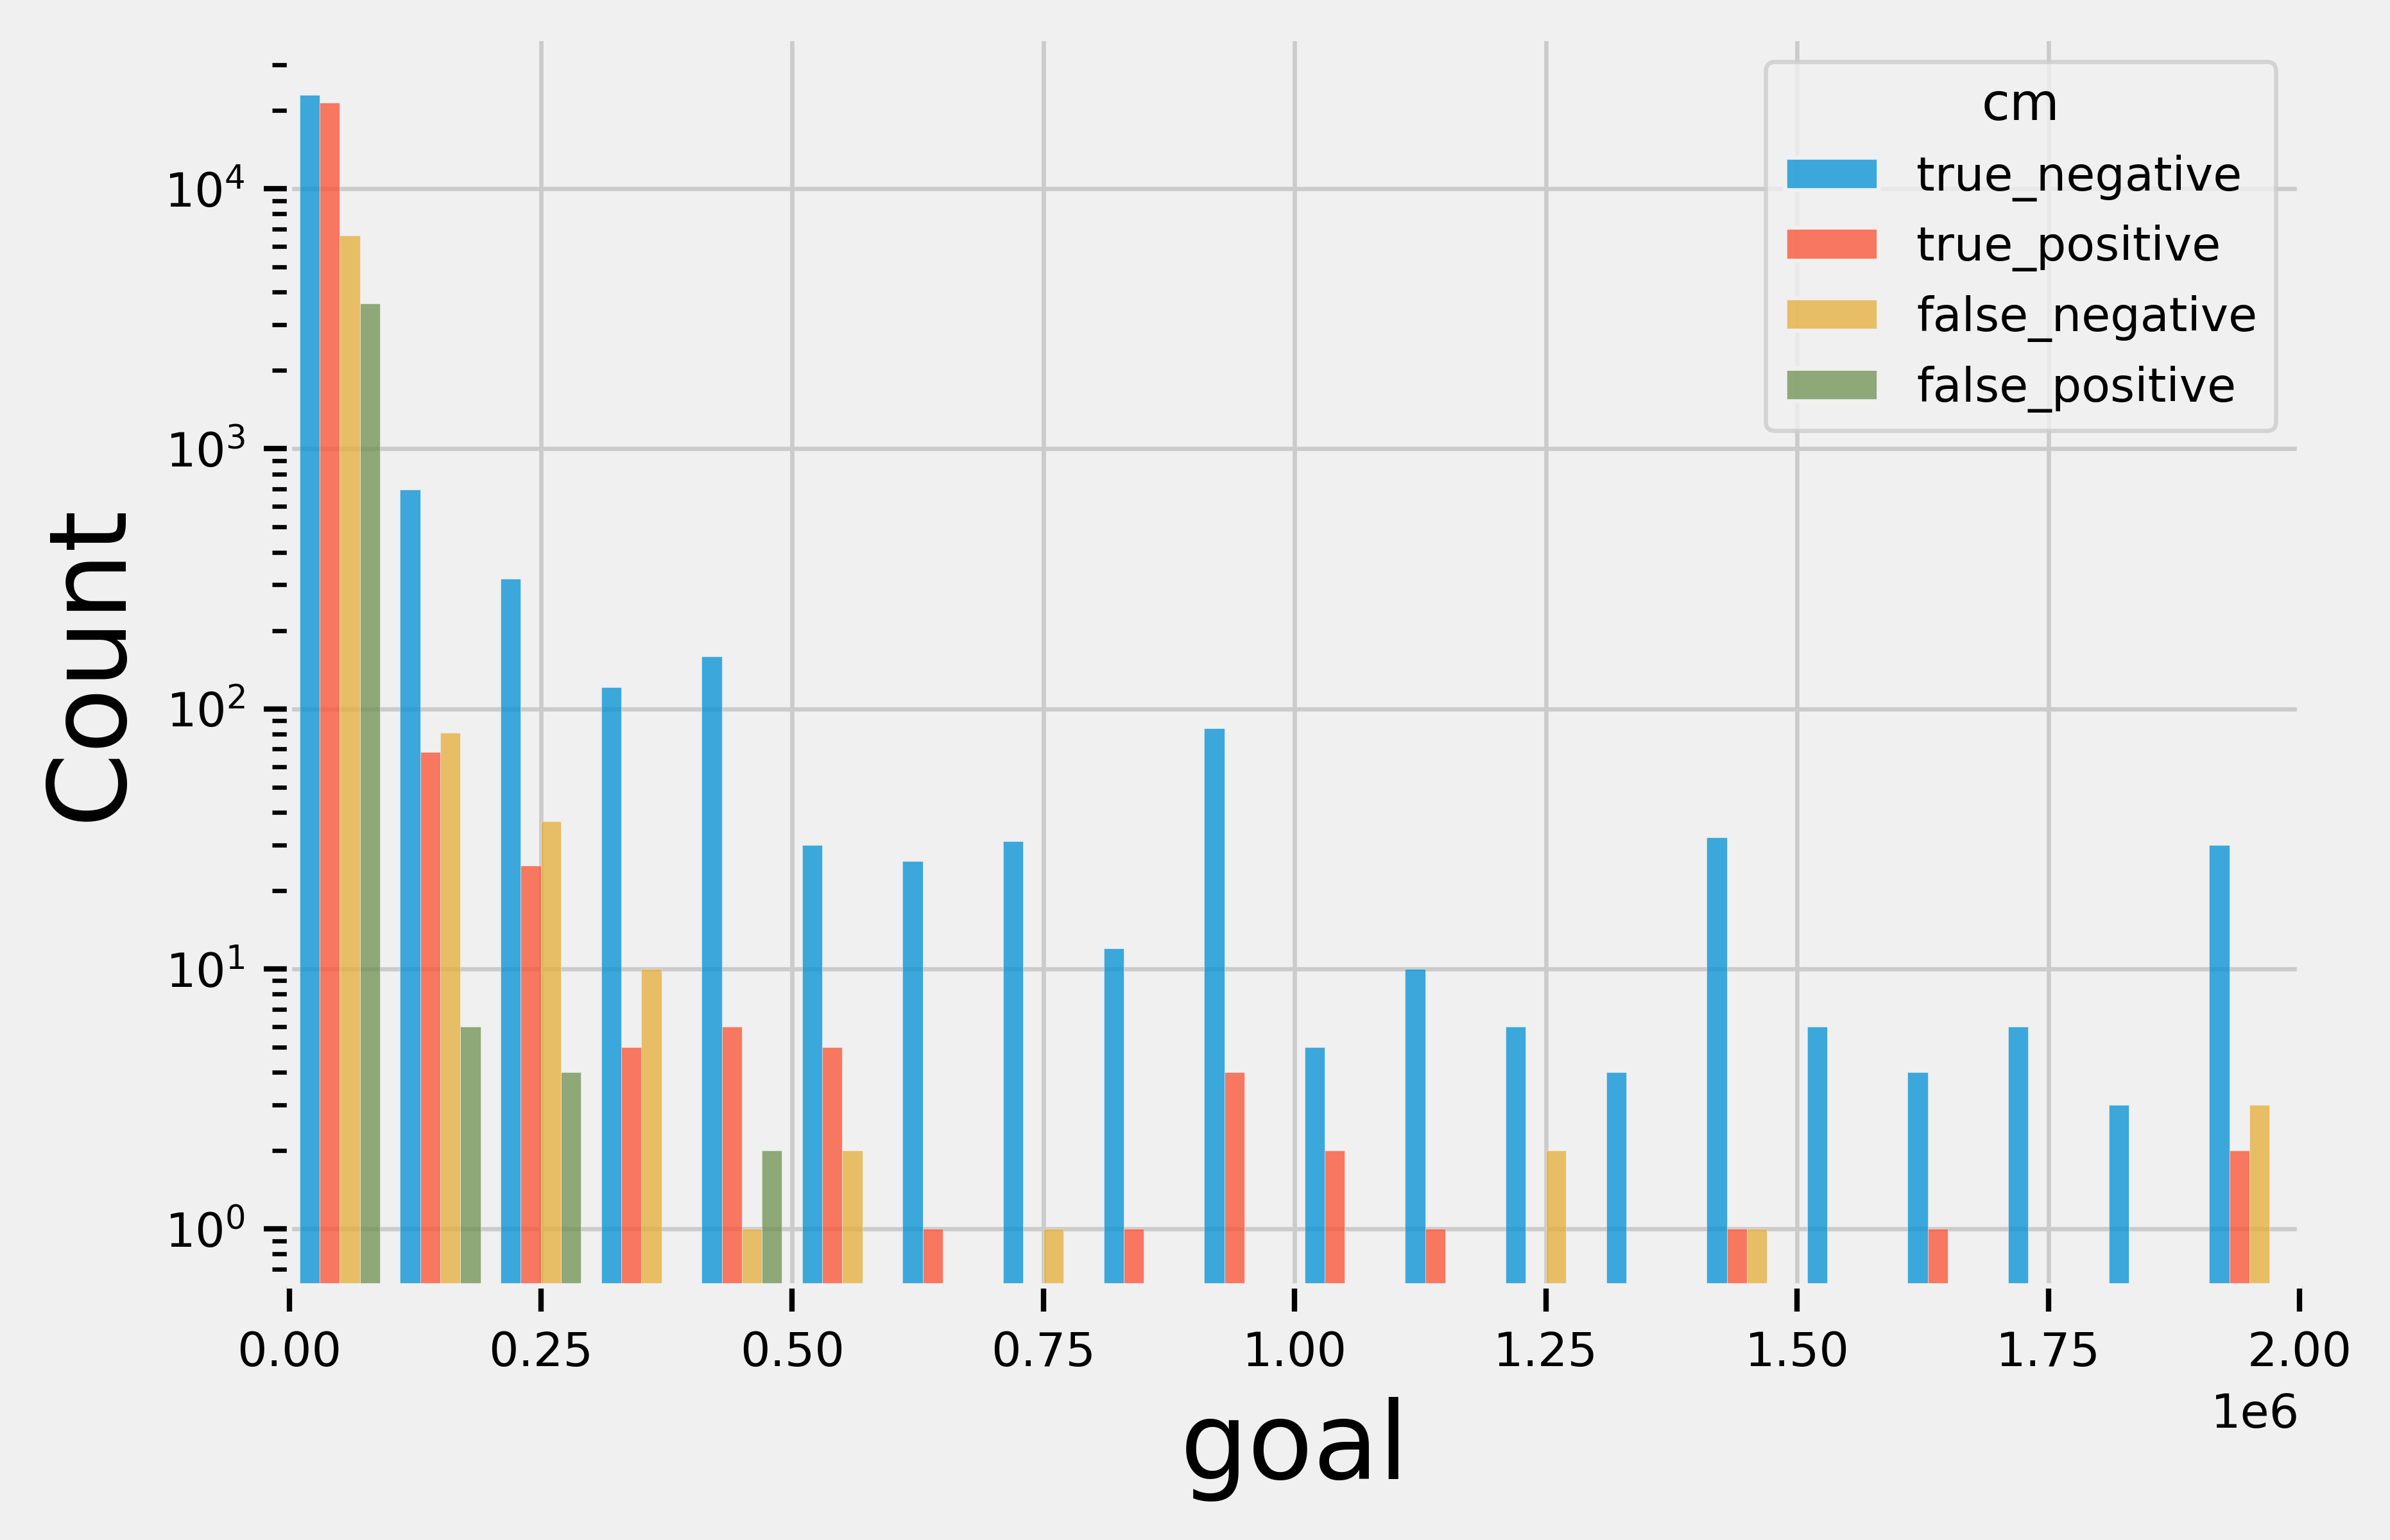

In [229]:
#error plot for the goal
sns.histplot(data=test_data_frame, x='goal', hue='cm', log_scale=(False, 10), bins=100, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})
plt.xlim(0,2000000)

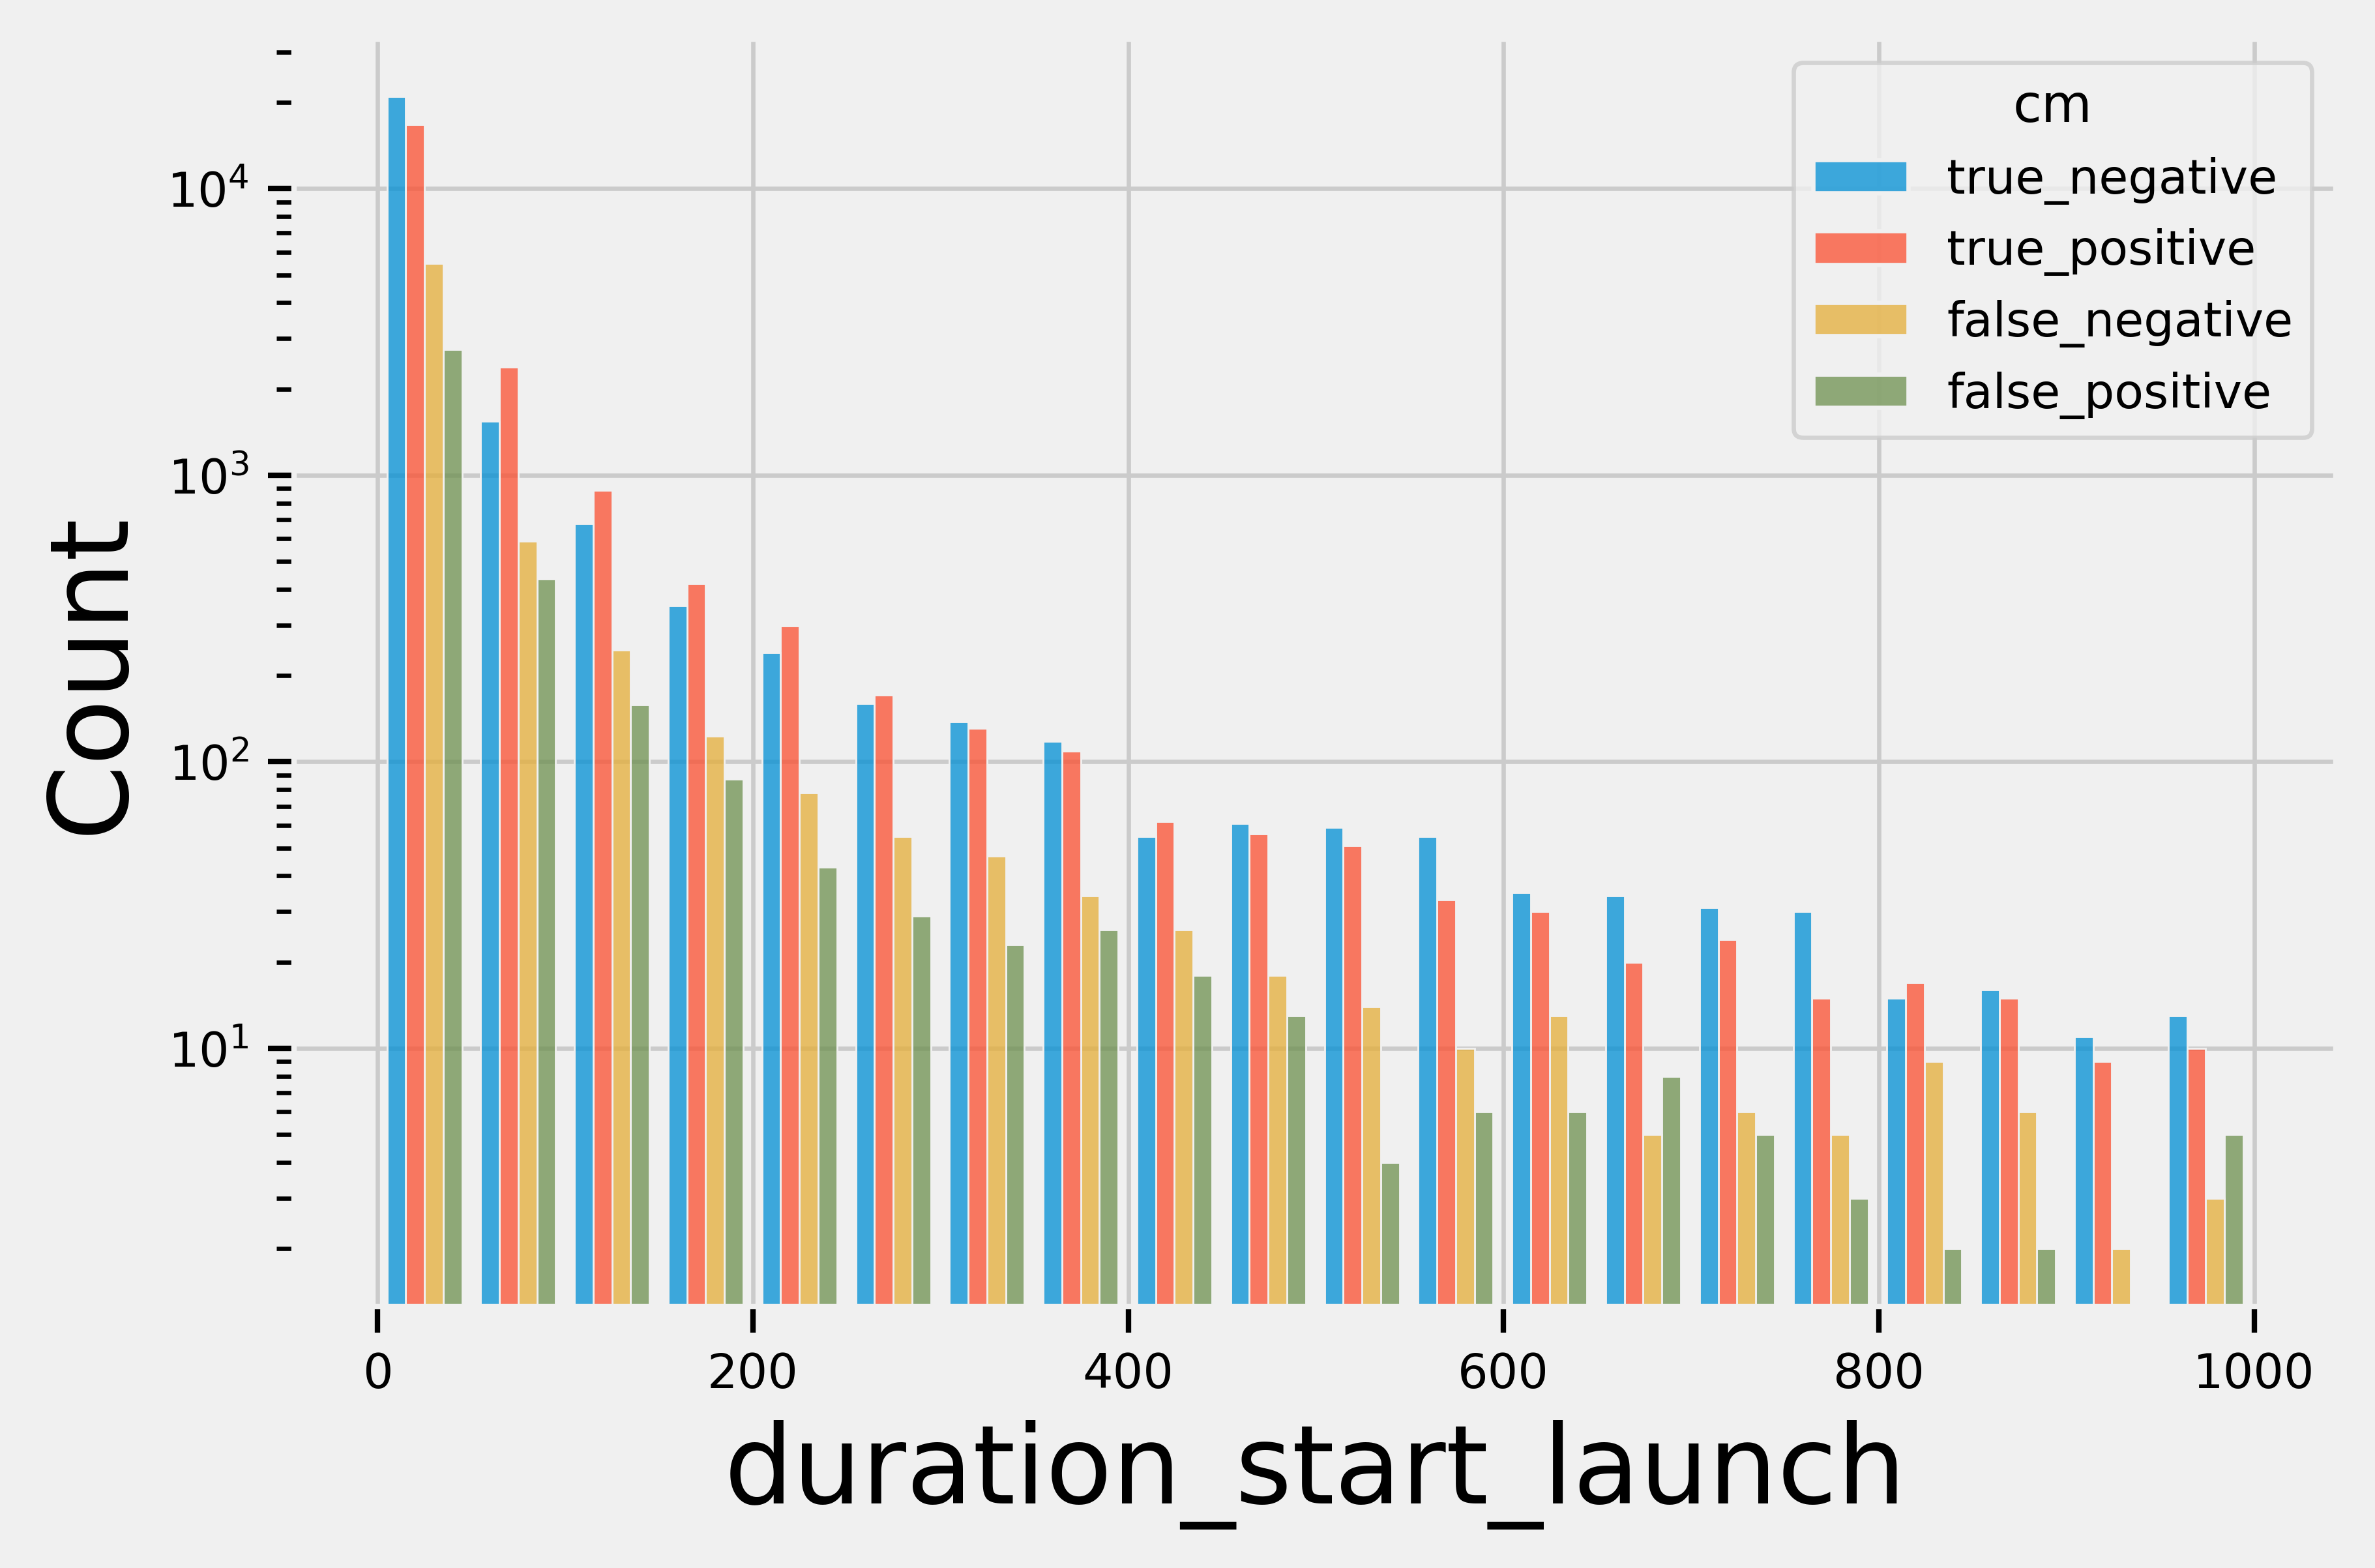

In [231]:
#error plot for the duration_start_launch

g = sns.histplot(data=test_data_frame, x='duration_start_launch', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})

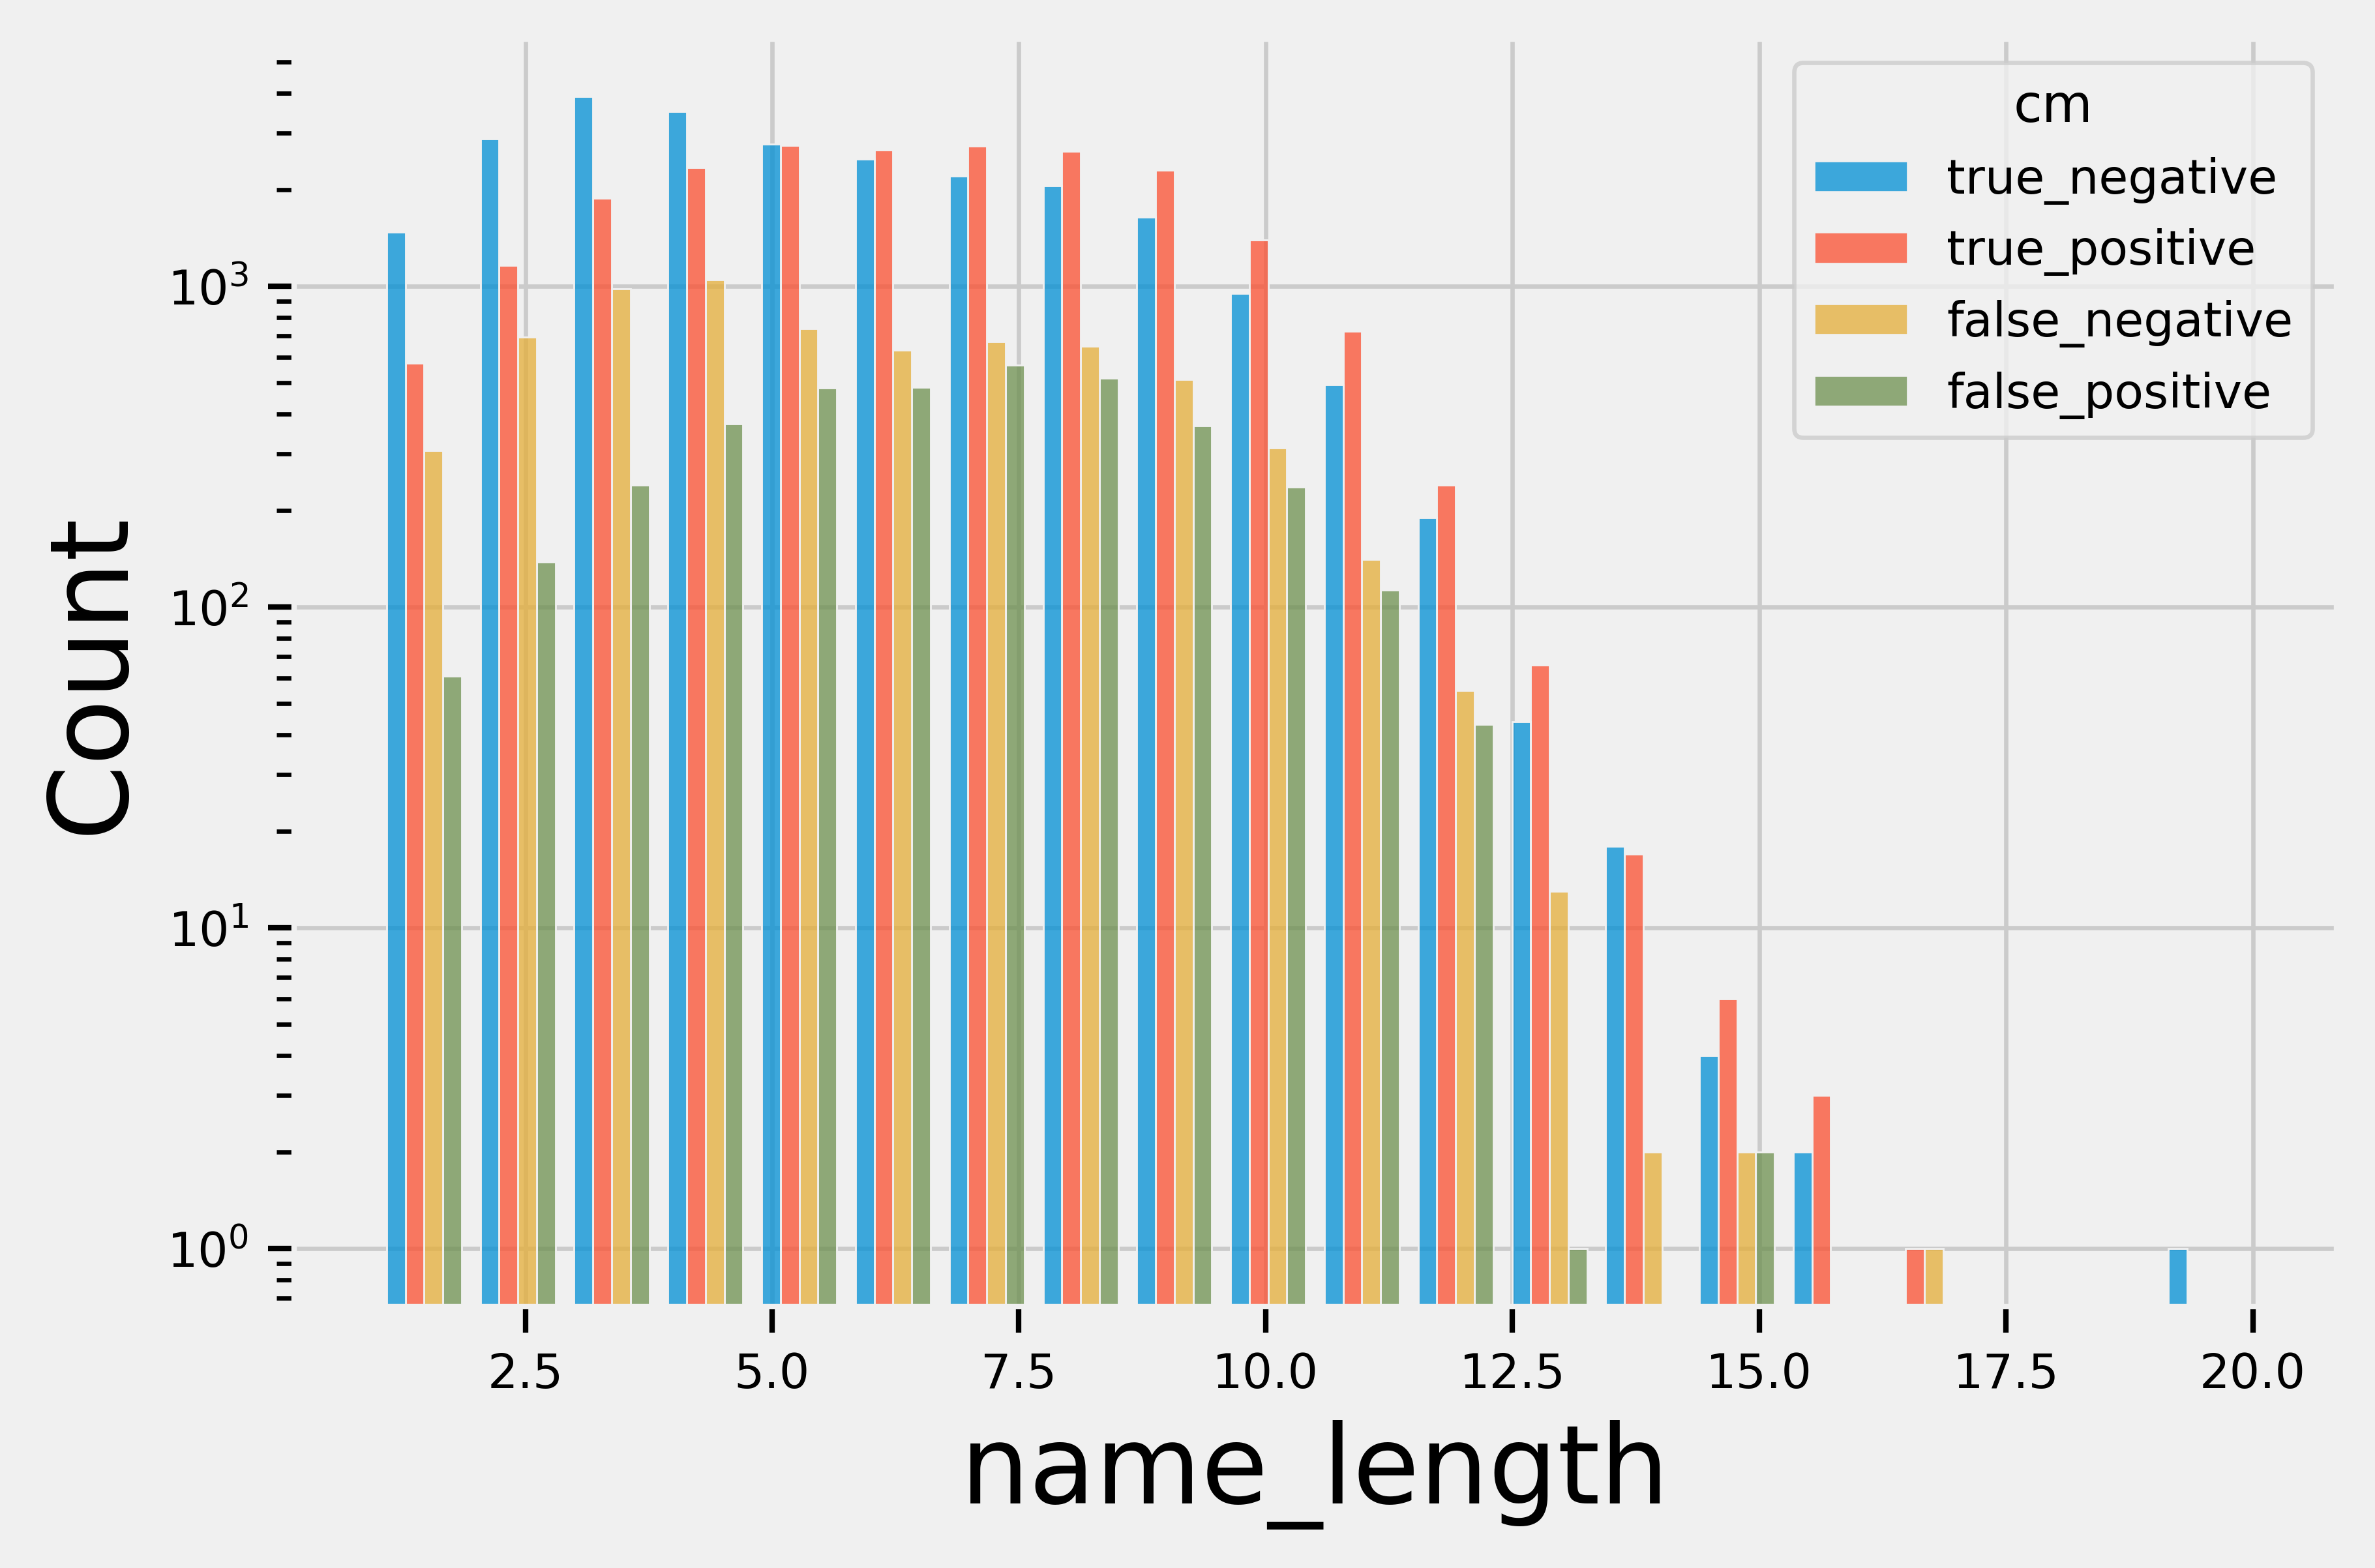

In [232]:
#error plot for the name_length

g = sns.histplot(data=test_data_frame, x='name_length', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})

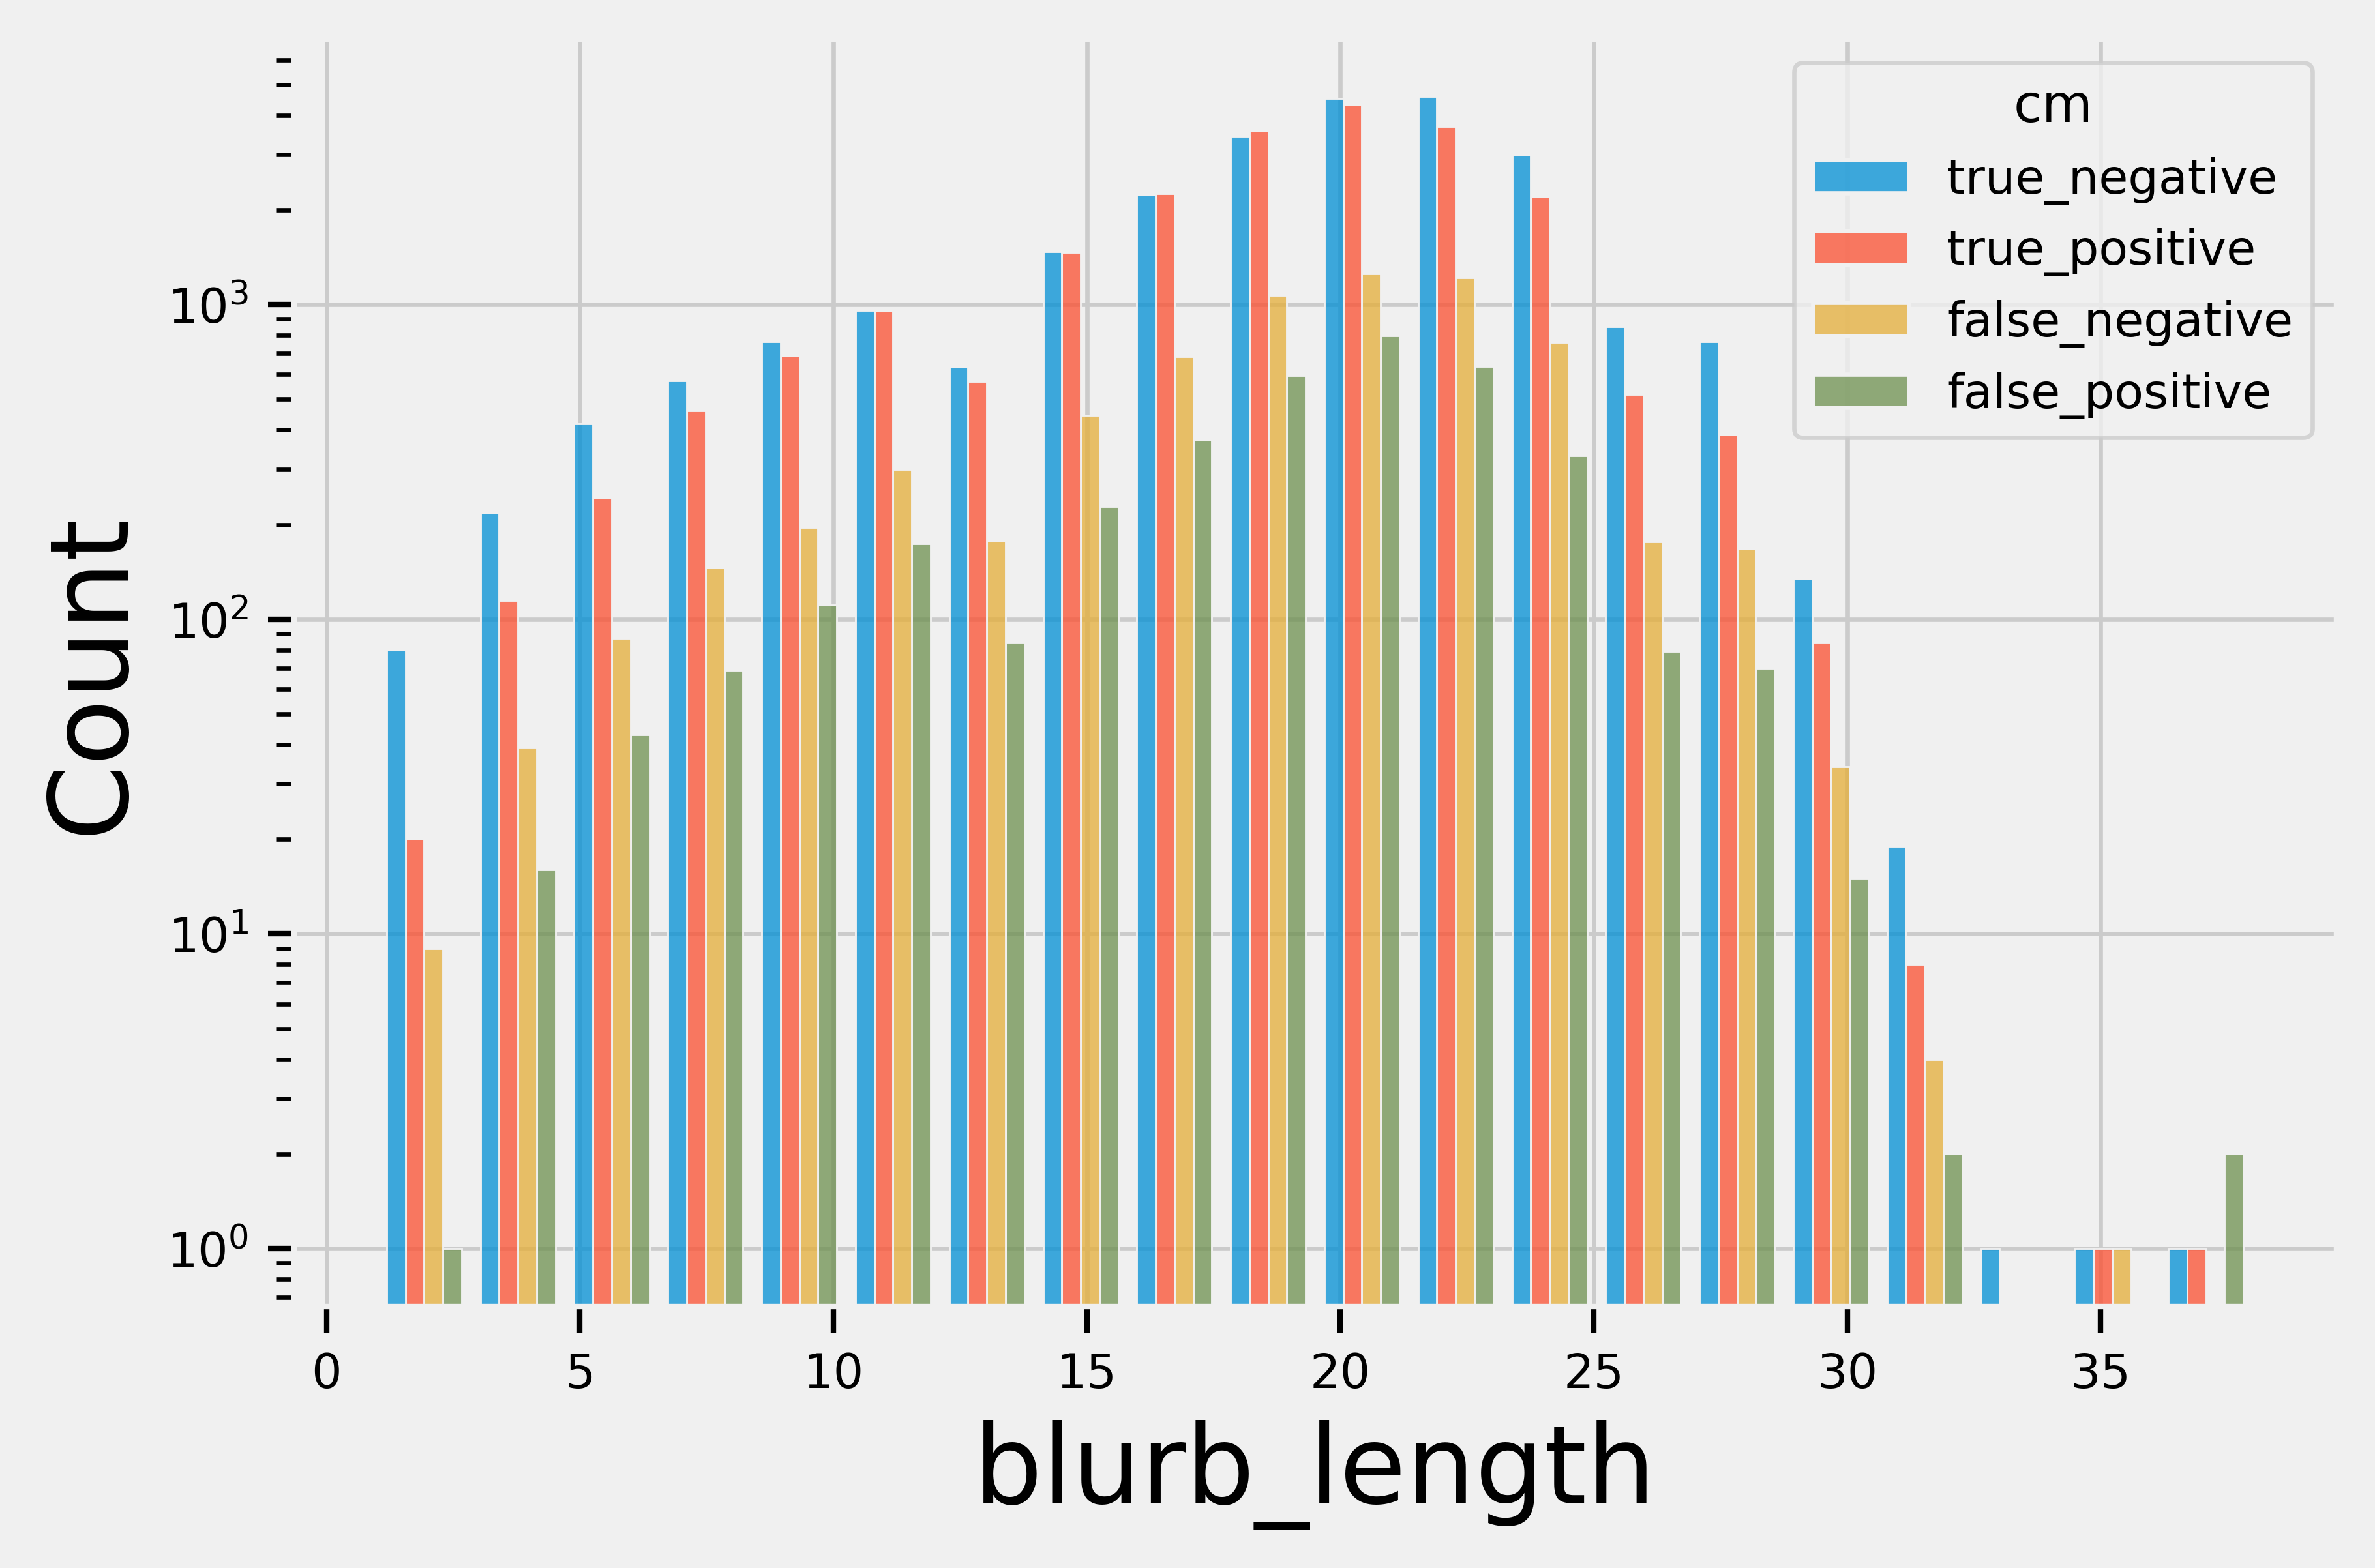

In [246]:
#error plot for the blurb_length

g = sns.histplot(data=test_data_frame, x='blurb_length', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})

In [247]:
test_data_frame

country_AU  country_BE  country_CA  country_CH  country_DE  country_DK  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
56527         1.0         0.0         0.0         0.0         0.0         0.0   
56528         0.0         0.0         0.0         0.0         0.0         0.0   
56529         0.0         0.0         0.0         0.0         0.0         0.0   
56530         0.0         0.0         0.0         0.0         0.0         0.0   
56531         0.0         0.0         0.0         0.0         0.0         0.0   

       country_ES  country_FR  country_GB  country_HK  ...  predicted_success  \
0             0.0         0.0         1.0         0.0  ...                  0   
1             0.0         0.0         0.0         0.0  ...                  1   
2             0.0         0.0         0.0         0.0  ...                  0   
3             0.0         0.0         1.0         0.0  ...                  1   
4             0.0         0.0         1.0         0.0  ...                  0   
...           ...         ...         ...         ...  ...                ...   
56527         0.0         0.0         0.0         0.0  ...                  1   
56528         0.0         0.0         0.0         0.0  ...                  0   
56529         0.0         0.0         0.0         0.0  ...                  1   
56530         0.0         0.0         0.0         0.0  ...                  0   
56531         0.0         0.0         0.0         0.0  ...                  1   

       actual_success              cm      goal   duration  \
0                   0   true_negative   10000.0  30.000000   
1                   1   true_positive    8000.0  30.041667   
2                   1  false_negative    1625.0  30.000000   
3                   1   true_positive    5000.0  31.000000   
4                   1  false_negative  100000.0  30.657234   
...               ...             ...       ...        ...   
56527               1   true_positive    1500.0  30.000000   
56528               1  false_negative    1000.0  59.958333   
56529               1   true_positive   10000.0  29.000000   
56530               0   true_negative  130000.0  60.000000   
56531               1   true_positive    2000.0  29.377558   

       duration_start_launch  goal_per_duration  name_length  name_upper_case  \
0                   7.059769         333.333333          4.0         0.137931   
1                  18.301366         266.296810          6.0         0.178571   
2                   2.028553          54.166667          6.0         0.142857   
3                   3.909491         161.290323          8.0         0.084746   
4                  19.603877        3261.872896          5.0         0.000000   
...                      ...                ...          ...              ...   
56527               0.221852          50.000000          3.0         0.166667   
56528               0.029907          16.678249          9.0         0.142857   
56529               1.992407         344.827586          9.0         0.169492   
56530              97.965671        2166.666667          2.0         0.117647   
56531               2.893113          68.079178          3.0         0.266667   

       blurb_length  
0              21.0  
1              10.0  
2              23.0  
3              21.0  
4              23.0  
...             ...  
56527          24.0  
56528          22.0  
56529          21.0  
56530          21.0  
56531          13.0  

[56532 rows x 213 columns]

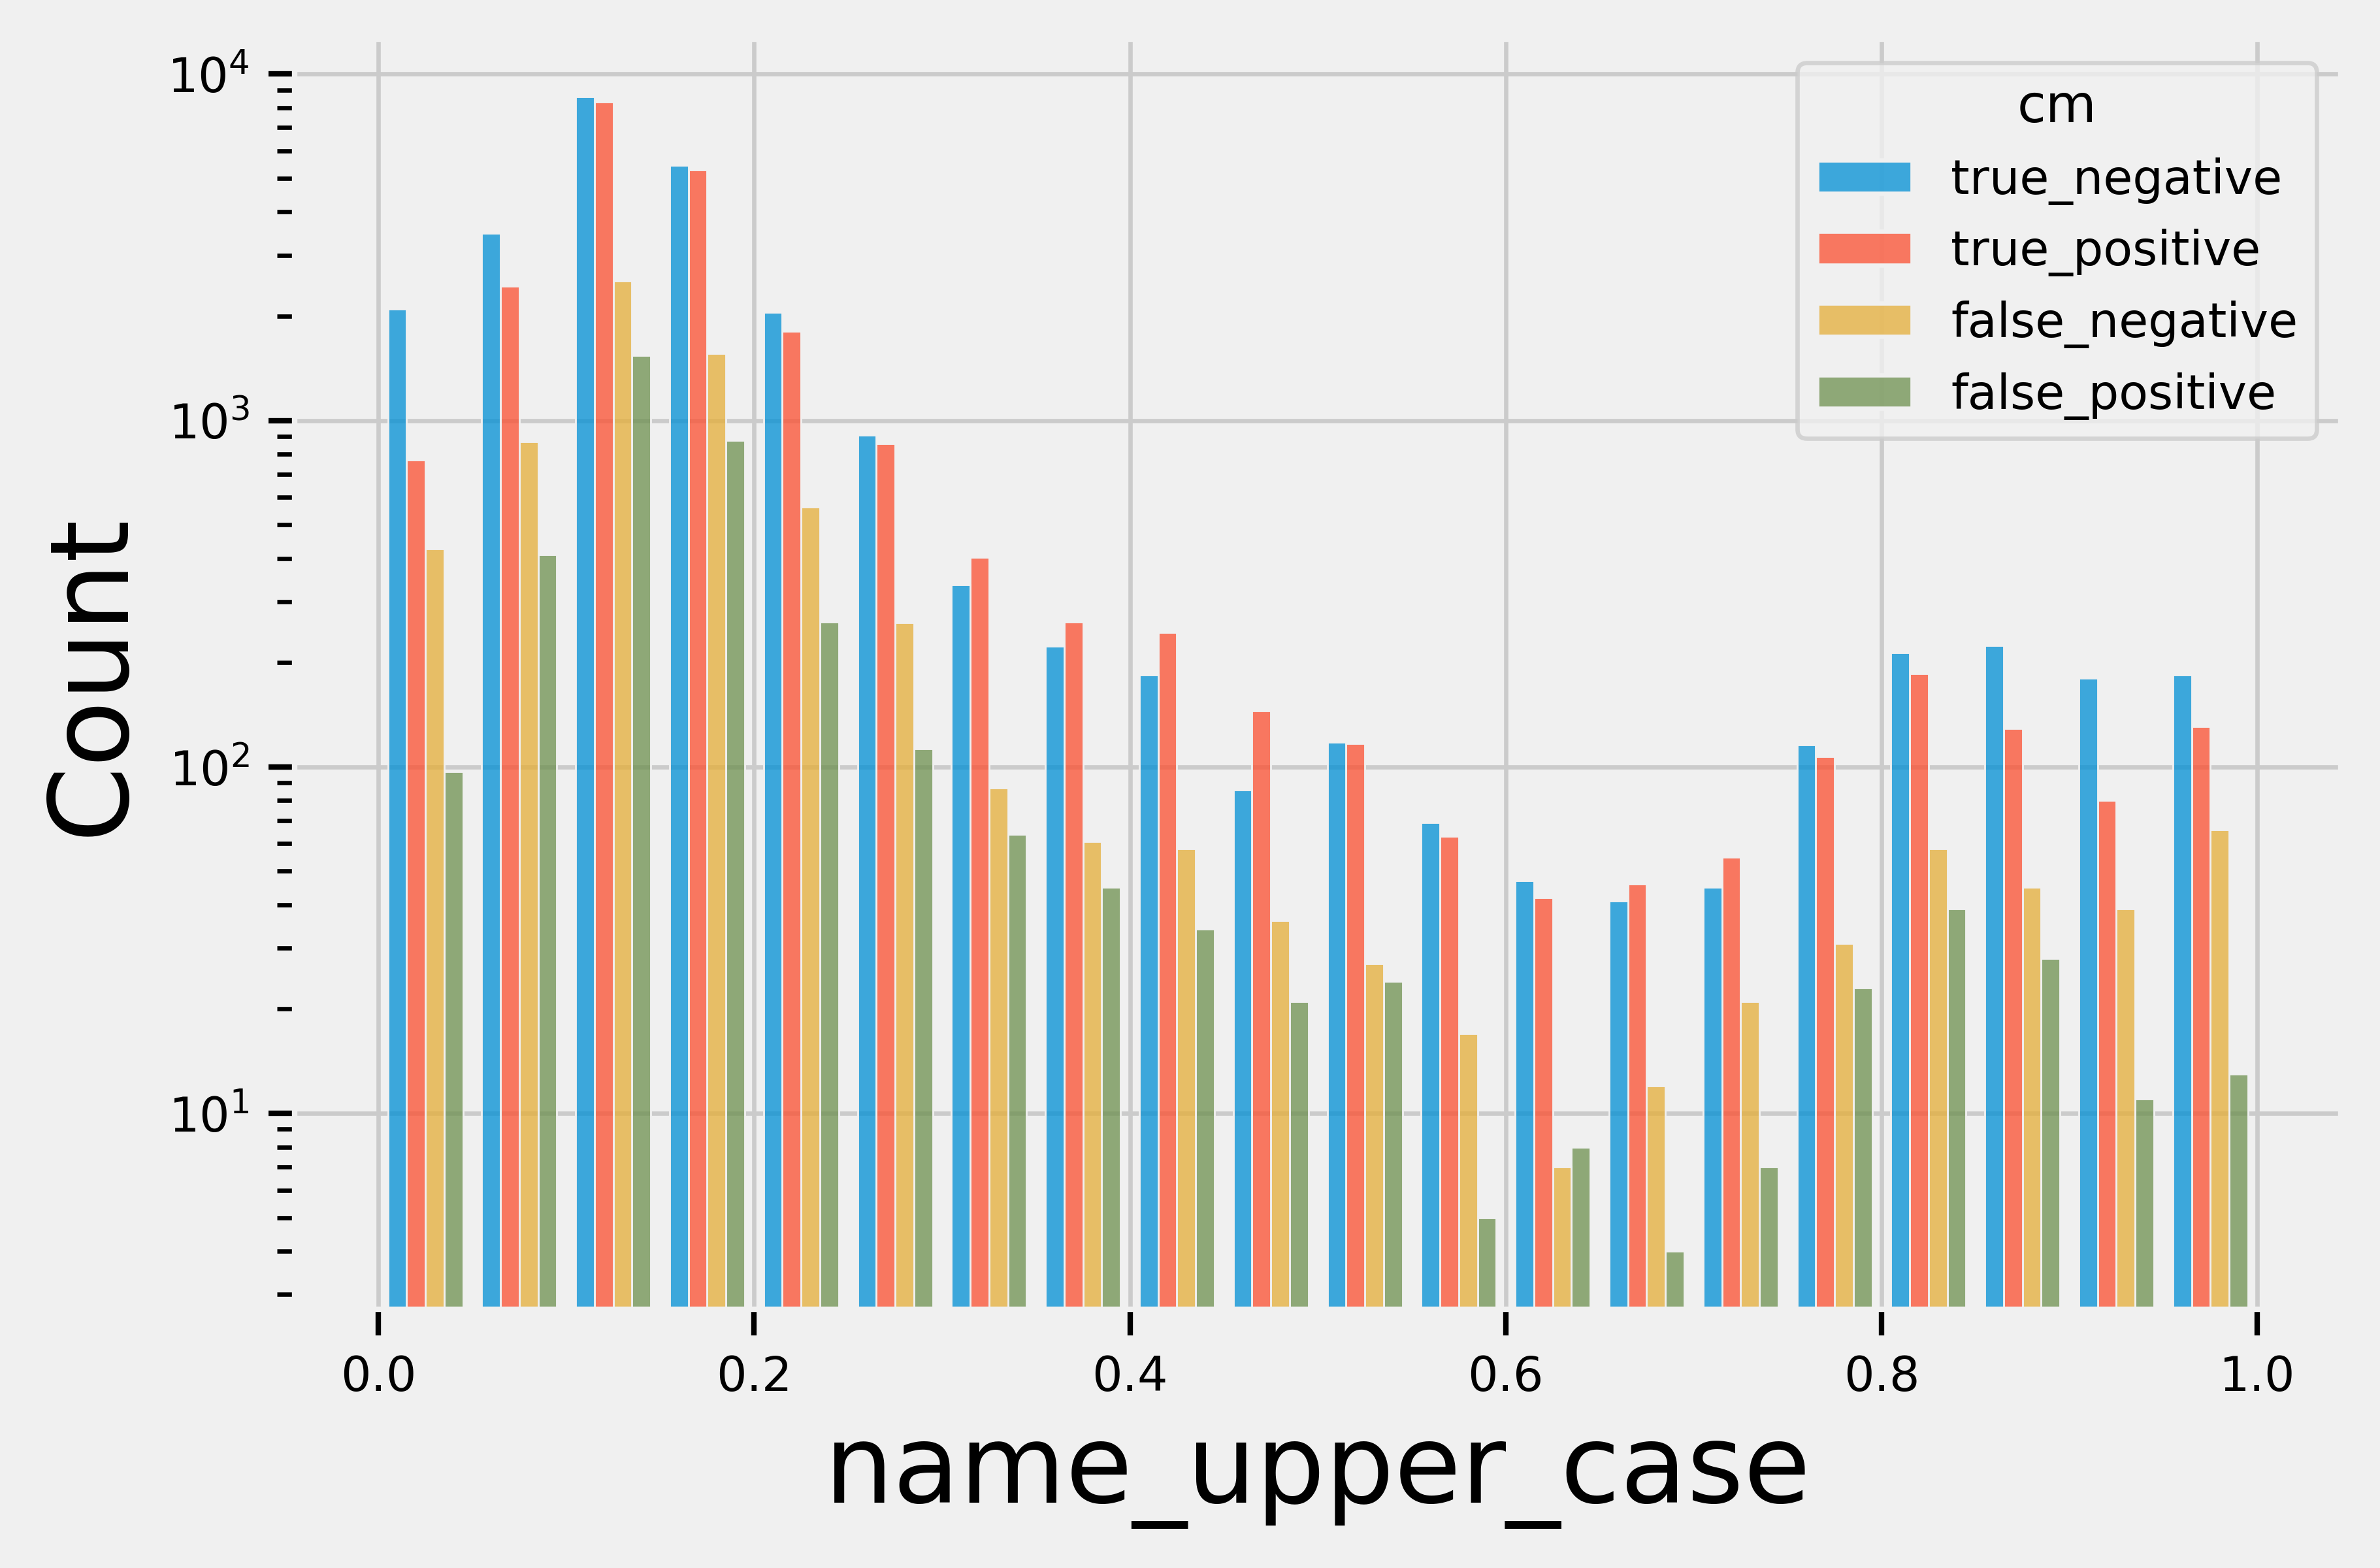

In [248]:
#error plot for the name_upper_case

g = sns.histplot(data=test_data_frame, x='name_upper_case', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
sns.set_context("paper", rc={"axes.labelsize":20})

In [ ]:
#error plot for the name_length
fig, axes = plt.subplots(3,3, sharey=True)
fig.suptitle('A single ax with no data')
#axes[0].set_title('Title of the first chart')

sns.histplot(ax=axes[0][0],data=test_data_frame, x='name_length', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
#sns.set_context("paper", rc={"axes.labelsize":20})

#error plot for the name_length

sns.histplot(ax=axes[0][1],data=test_data_frame, x='duration', hue='cm', log_scale=(False, 10), bins=20, multiple="dodge", shrink=0.8)
#sns.set_context("paper", rc={"axes.labelsize":20})

------

In [286]:
len(features_dummies)
type(clf_rf.feature_importances_)
rf_fi = [(x, y) for x,y in zip(features_dummies,clf_rf.feature_importances_)]
rf_fi = sorted(rf_fi, key=lambda x : x[1], reverse=True)
for i in rf_fi[0:10]:
    print(f'{i[1]}:\t{i[0]}')

#print(rf_fi)

0.10489049733320484:	duration_start_launch
0.08987136523023802:	name_upper_case
0.07670795388423551:	goal
0.07037151042180965:	duration
0.05630800604573586:	blurb_length
0.0532472760612361:	goal_per_duration
0.04459143620807179:	name_length
0.016229092853071152:	category_name_Printing
0.015870431748906545:	category_name_Digital Art
0.013913780753513754:	category_name_Sculpture


2. XGBoost

[11:34:19] WARNING: /private/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/pip-install-mi2n0a_o/xgboost_38d03cb6f6d64205821378f63f122808/build/temp.macosx-11.2-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy_score 0.7888843648208469
f1-score 0.777579180667763
Confusion matrix, without normalization
[[6187 1181]
 [1930 5438]]


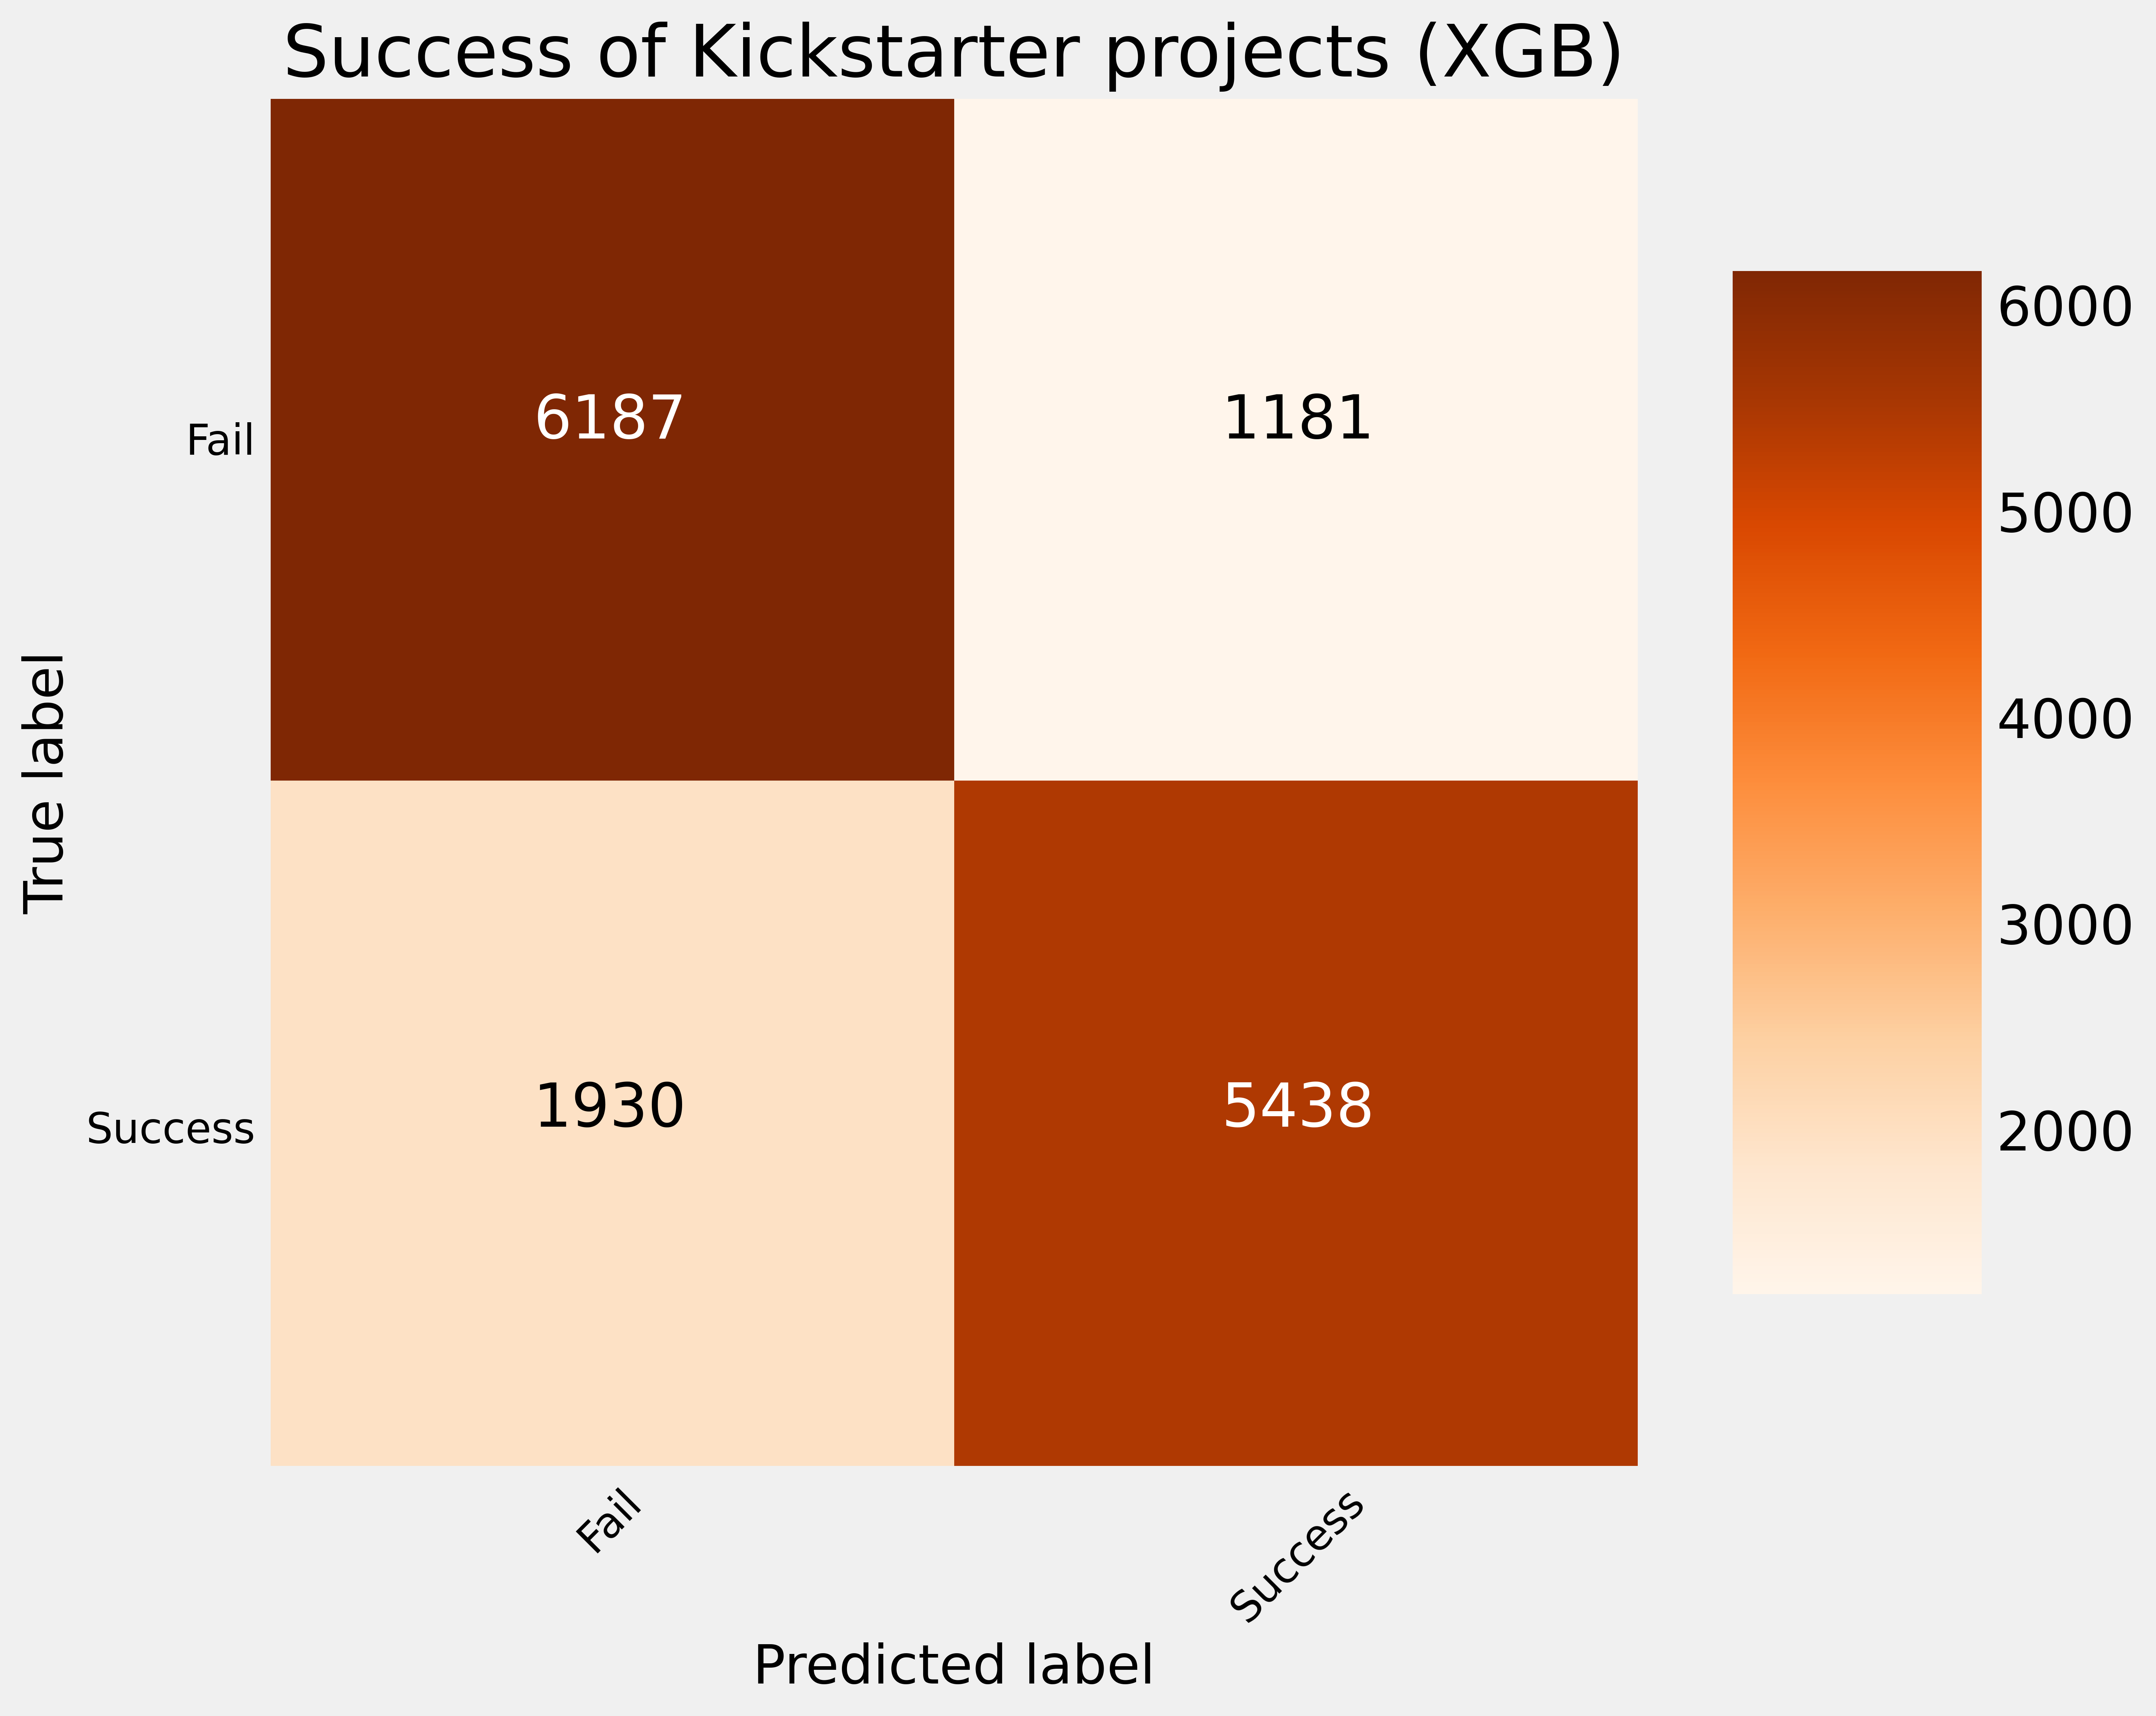

In [287]:
from xgboost import XGBClassifier 
clf_xgb = XGBClassifier( 
    n_estimators=100,
    #max_depth=20, 
    n_jobs=-1
)
y_pred_xgb = clf_train_predict(clf_xgb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_xgb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (XGB)'
)

3. Naive Bayes

accuracy_score 0.5553067318132465
f1-score 0.688974322464284
Confusion matrix, without normalization
[[ 925 6443]
 [ 110 7258]]


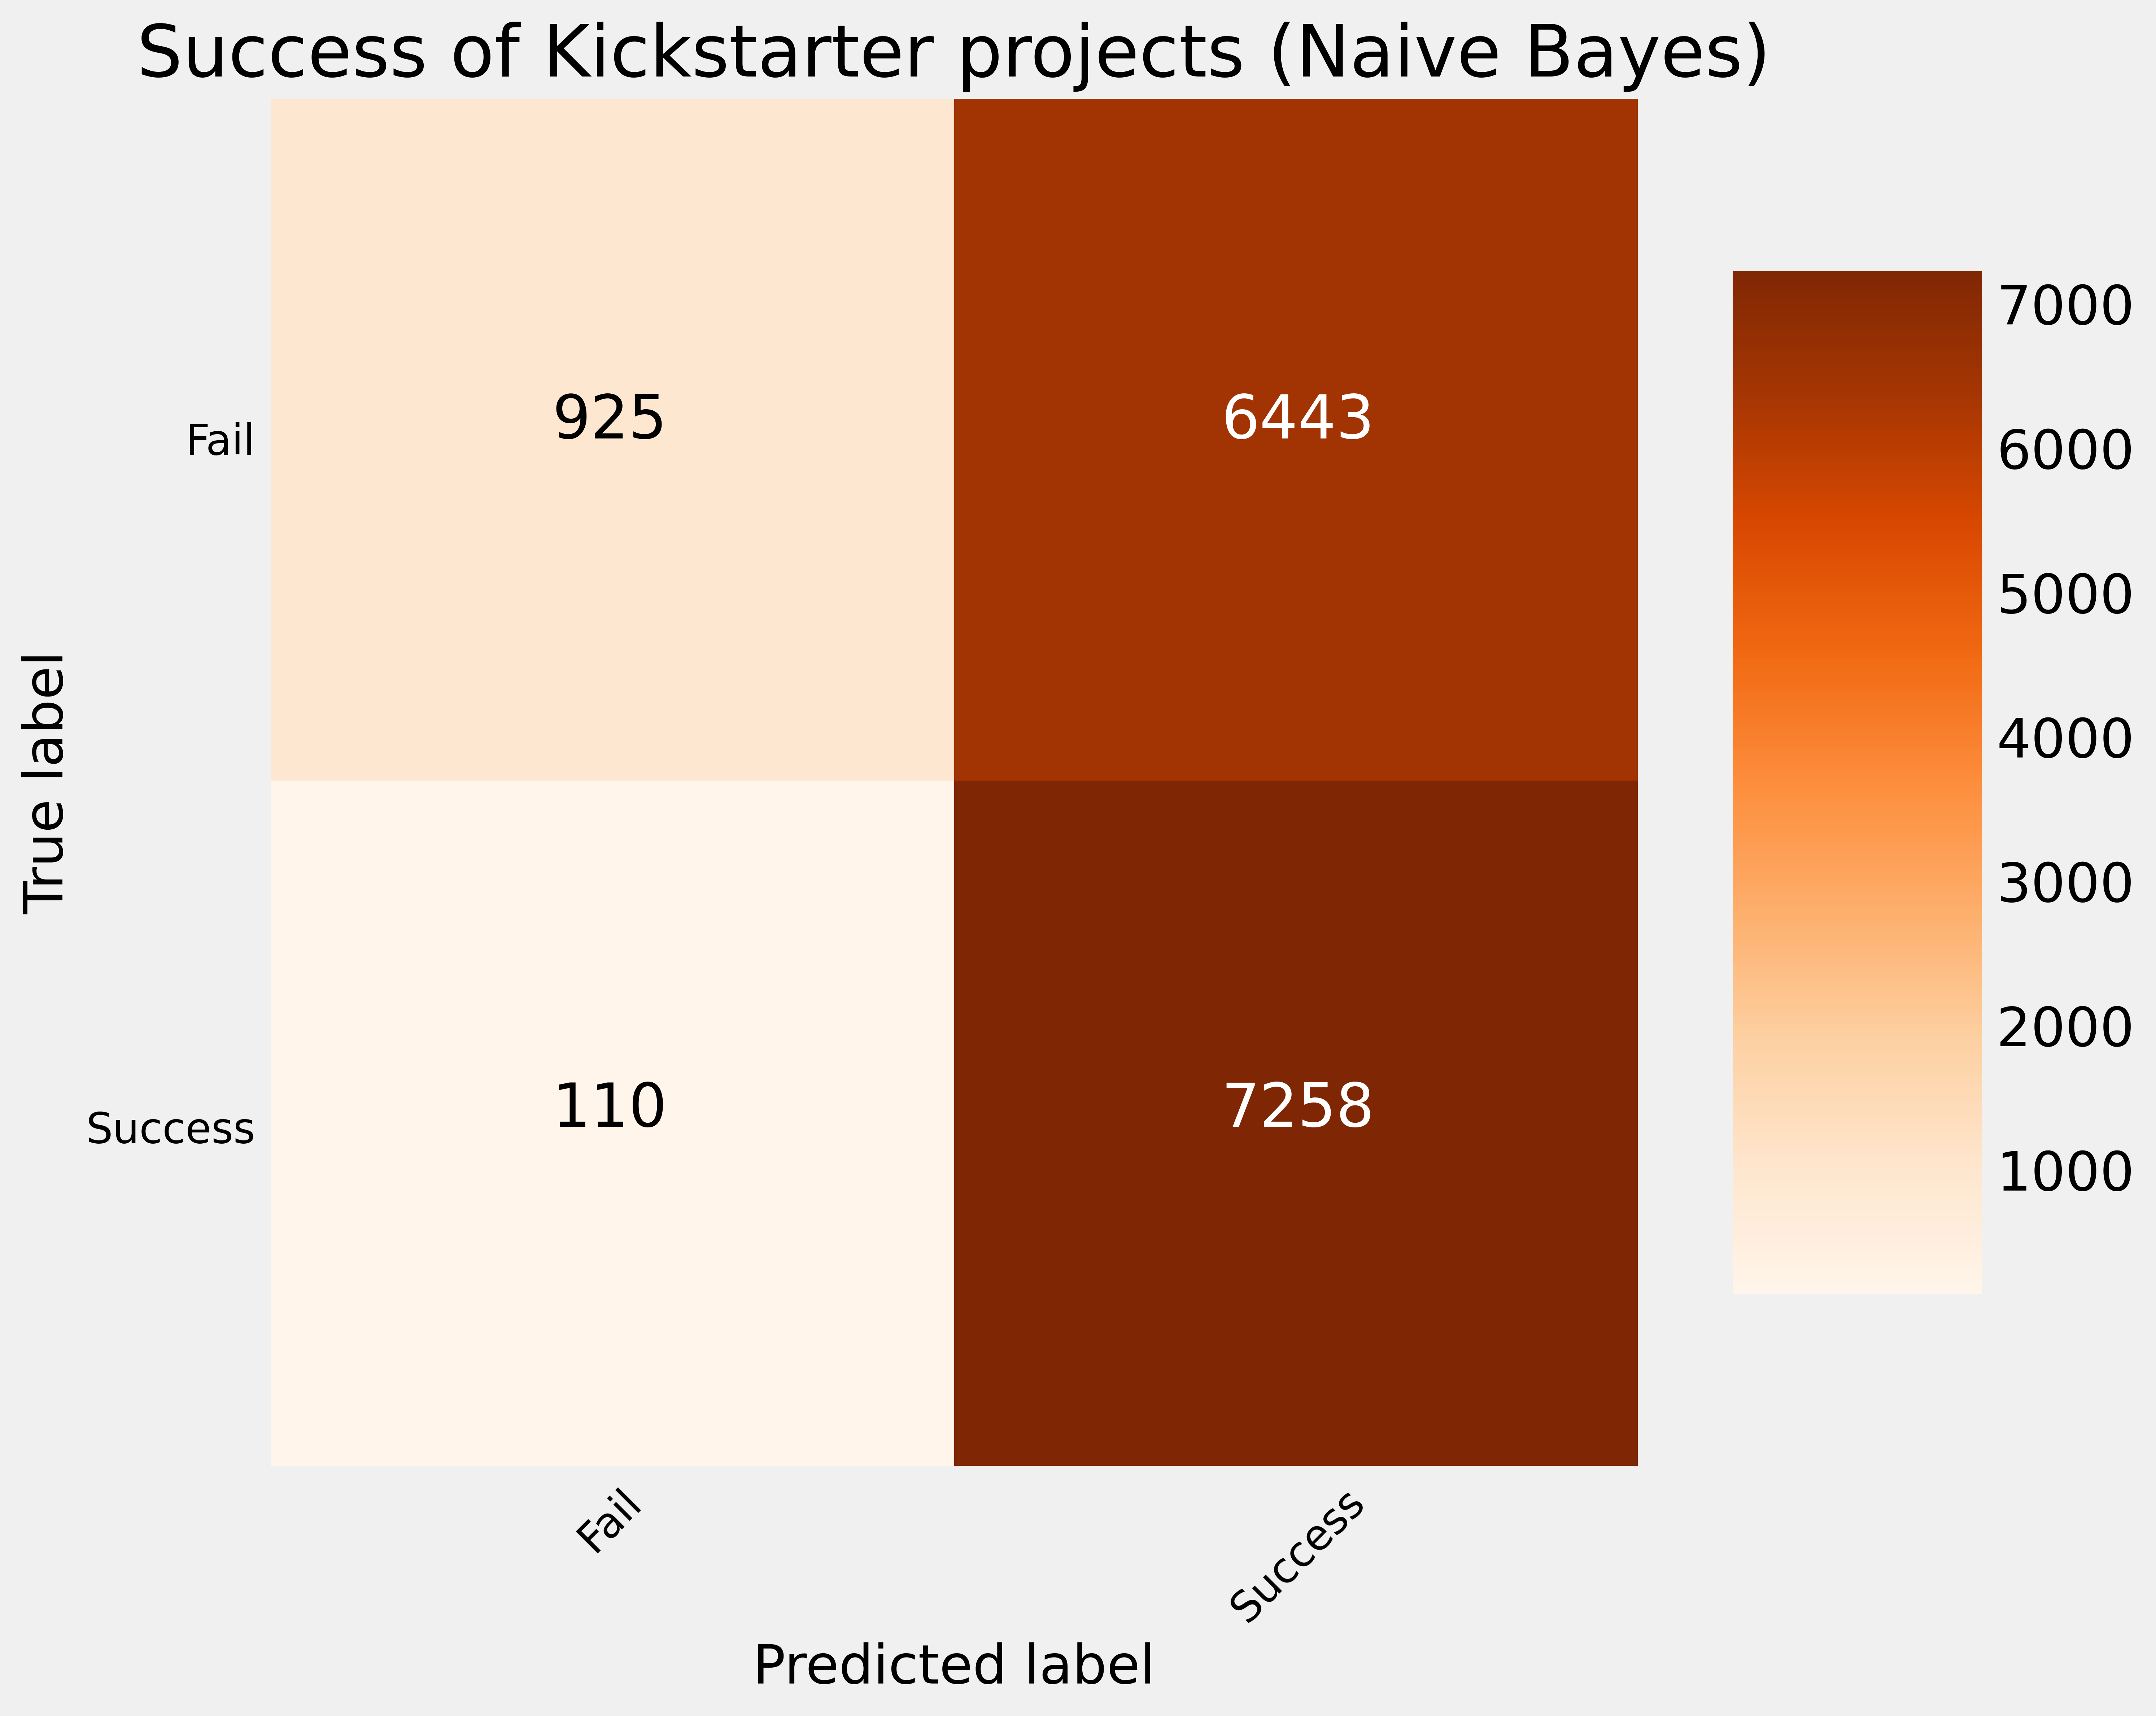

In [288]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
y_pred_gnb = clf_train_predict(clf_gnb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_gnb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Naive Bayes)'
)

4. SVM / SGDClassifier

accuracy_score 0.5831297502714441
f1-score 0.6708813286900616
Confusion matrix, without normalization
[[2332 5036]
 [1107 6261]]


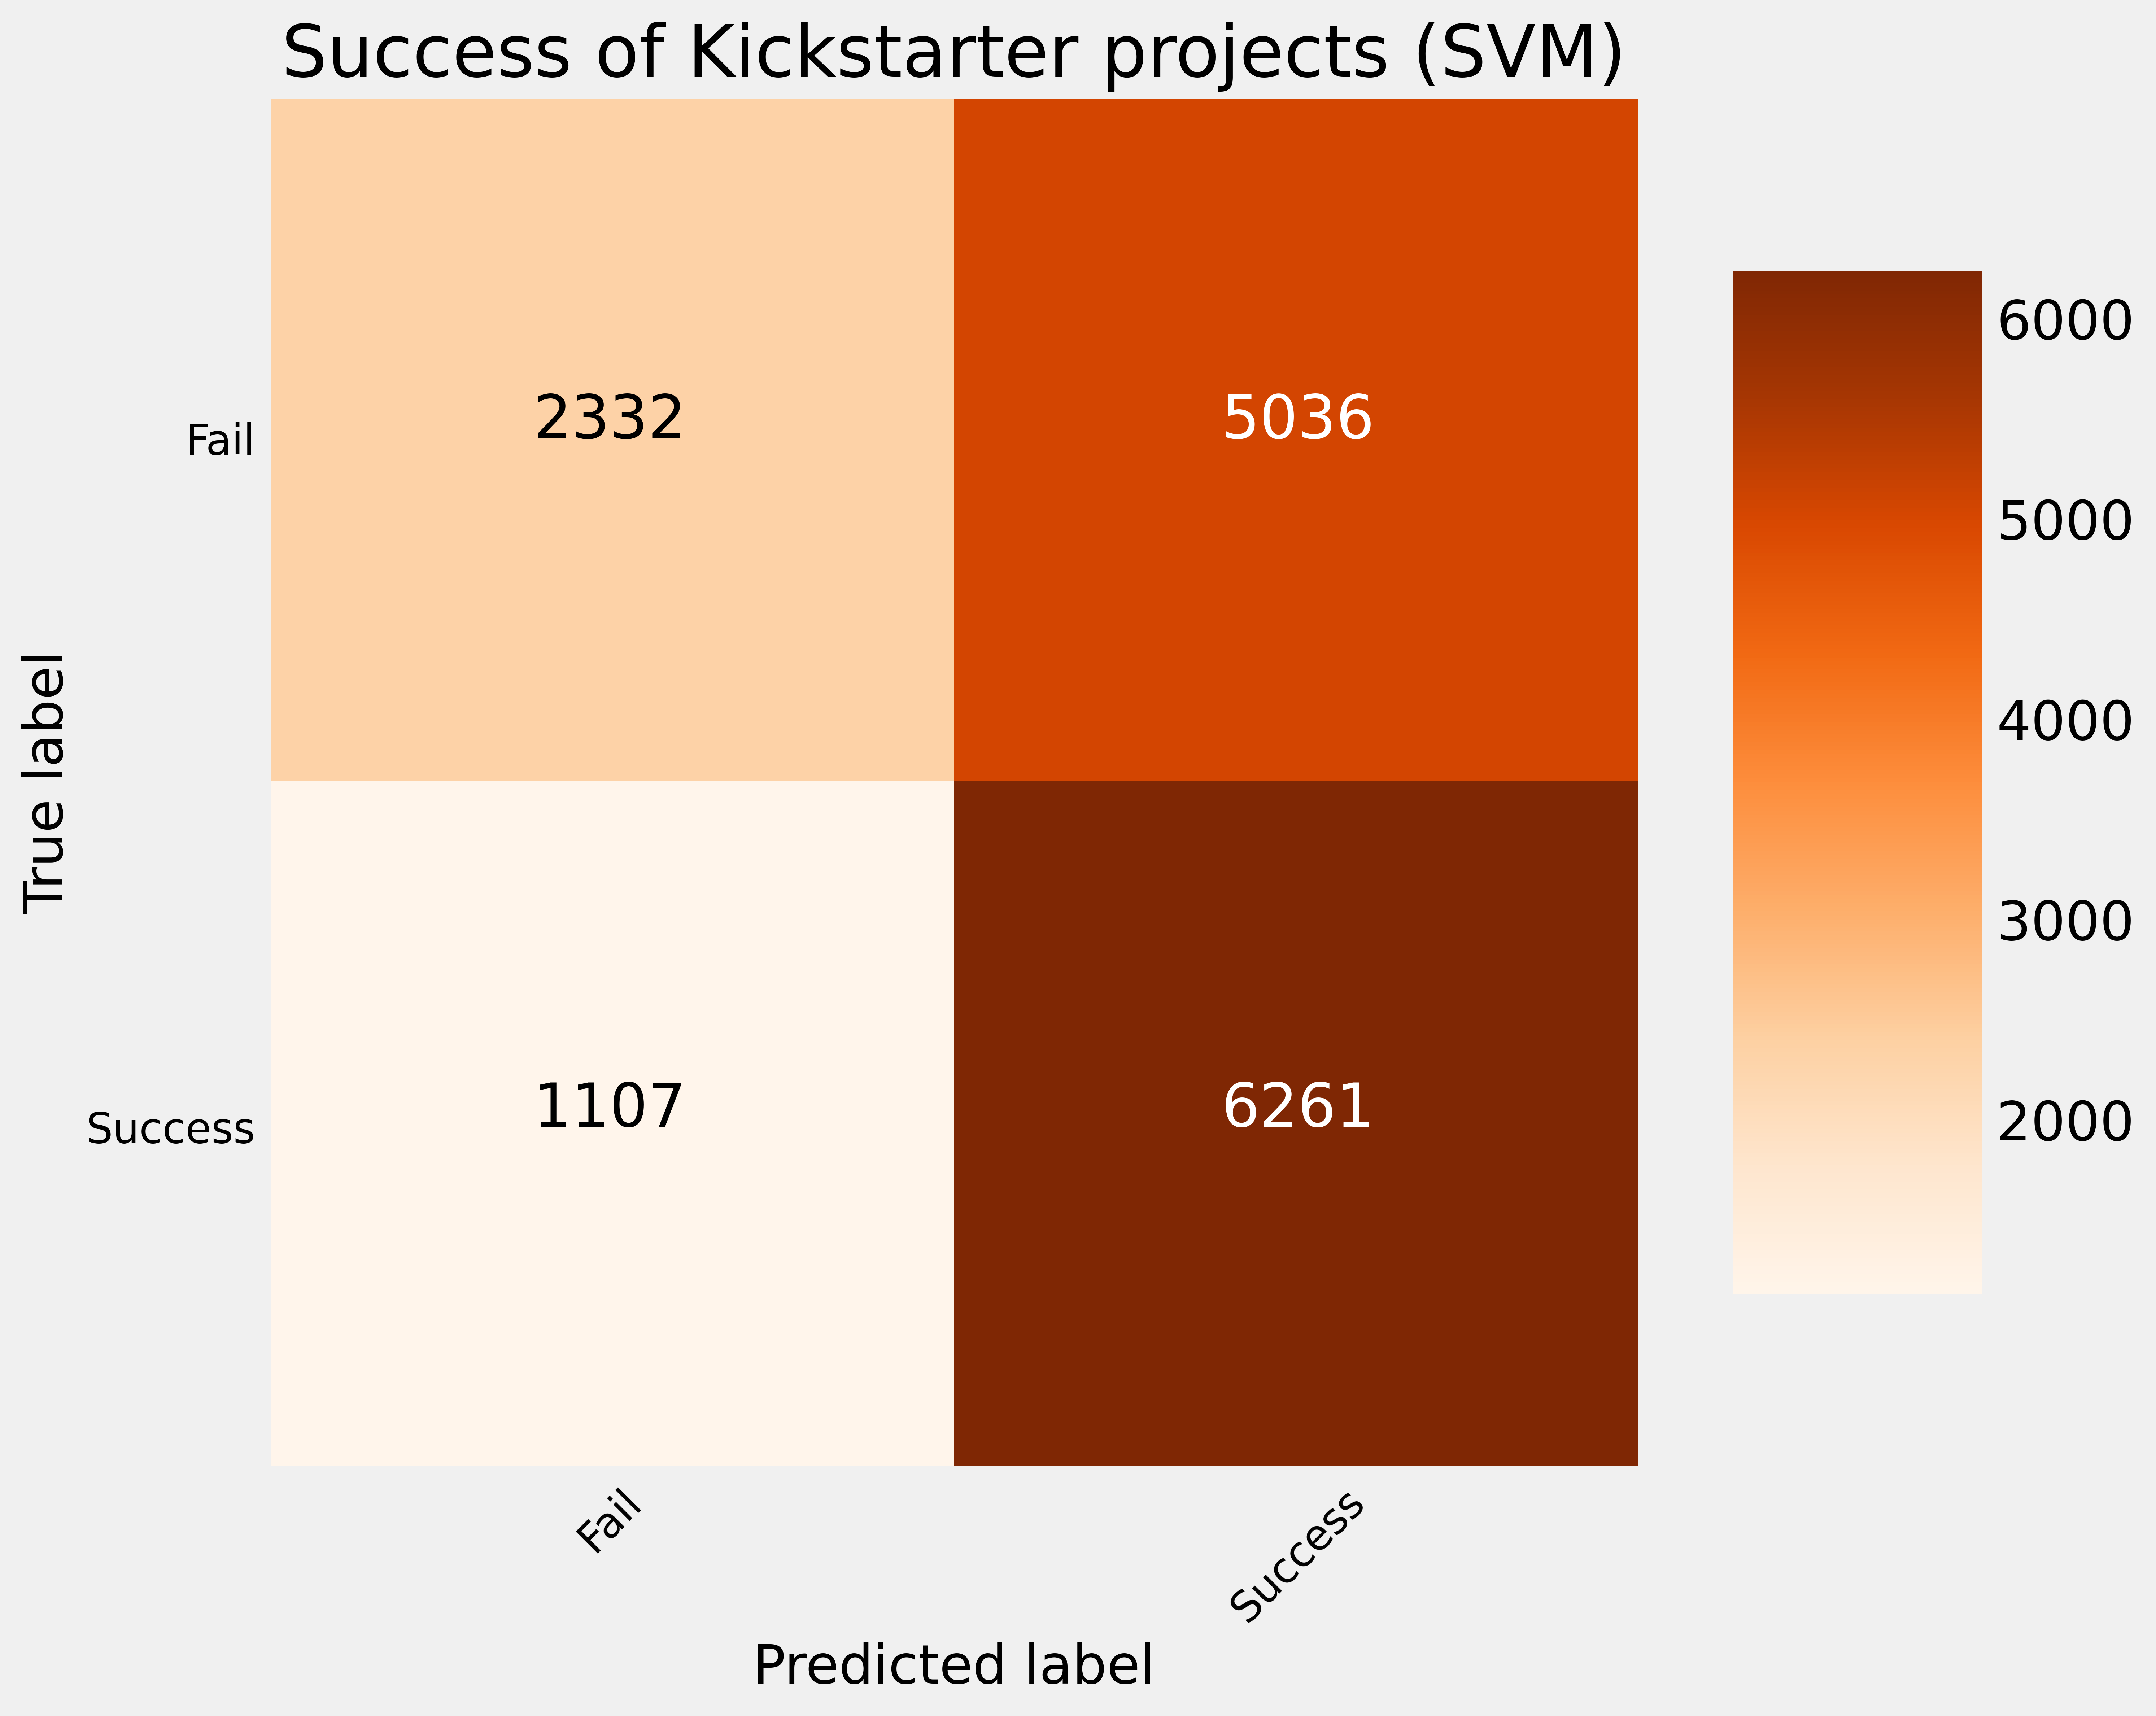

In [289]:
#SGDClassifier (hinge = linear SVC)
from sklearn.linear_model import SGDClassifier
clf_sgd = SGDClassifier(loss='hinge')
y_pred_sgd = clf_train_predict(clf_sgd, train, train_label, test)
cm = simple_metrics(test_label, y_pred_sgd)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (SVM)'
)

Logistic Regression

accuracy_score 0.7572611292073833
f1-score 0.7383129709561782
Confusion matrix, without normalization
[[6113 1255]
 [2322 5046]]


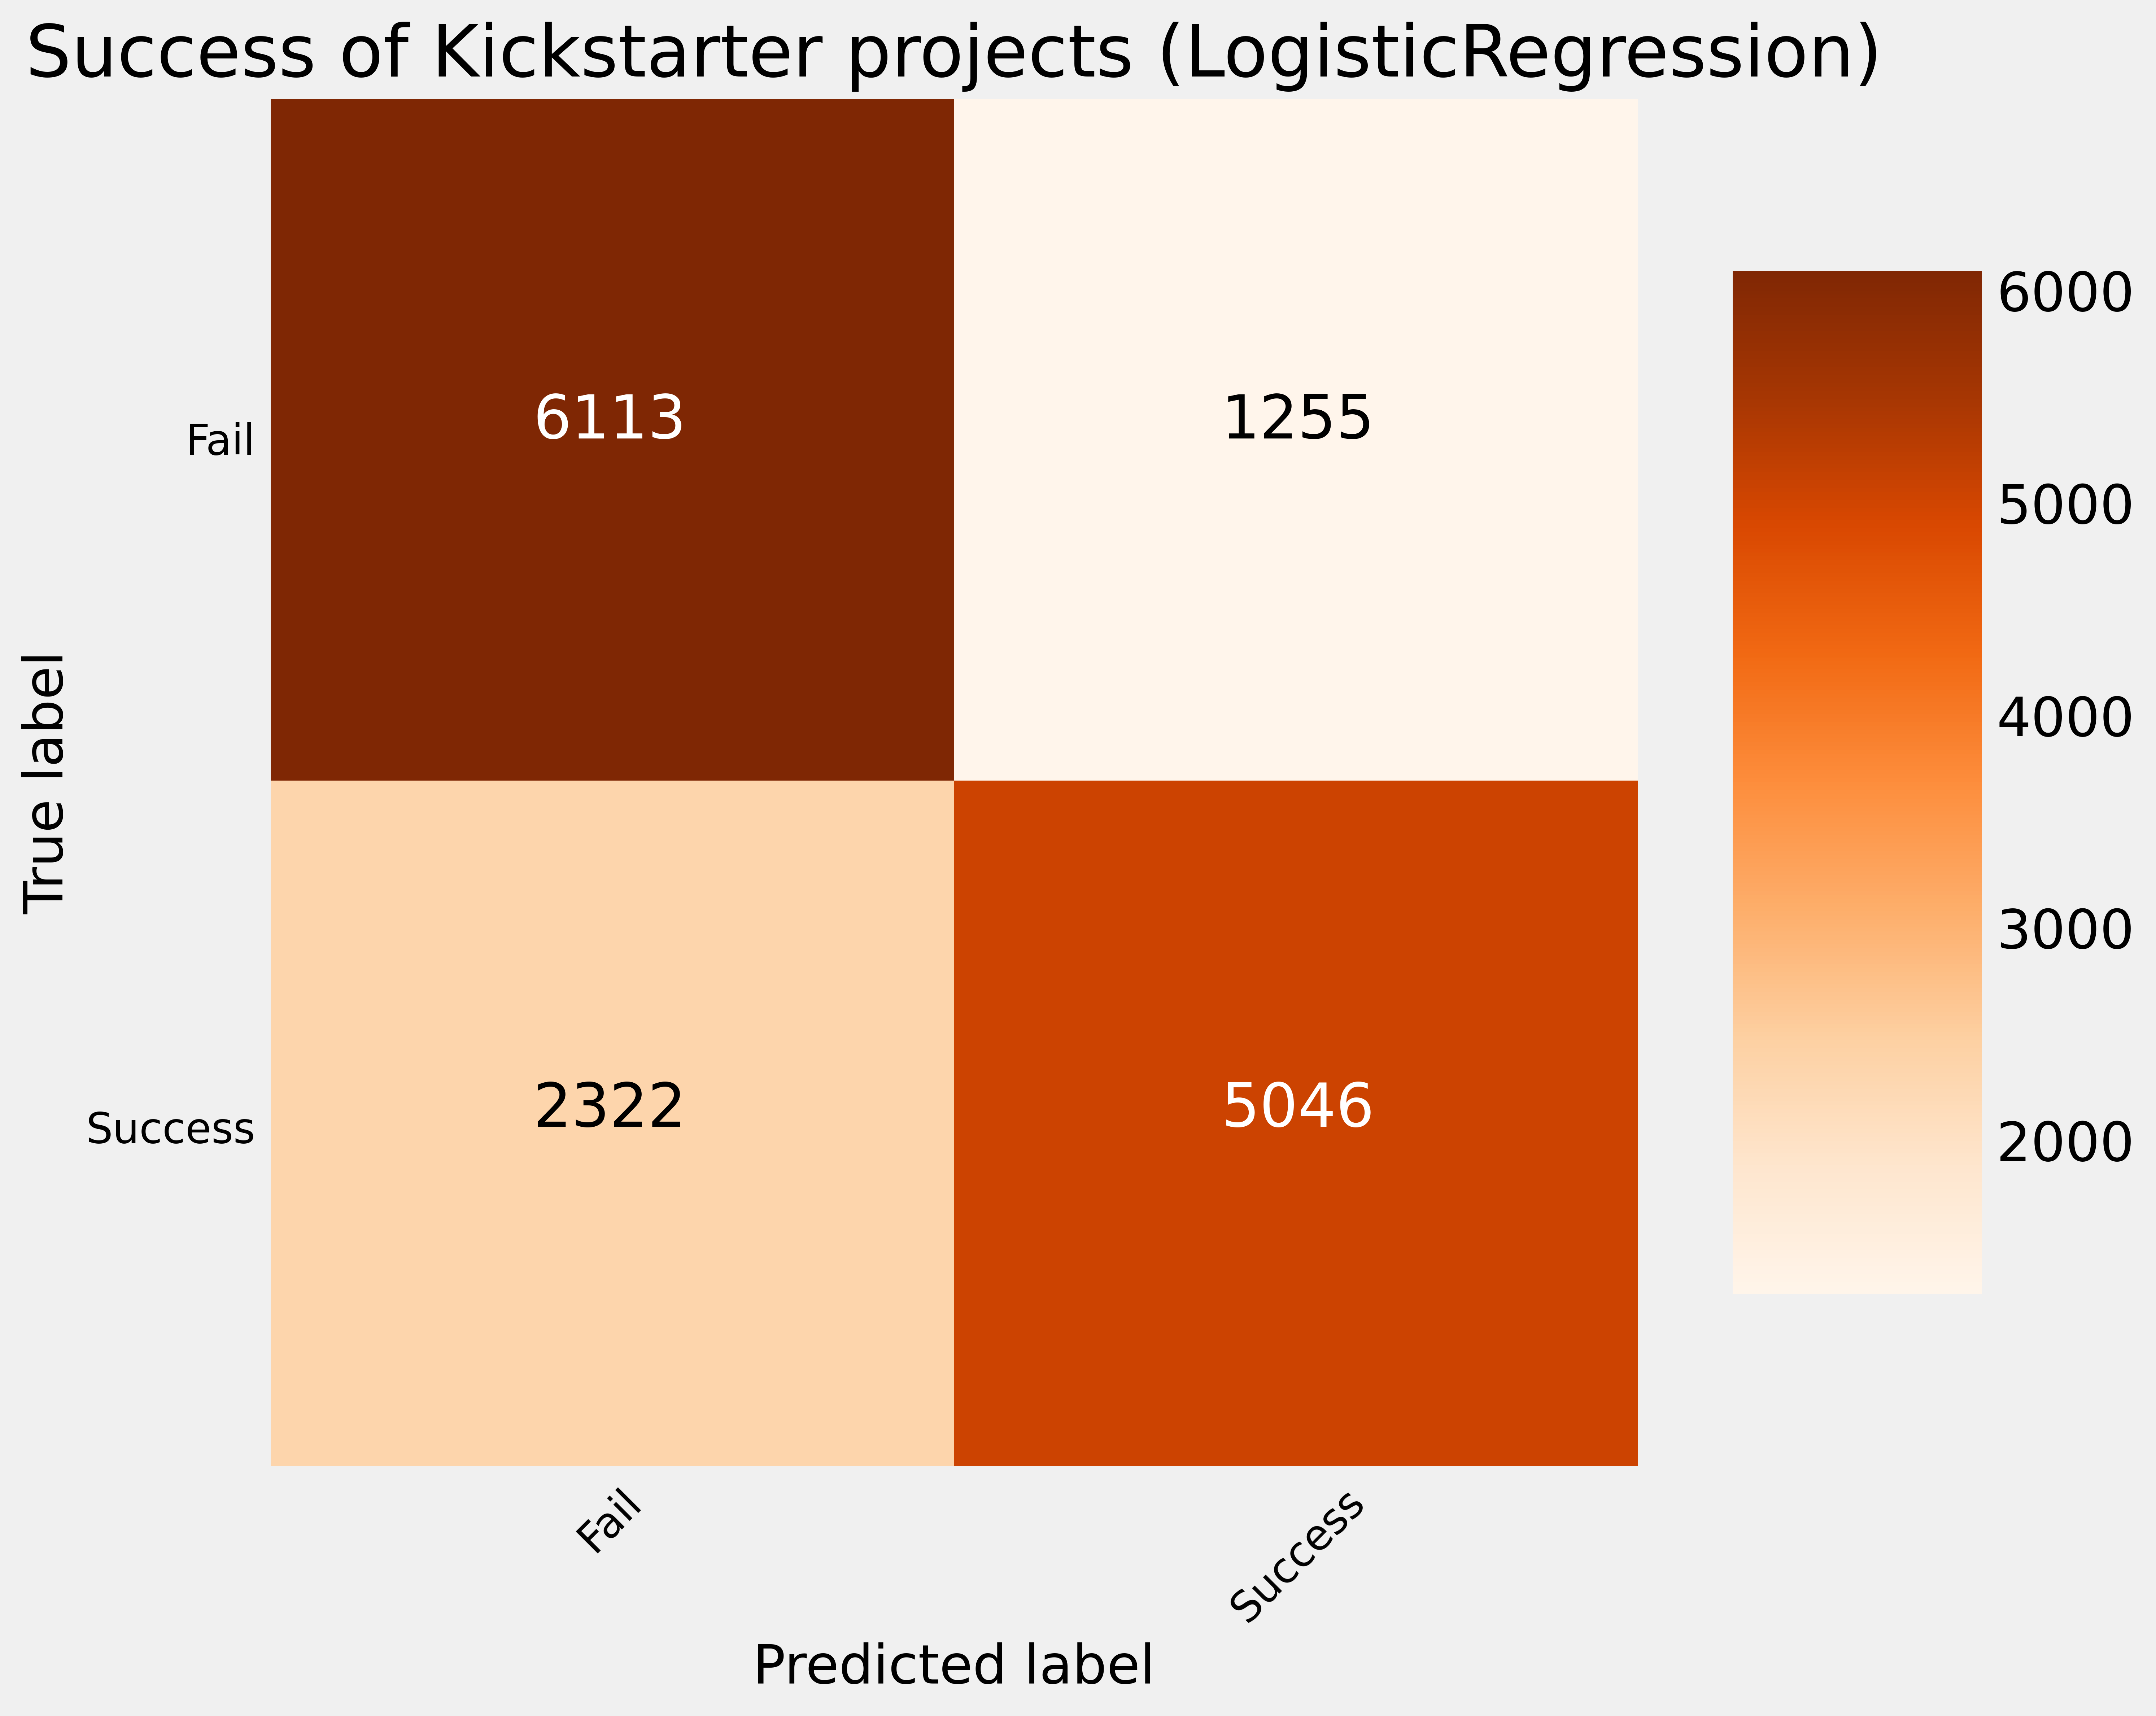

In [290]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=10000)
y_pred_lg = clf_train_predict(clf_lr, train, train_label, test)
cm = simple_metrics(test_label, y_pred_lg)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (LogisticRegression)'
)


Extra Trees

accuracy_score 0.8261400651465798
f1-score 0.8101378390395733
Confusion matrix, without normalization
[[6708  660]
 [1902 5466]]


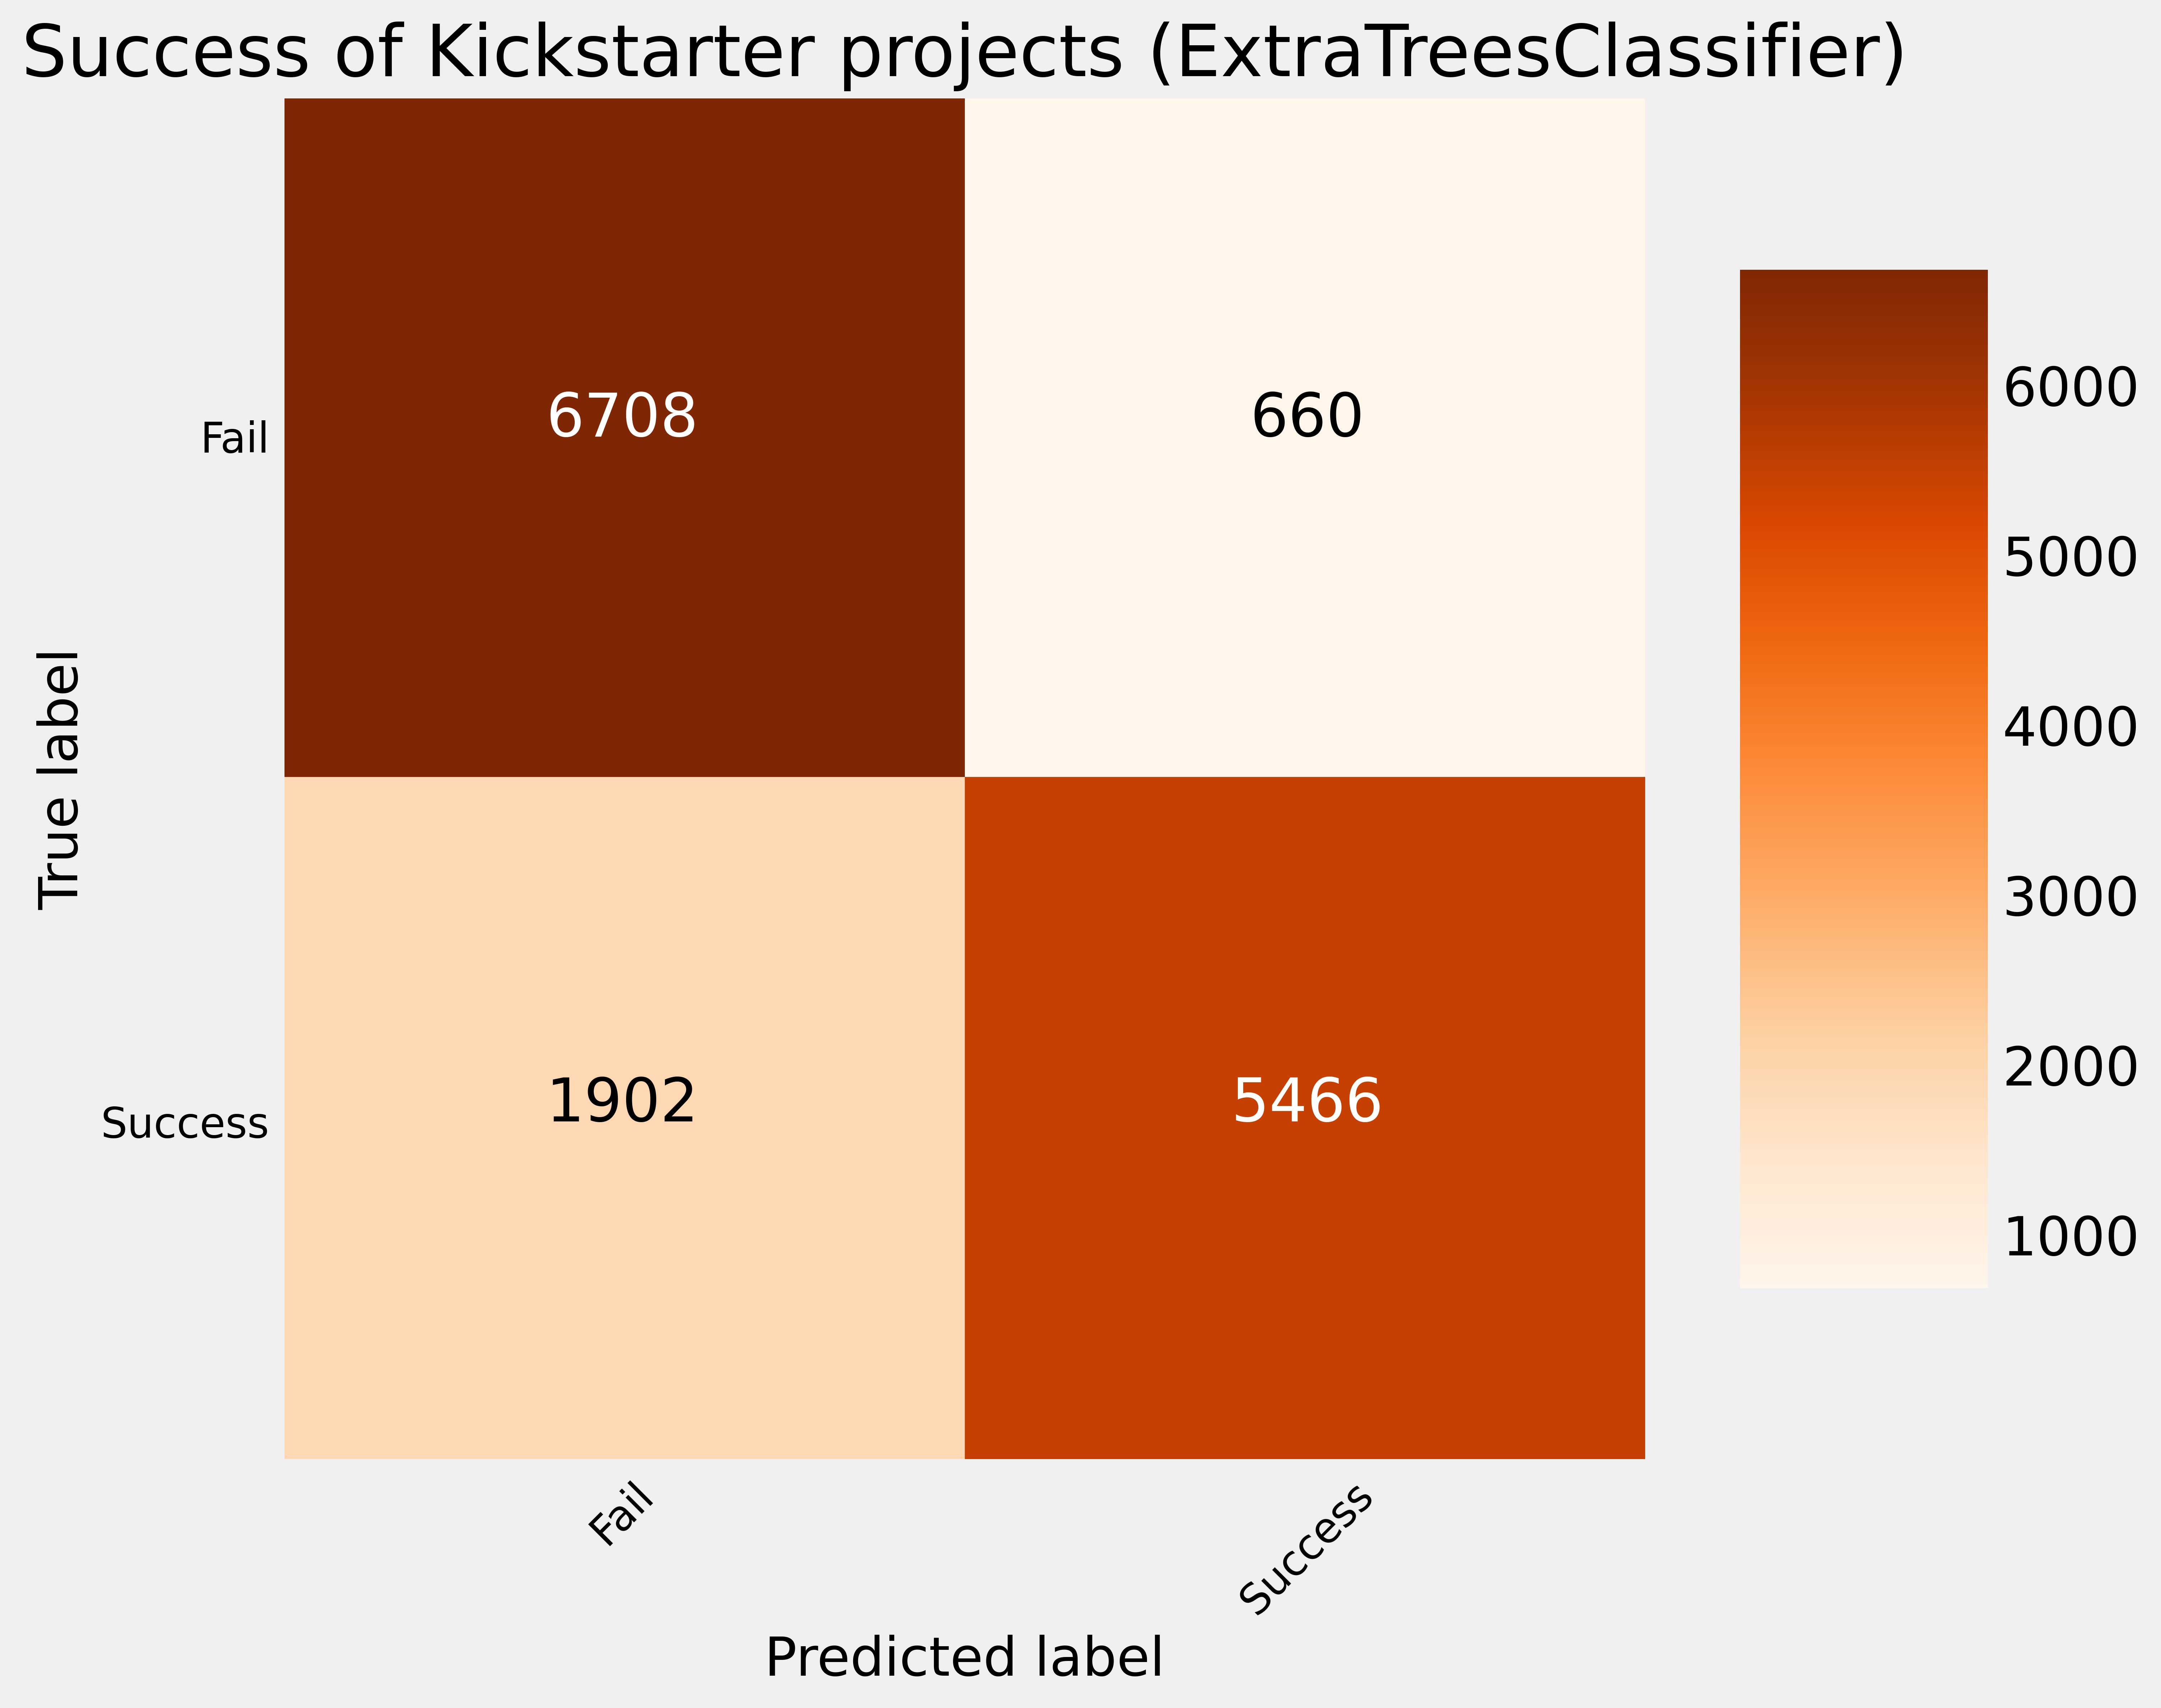

In [291]:
from sklearn.ensemble import ExtraTreesClassifier

clf_xt = ExtraTreesClassifier(n_estimators=200, n_jobs=-1)
y_pred_xt = clf_train_predict(clf_xt, train, train_label, test)
cm = simple_metrics(test_label, y_pred_xt)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (ExtraTreesClassifier)'
)

AdaBoost

accuracy_score 0.7558360477741585
f1-score 0.7413743530764808
Confusion matrix, without normalization
[[5981 1387]
 [2211 5157]]


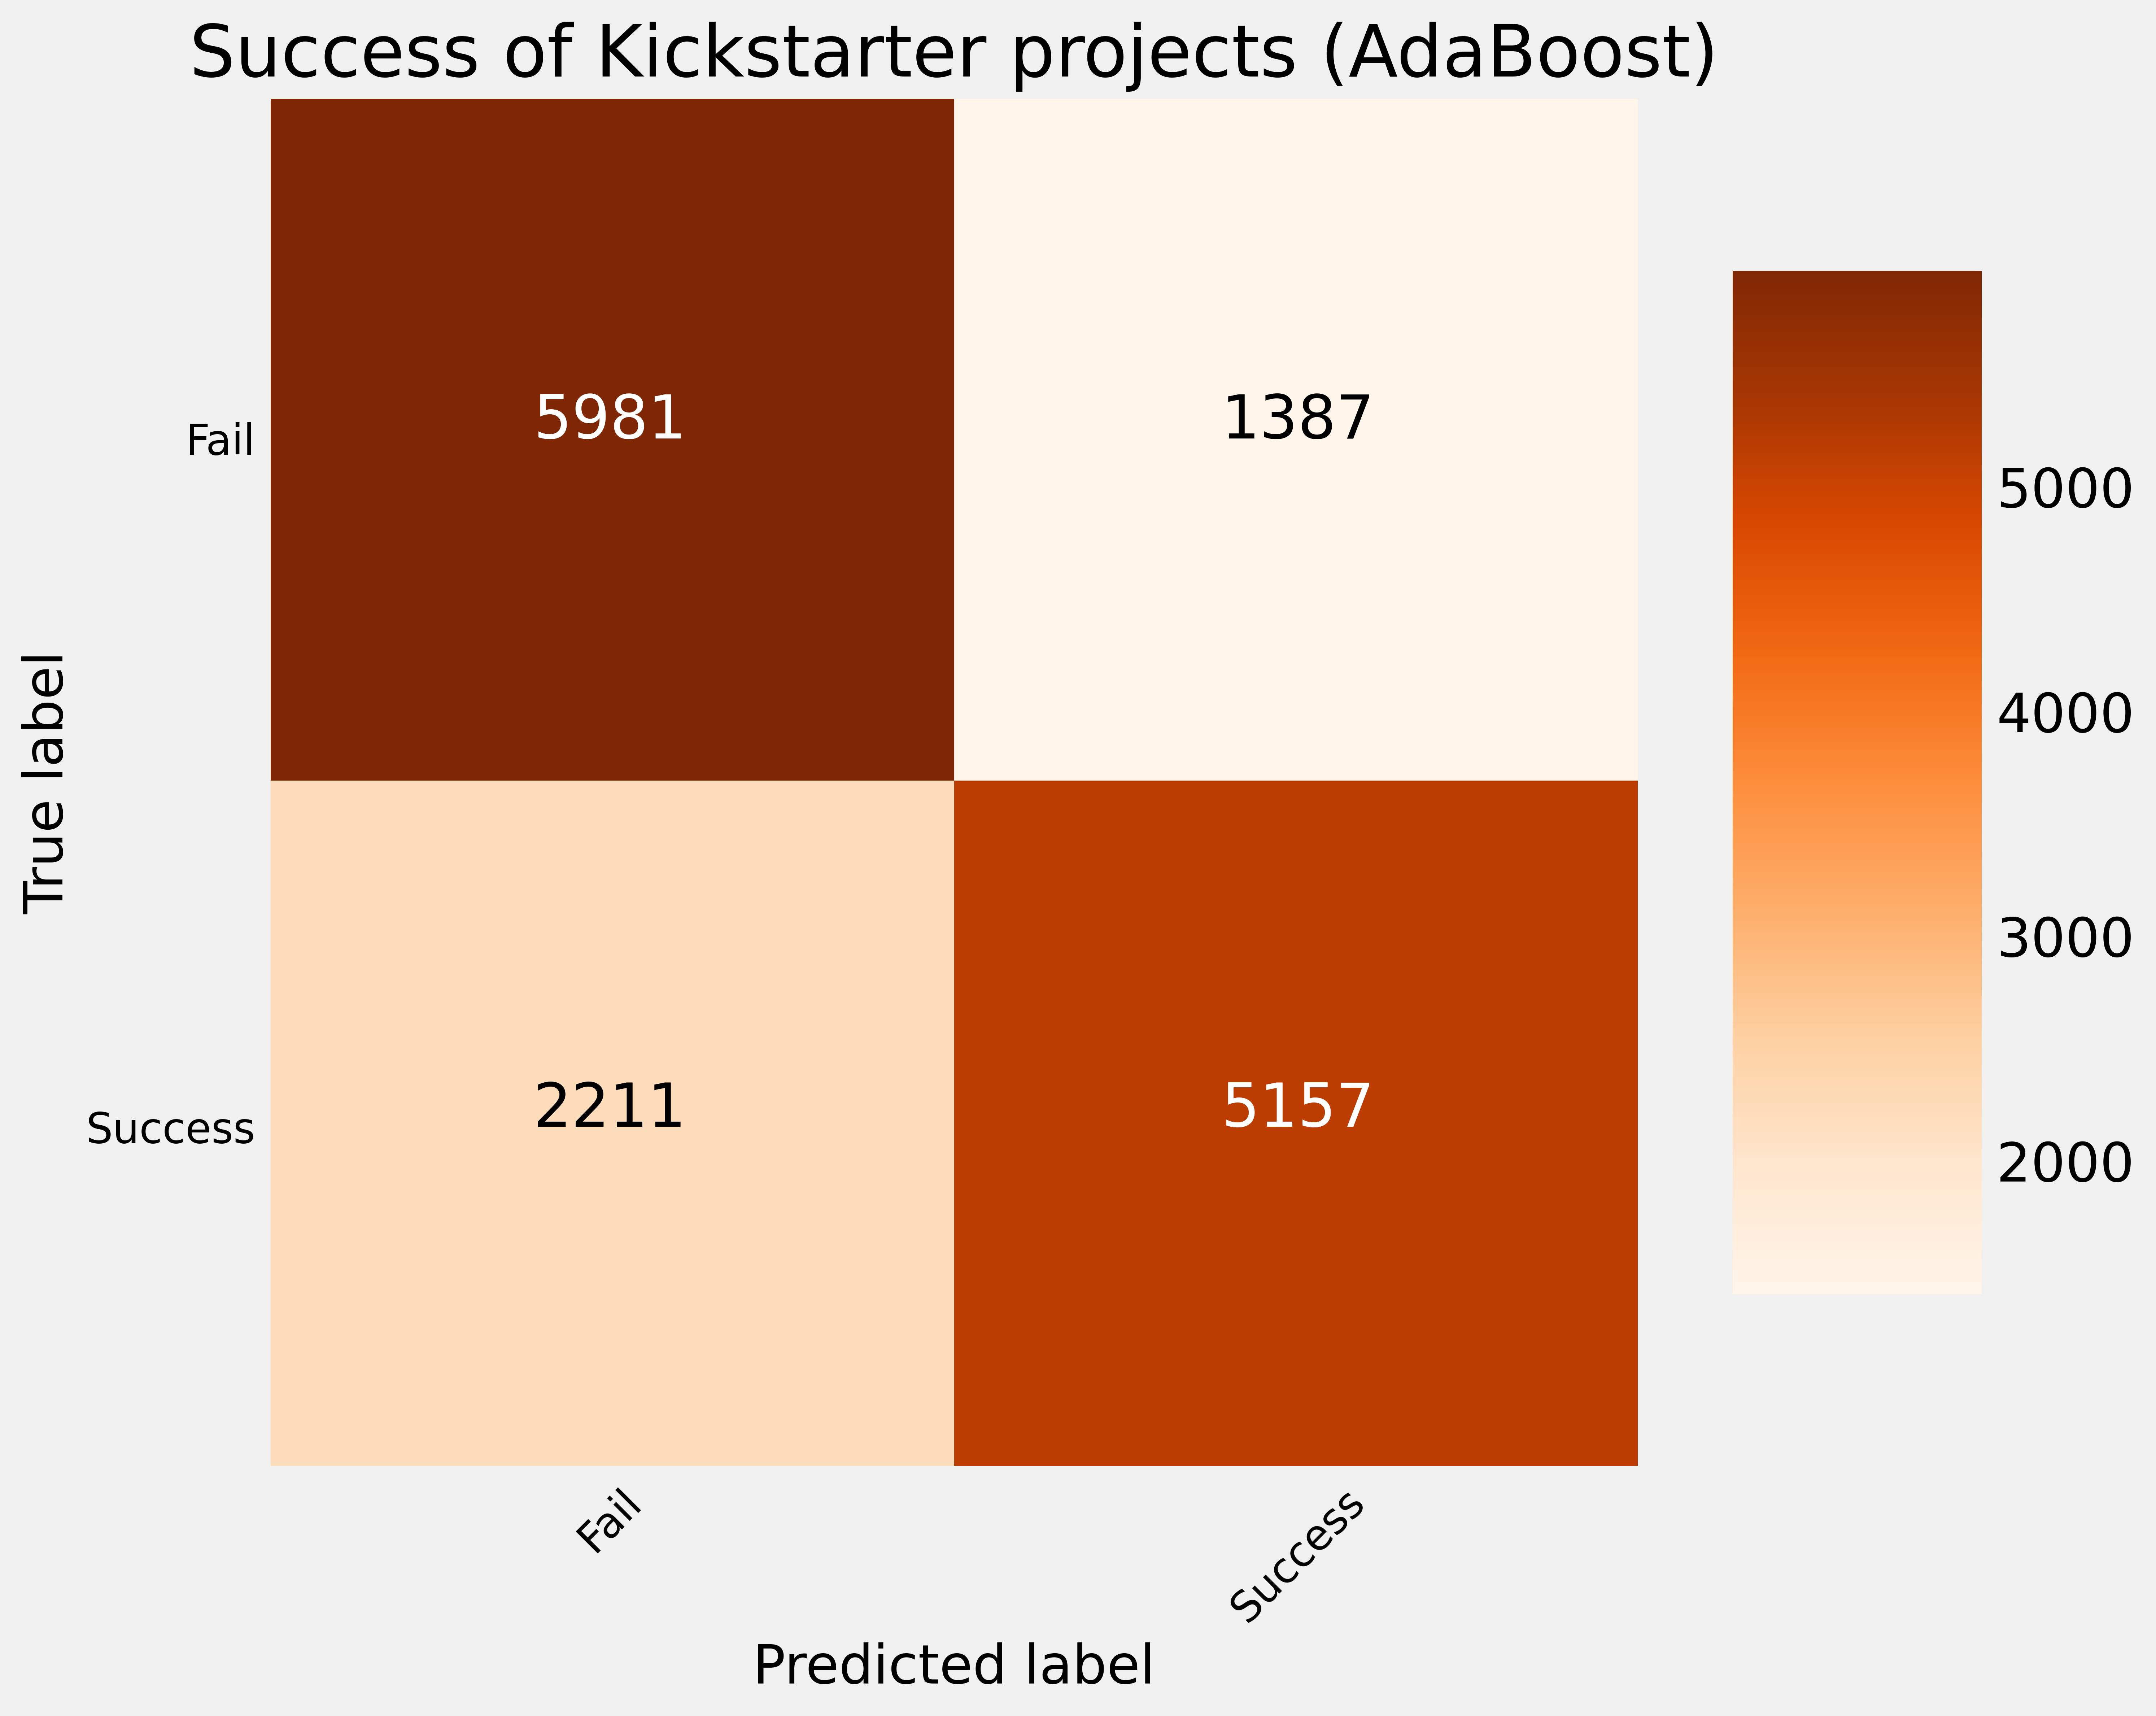

In [292]:
from sklearn.ensemble import AdaBoostClassifier

clf_ab = AdaBoostClassifier()
y_pred_ab = clf_train_predict(clf_ab, train, train_label, test)
cm = simple_metrics(test_label, y_pred_ab)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (AdaBoost)'
)

## Gridsearch using Random Forests

n_estimators=100
max_depth=None
min_samples_leaf=1
min_impurity_decrease=0.0


In [298]:
param_grid = {
        'n_estimators':[10, 50, 100], 
        'max_depth':[None, 100], 
        'min_impurity_decrease':[0.0, 0.005], 
        'min_samples_split':[2, 10],
        'max_features':[1, 10, 'sqrt', 0.2, 0.4, 'log2'], 
        'bootstrap':[True, False]}

gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), 
                        param_grid, scoring='f1',
                        cv=5, verbose=1, n_jobs=-1, n_iter=50)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 100],
                                        'max_features': [1, 10, 'sqrt', 0.2,
                                                         0.4, 'log2'],
                                        'min_impurity_decrease': [0.0, 0.005],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [10, 50, 100]},
                   scoring='f1', verbose=1)

In [299]:
best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

0.8005739026274703
{'n_estimators': 100, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 100, 'bootstrap': False}


accuracy_score 0.8391693811074918
f1-score 0.8306174957118352
Confusion matrix, without normalization
[[6555  813]
 [1557 5811]]


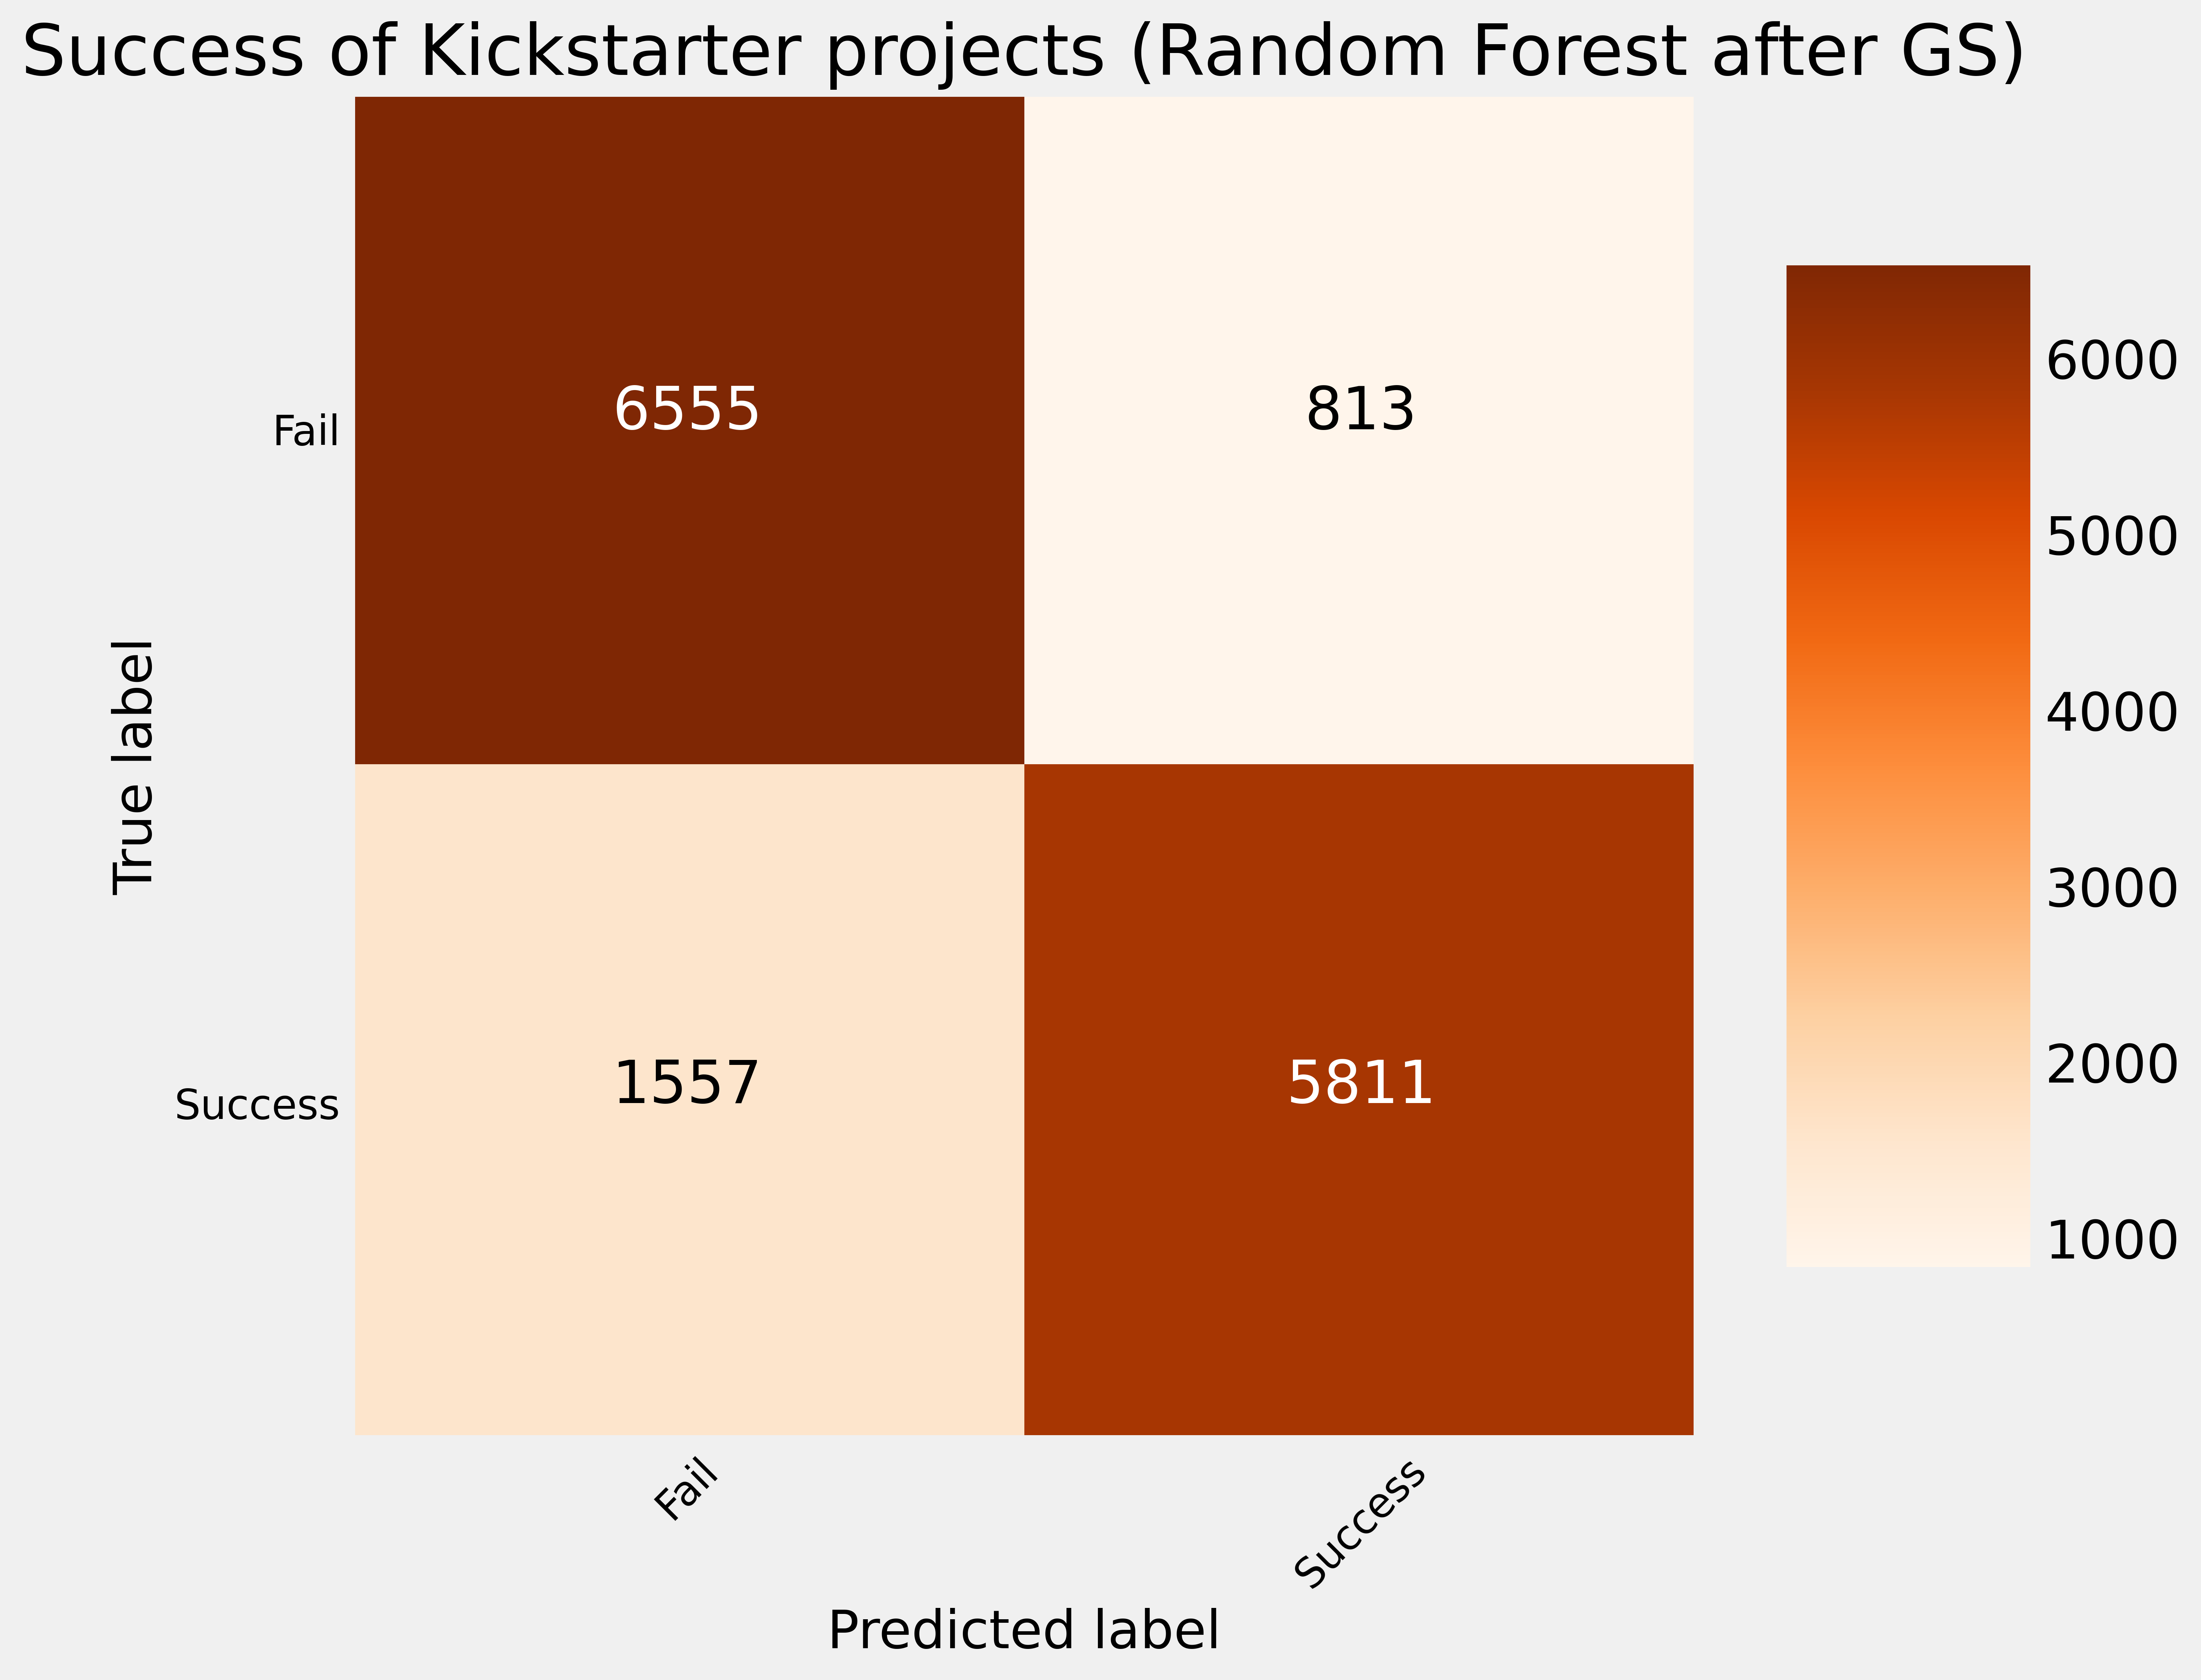

In [300]:
clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_rf_best.predict(test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)


2nd iteration

In [301]:
{'n_estimators': 100, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 
'max_features': 'log2', 'max_depth': 100, 'bootstrap': False}
param_grid = {
        'n_estimators':[50, 100, 200], 
        'max_depth':[None, 100, 200], 
        'min_impurity_decrease':[0.0], 
        'min_samples_split':[2, 10],
        'max_features':['log2', 'log10', 10, 50], 
        'bootstrap':[False]}
        
gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), 
                        param_grid, scoring='f1',
                        cv=5, verbose=1, n_jobs=-1, n_iter=40)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 441, in fit
    trees = Parallel(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [None, 100, 200],
                                        'max_features': ['log2', 'log10', 10,
                                                         50],
                                        'min_impurity_decrease': [0.0],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='f1', verbose=1)

0.8019402873155921
{'n_estimators': 200, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 200, 'bootstrap': False}
accuracy_score 0.8435124864277959
f1-score 0.8350972540045767
Confusion matrix, without normalization
[[6591  777]
 [1529 5839]]


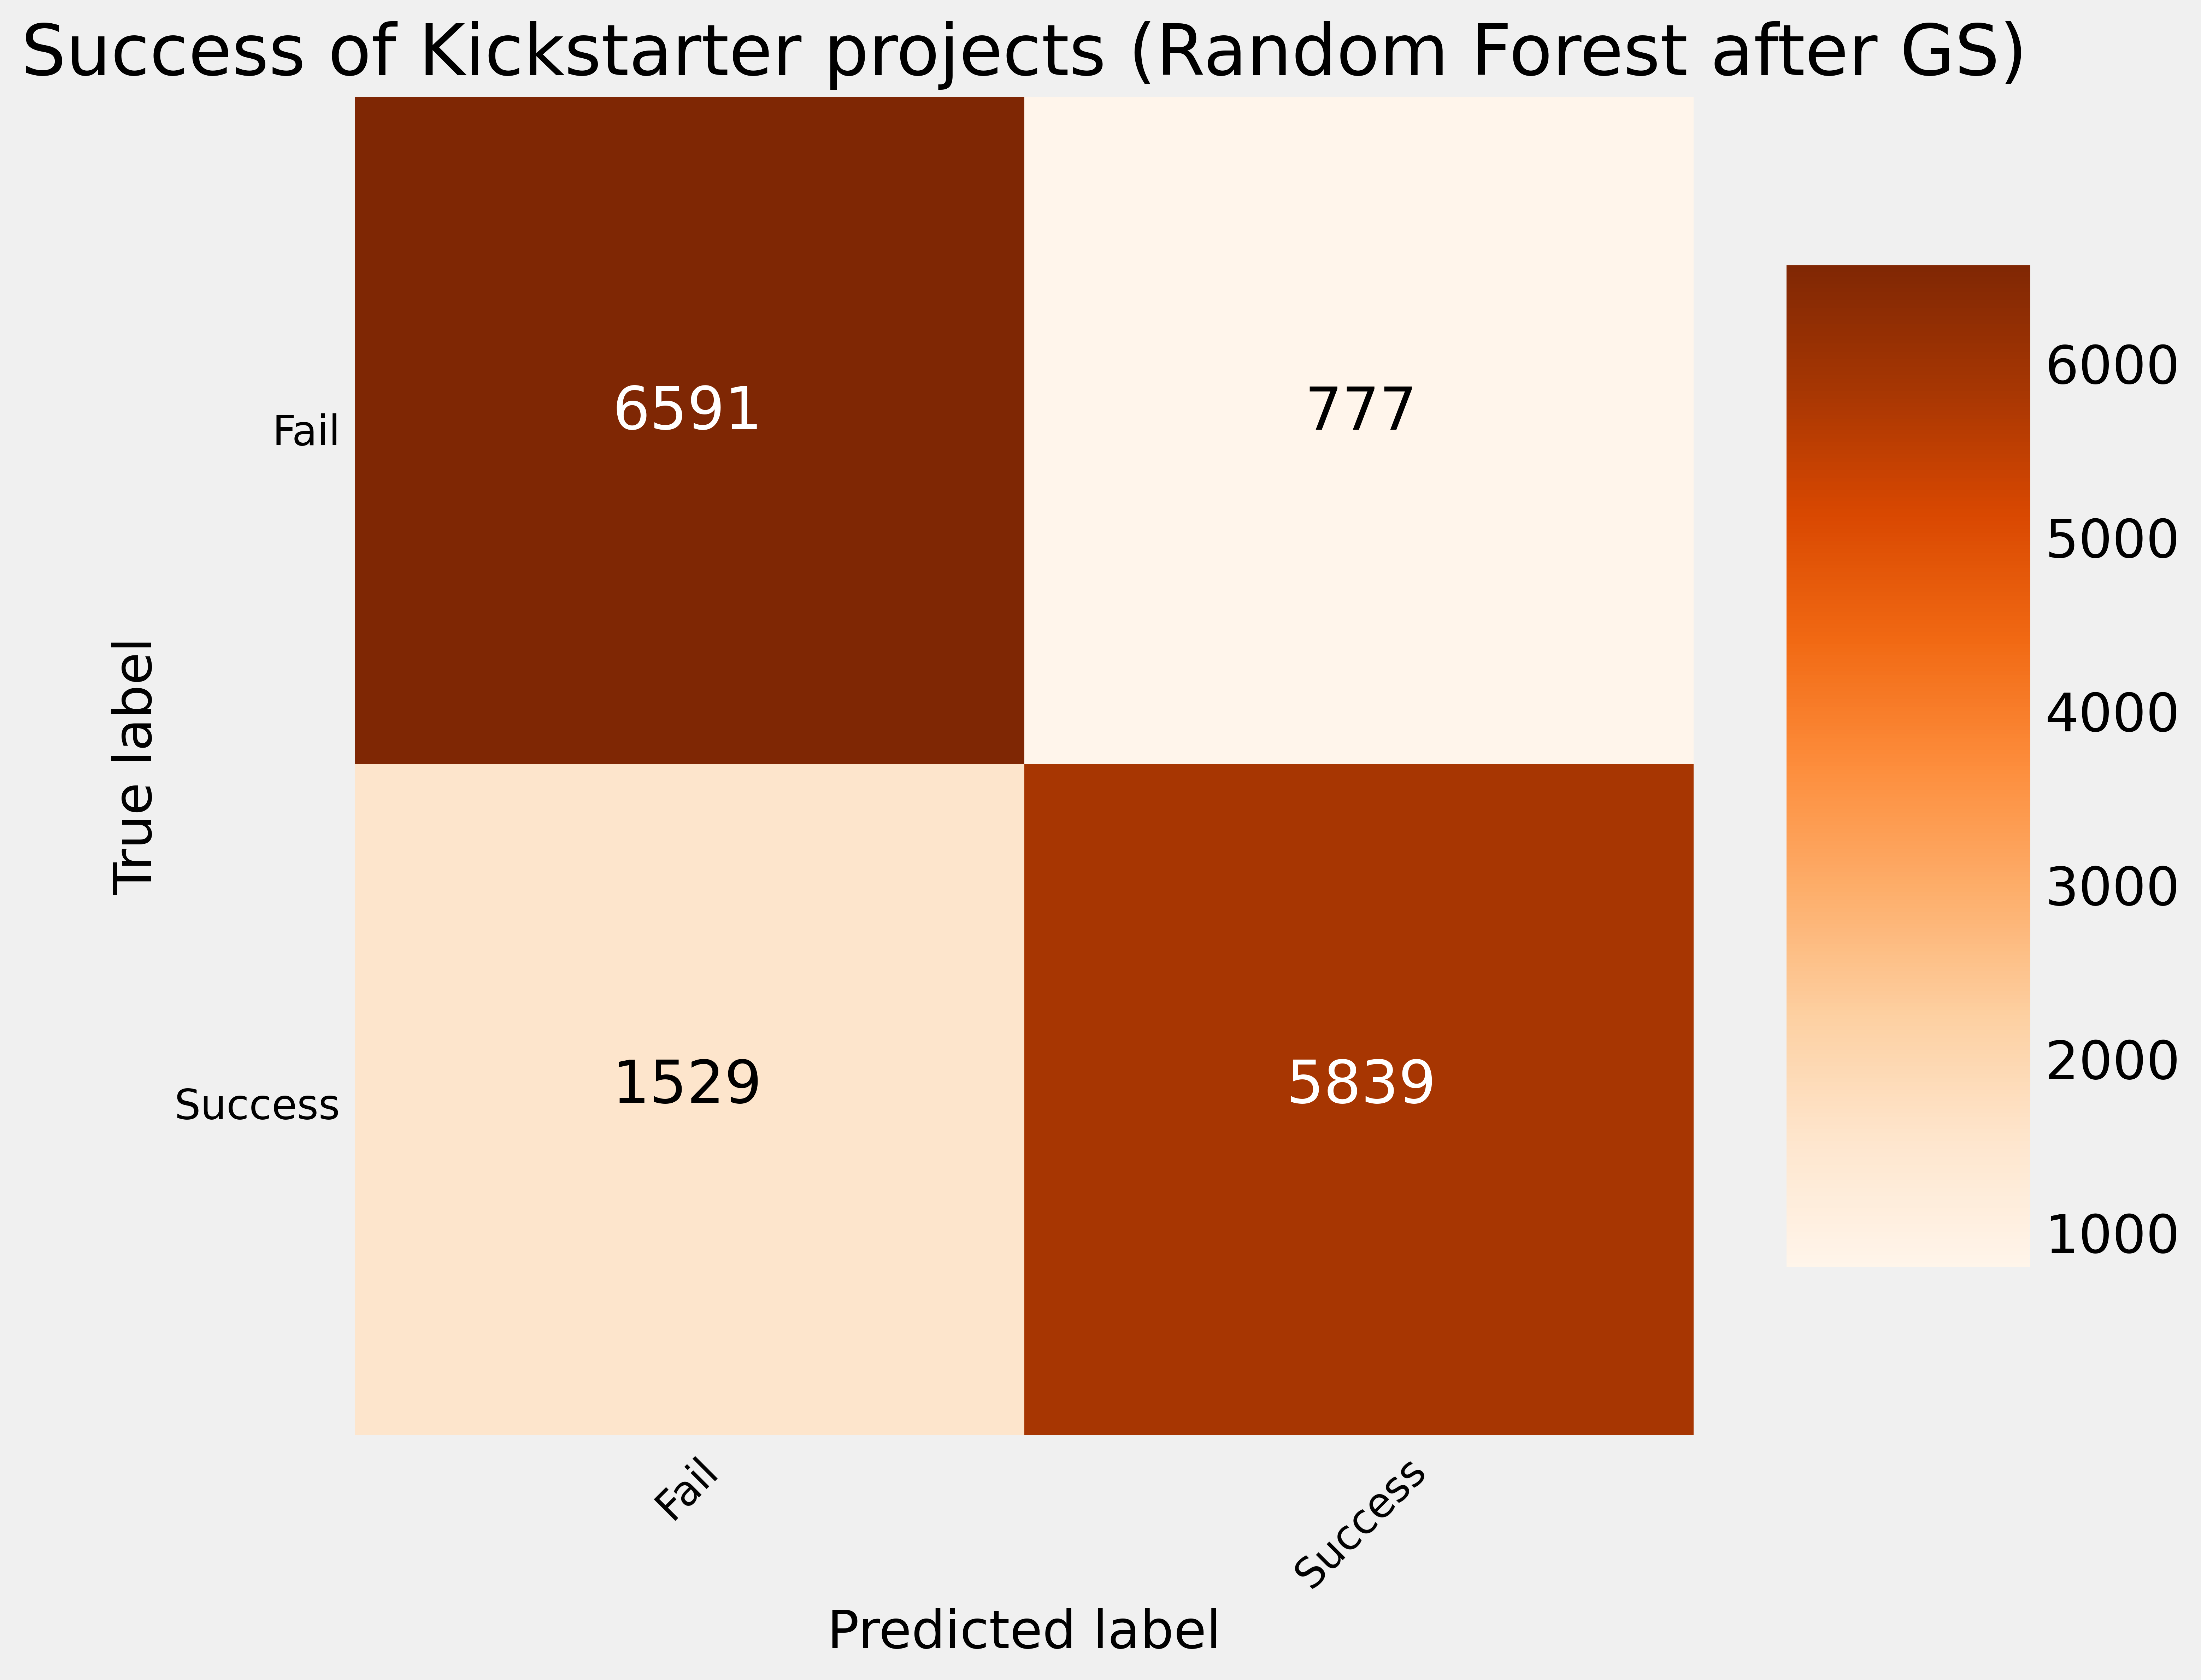

In [302]:
best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_rf_best.predict(test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)

3rd iteration

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.8024884838059245
{'n_estimators': 400, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 300, 'bootstrap': False}
accuracy_score 0.8429695982627579
f1-score 0.8349265230418034
Confusion matrix, without normalization
[[6570  798]
 [1516 5852]]


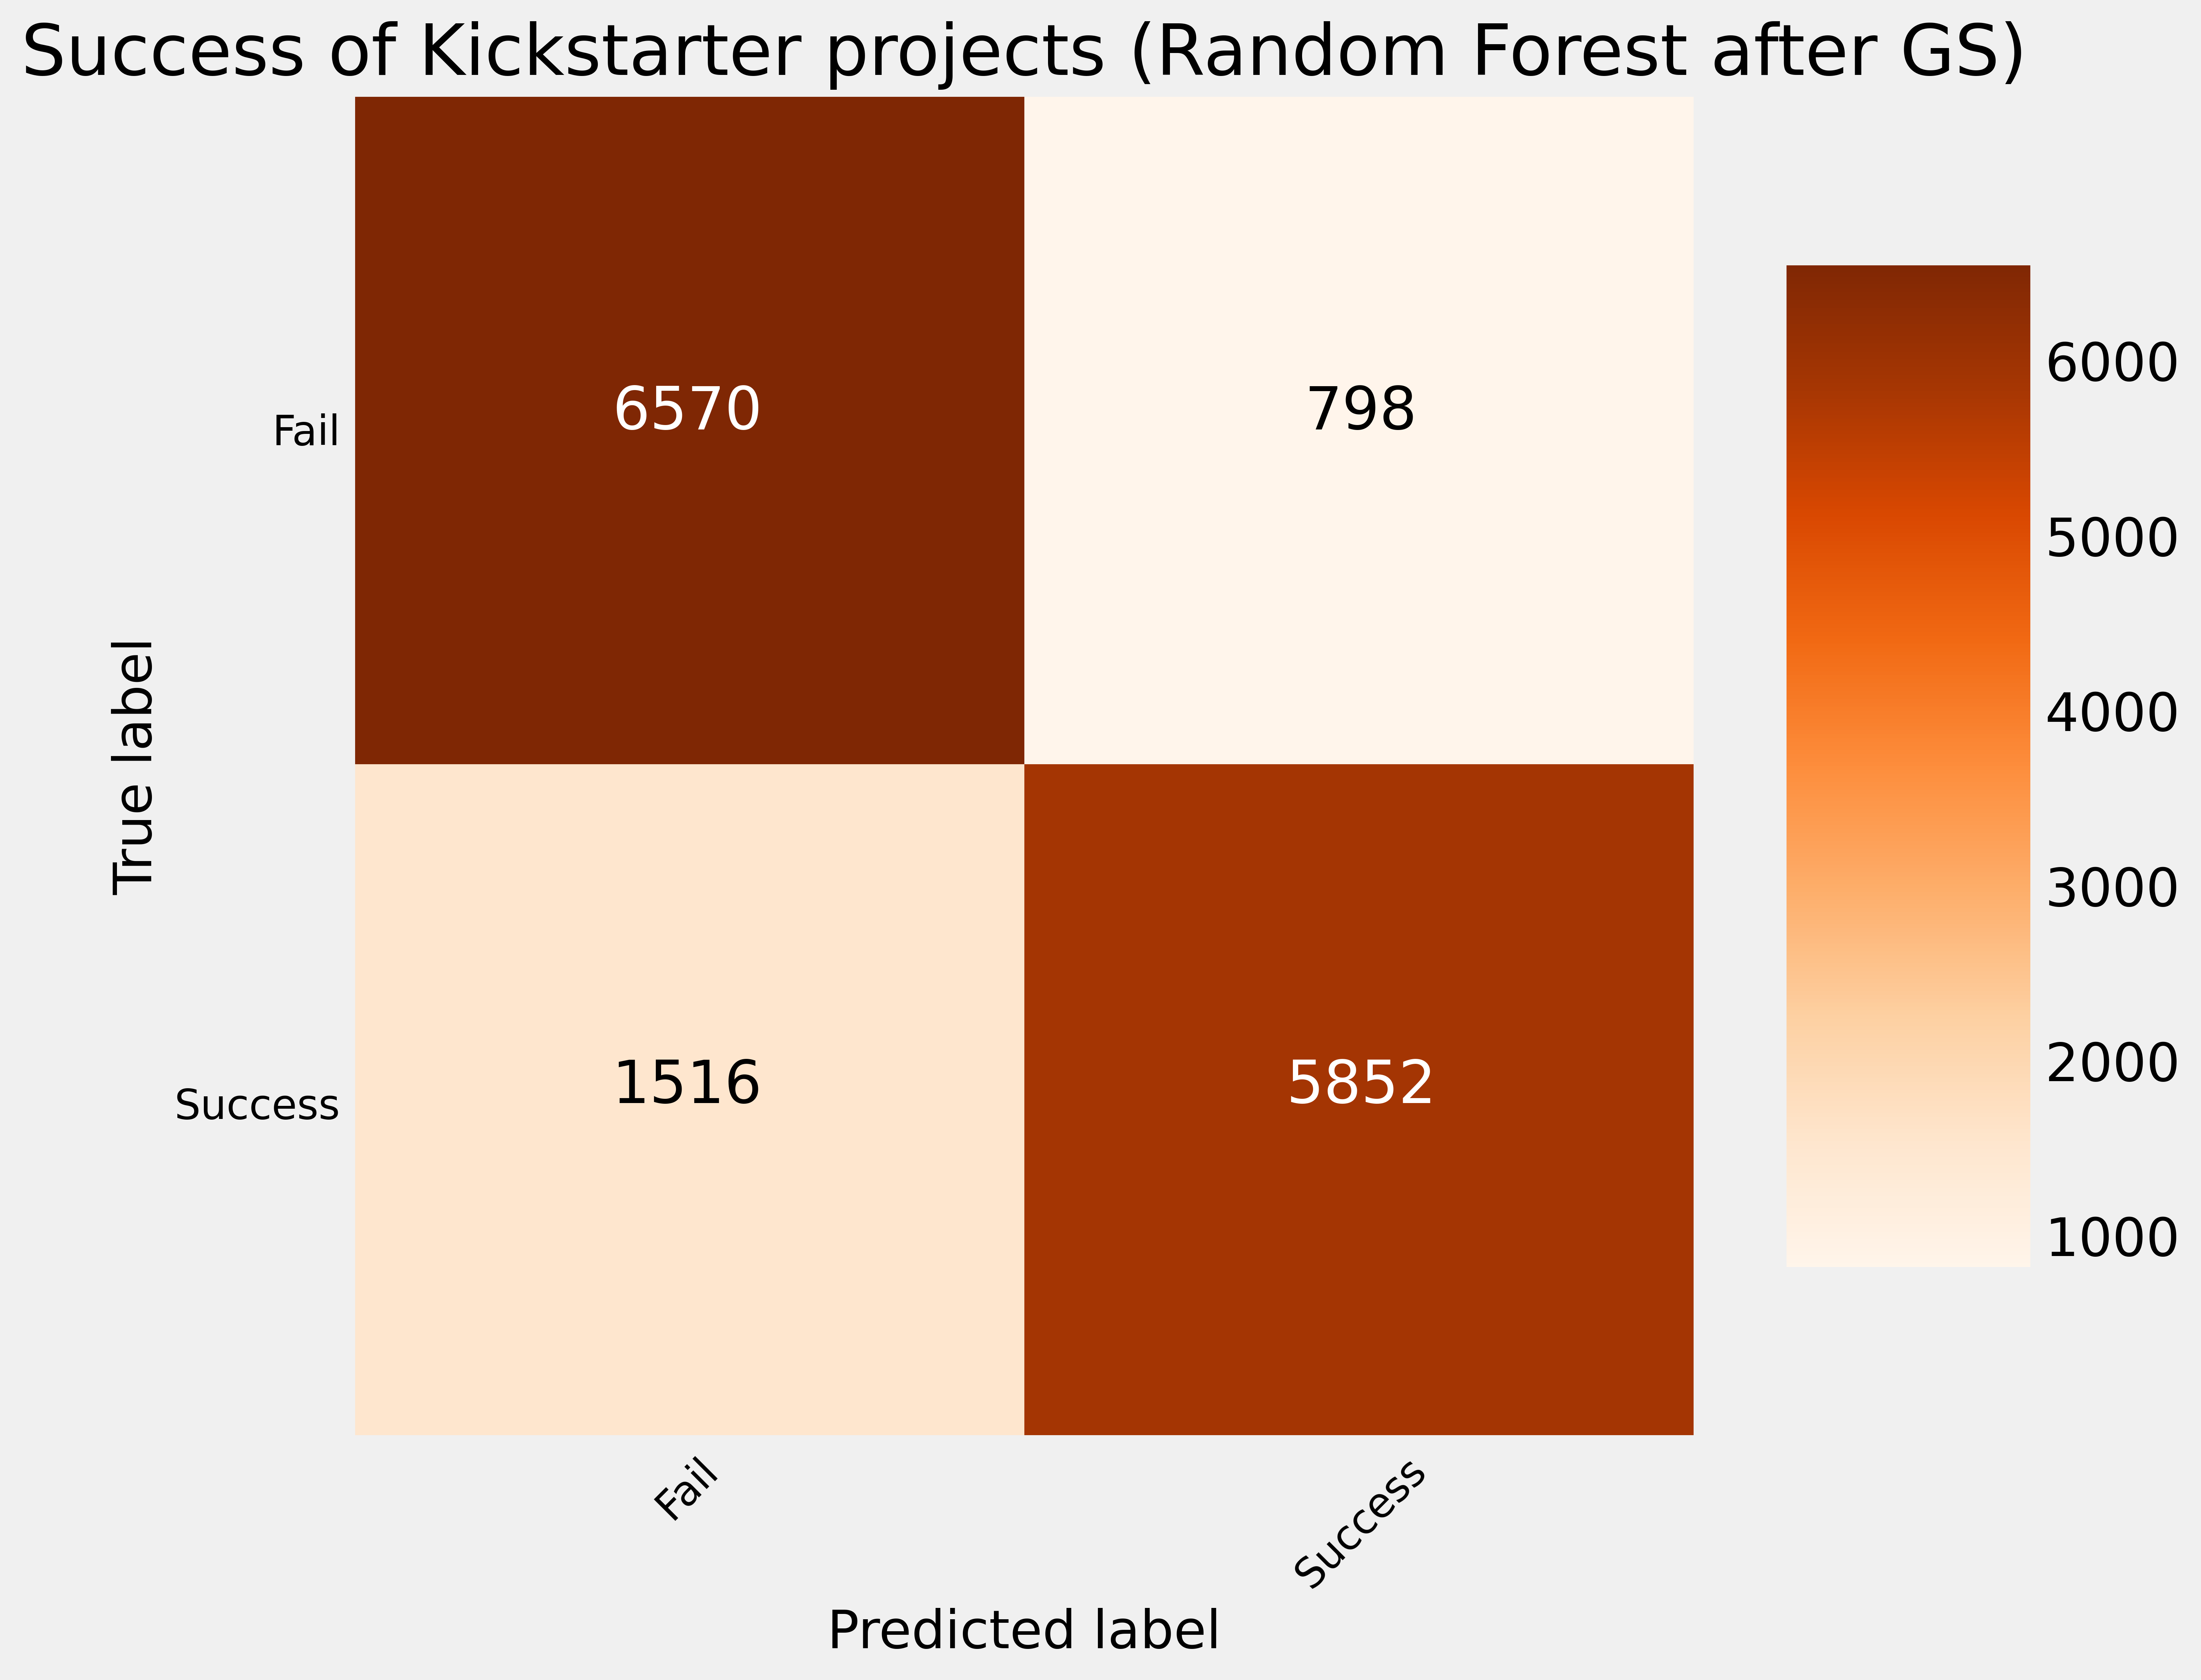

In [303]:
{'n_estimators': 200, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 
'max_features': 'log2', 'max_depth': 200, 'bootstrap': False}
param_grid = {
        'n_estimators':[200, 400], 
        'max_depth':[300, 200], 
        'min_impurity_decrease':[0.0], 
        'min_samples_split':[2],
        'max_features':['log2', 'sqrt'], 
        'bootstrap':[False]}
        
gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), 
                    param_grid, scoring='f1',
                    cv=5, verbose=1, n_jobs=-1, n_iter=50)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)

best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_rf_best.predict(test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)

4th Iteration

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
130 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
130 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 441, in fit
    trees = Parallel

0.8026828826958164
{'n_estimators': 300, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 300, 'bootstrap': False}
accuracy_score 0.8431731813246471
f1-score 0.8349639362993645
Confusion matrix, without normalization
[[6579  789]
 [1522 5846]]


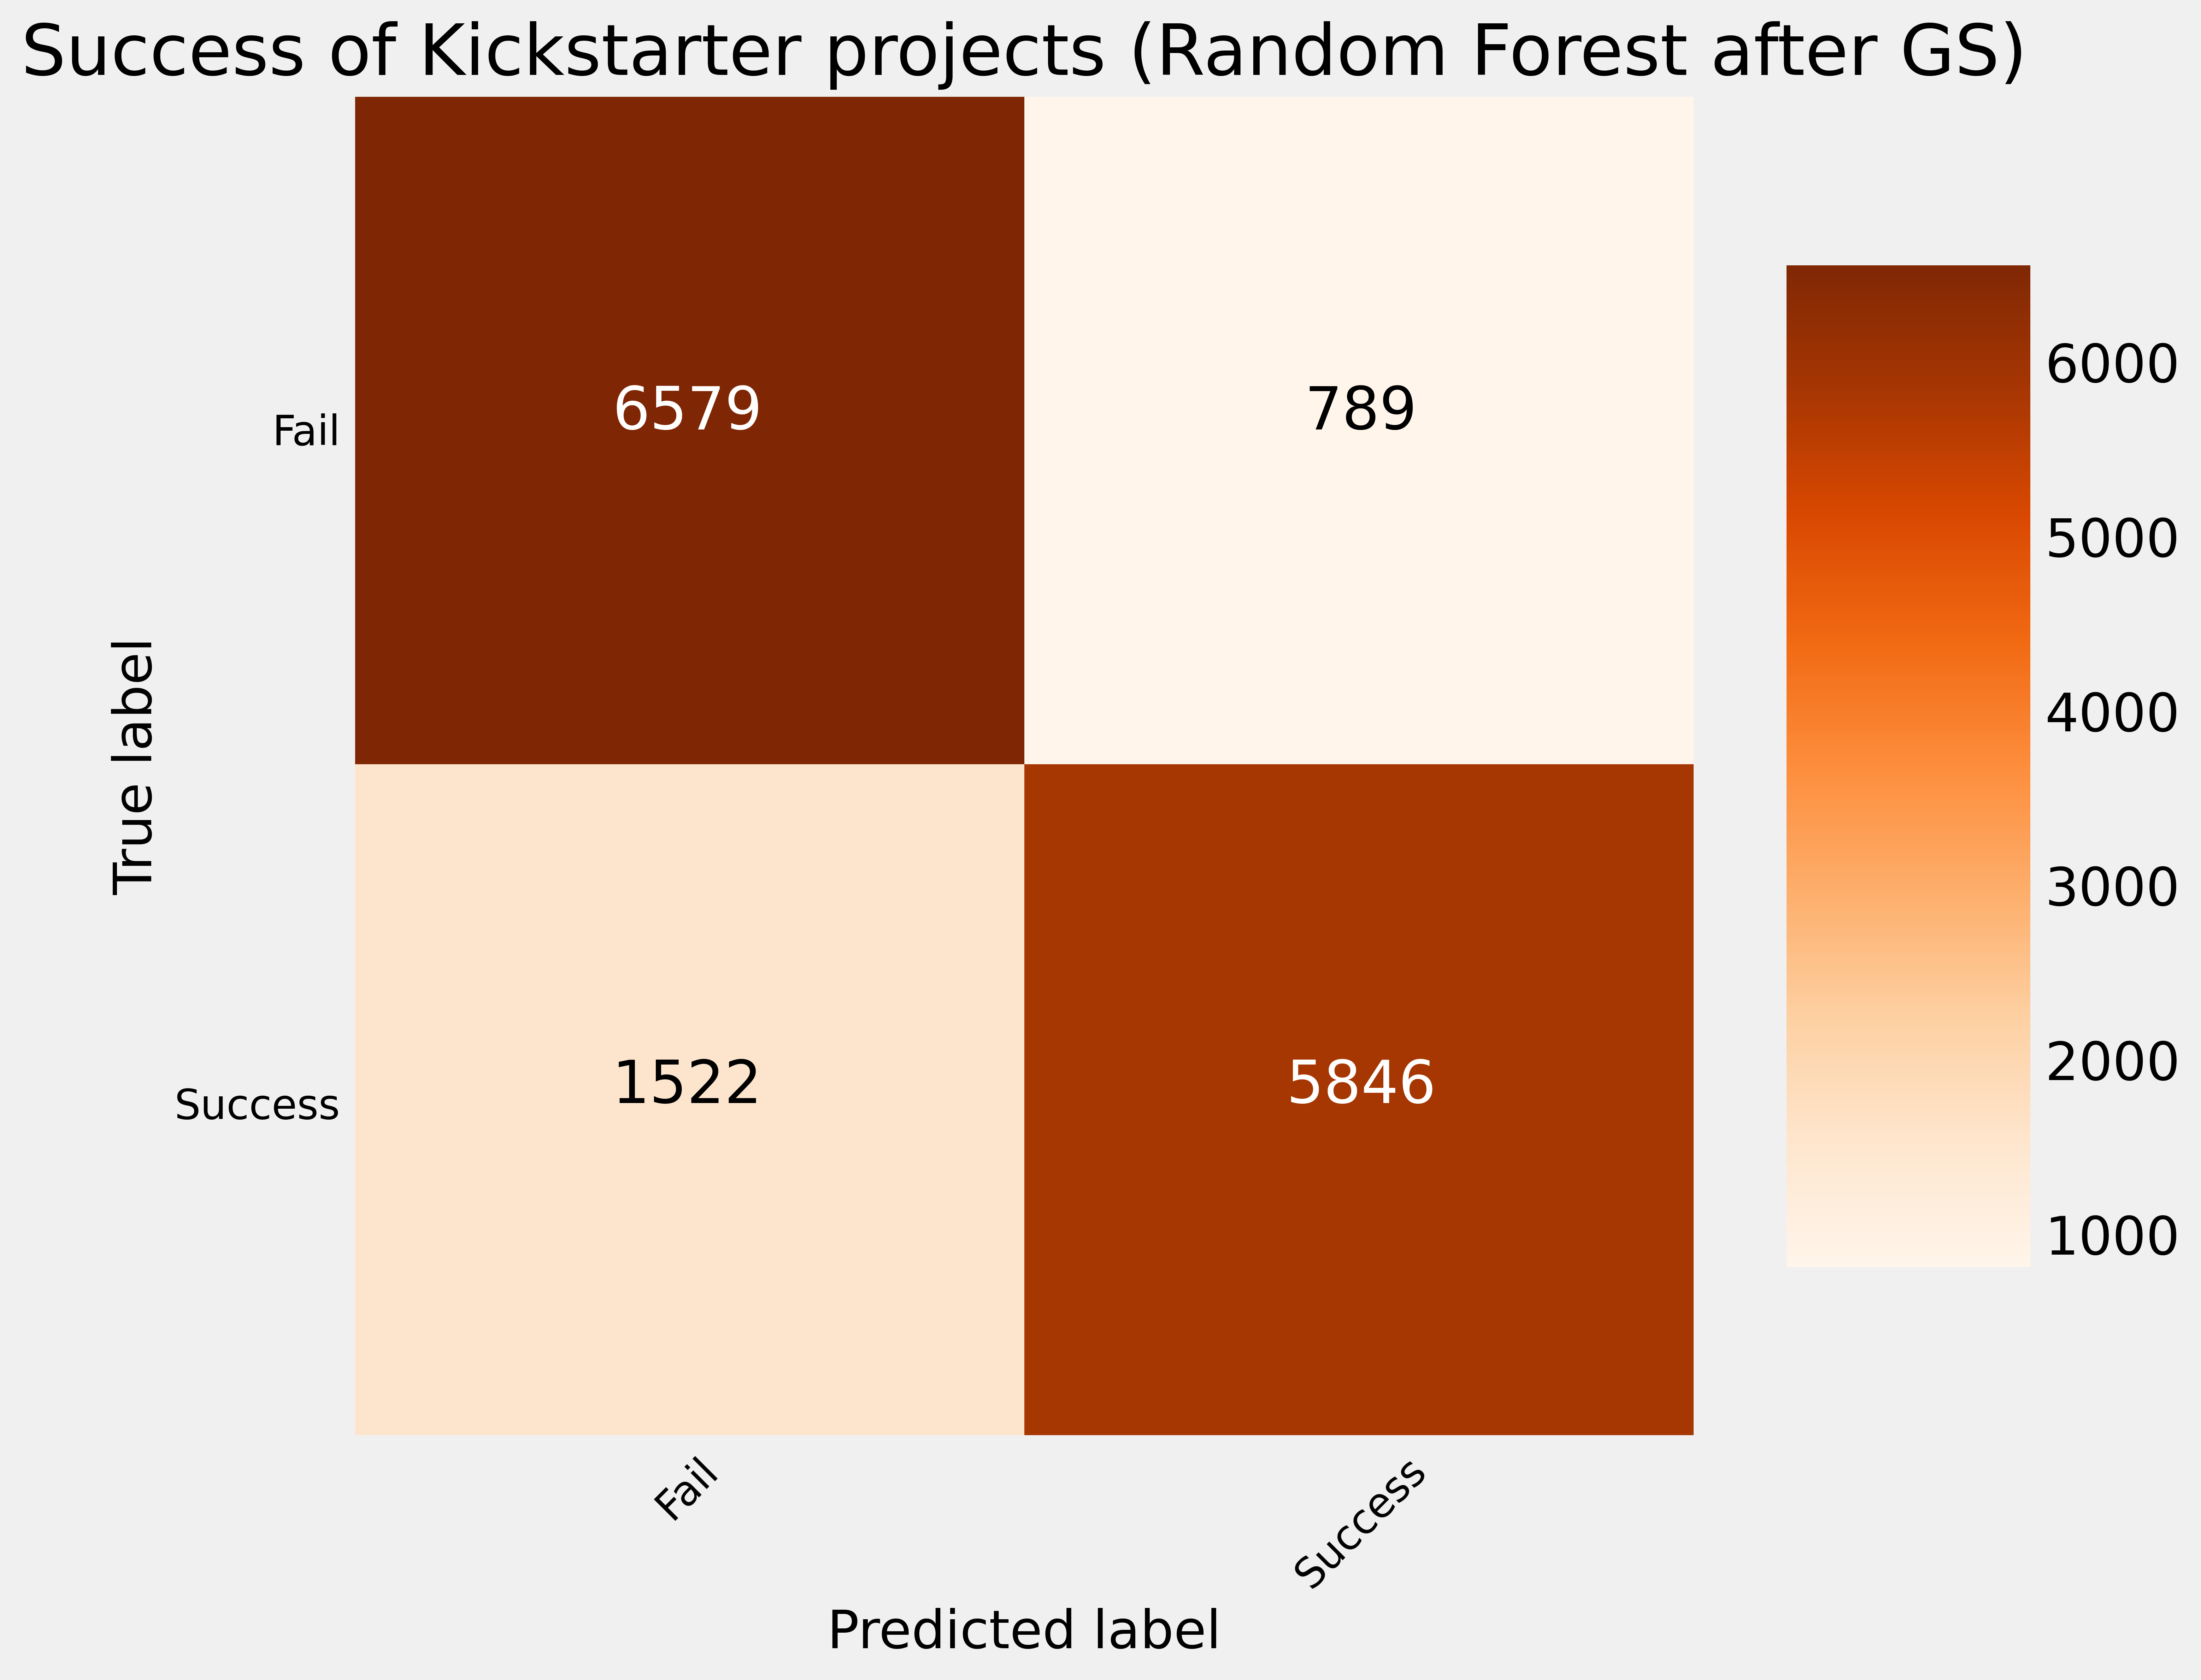

In [304]:
{'n_estimators': 200, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 
'max_features': 'log2', 'max_depth': 200, 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 
'max_features': 'log2', 'max_depth': 300, 'bootstrap': False}
param_grid = {
        'n_estimators':[200, 300, 400, 600], 
        'max_depth':[300, 200, 400, 20], 
        'min_impurity_decrease':[0.0], 
        'min_samples_split':[2, 50],
        'max_features':['log2', 'log10'], 
        'bootstrap':[False]}
        
gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), 
                    param_grid, scoring='f1',
                    cv=5, verbose=1, n_jobs=-1, n_iter=50)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)

best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_rf_best.predict(test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)

## Randomized Search using Extreme Tree

## Stacking

Random forest + logistic regression + XGBoost

In [ ]:
#clf_stacking = ??
# clf_stack = StackingClassifier([('Random_Forest', clf_rf),
# ('XGB',clf_xgb),
# ('Naive Bayes',clf_lr)], cv=5)
clf_stack = StackingClassifier([
    ('Random_Forest', clf_rf),
    ('Extreme Tree', clf_xt)], 
    cv=5, n_jobs=-1)
y_pred_stack = clf_train_predict(clf_stack, train, train_label, test)
cm = simple_metrics(test_label, y_pred_stack)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (SVM)'
)